In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2019/PRUEBA B.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=185.5, y1=109.2
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 519
Page 1, Q1, A: Yellow percentage: 0.0%


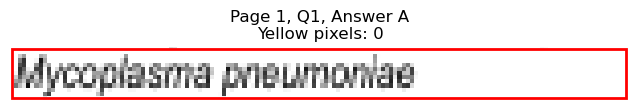

Page 1, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=122.3, y1=121.3
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 183
Page 1, Q1, B: Yellow percentage: 0.0%


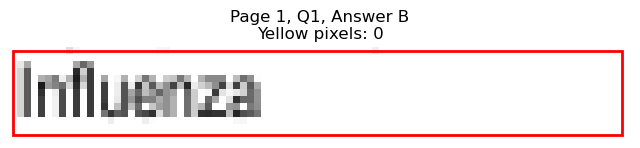

Page 1, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=183.1, y1=133.3
Page 1, Q1, C: Yellow pixels: 150
Page 1, Q1, C: Total non-white pixels: 640
Page 1, Q1, C: Yellow percentage: 23.4%


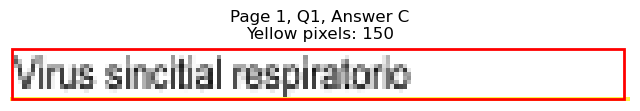

Page 1, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=414.7, y1=109.2
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 415
Page 1, Q1, D: Yellow percentage: 0.0%


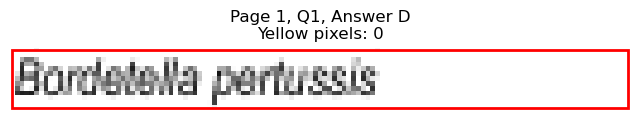

Page 1, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=382.2, y1=121.3
Page 1, Q1, E: Yellow pixels: 980
Page 1, Q1, E: Total non-white pixels: 1261
Page 1, Q1, E: Yellow percentage: 77.7%


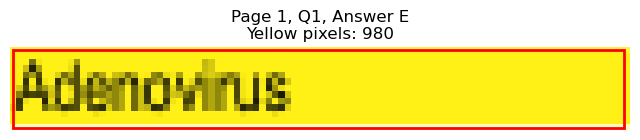


Page 1, Q1 - Selected Answer: E (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=85.0, y0=169.4, x1=117.0, y1=181.5
Page 1, Q2, A: Yellow pixels: 0
Page 1, Q2, A: Total non-white pixels: 158
Page 1, Q2, A: Yellow percentage: 0.0%


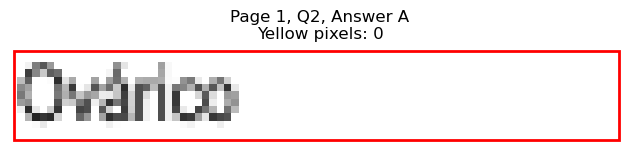

Page 1, Q2 - B: Detected box: x0=85.0, y0=181.4, x1=114.6, y1=193.5
Page 1, Q2, B: Yellow pixels: 81
Page 1, Q2, B: Total non-white pixels: 234
Page 1, Q2, B: Yellow percentage: 34.6%


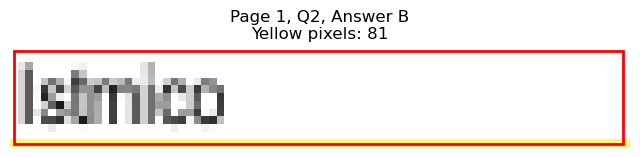

Page 1, Q2 - C: Detected box: x0=85.0, y0=193.4, x1=126.1, y1=205.5
Page 1, Q2, C: Yellow pixels: 1028
Page 1, Q2, C: Total non-white pixels: 1209
Page 1, Q2, C: Yellow percentage: 85.0%


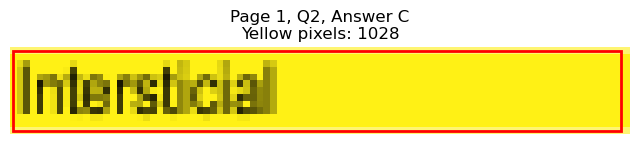

Page 1, Q2 - D: Detected box: x0=336.7, y0=169.4, x1=371.1, y1=181.5
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 170
Page 1, Q2, D: Yellow percentage: 0.0%


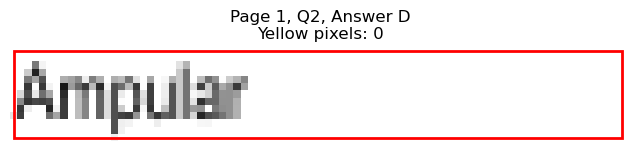

Page 1, Q2 - E: Detected box: x0=336.7, y0=181.4, x1=379.8, y1=193.5
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 217
Page 1, Q2, E: Yellow percentage: 0.0%


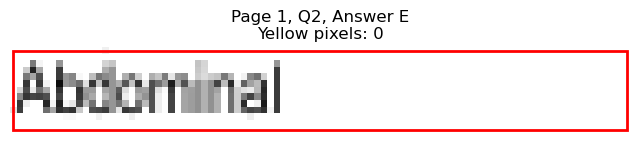


Page 1, Q2 - Selected Answer: C (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=85.0, y0=241.7, x1=123.7, y1=253.8
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 191
Page 1, Q3, A: Yellow percentage: 0.0%


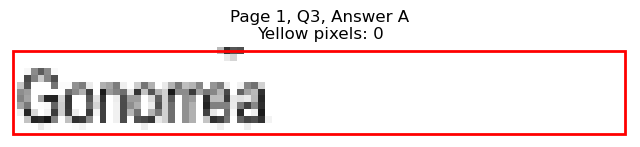

Page 1, Q3 - B: Detected box: x0=85.0, y0=253.7, x1=131.4, y1=265.8
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 244
Page 1, Q3, B: Yellow percentage: 0.0%


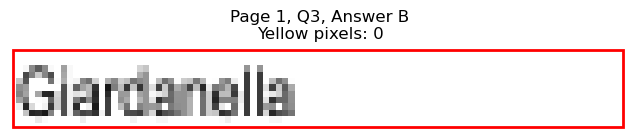

Page 1, Q3 - C: Detected box: x0=85.0, y0=265.8, x1=131.9, y1=277.9
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 252
Page 1, Q3, C: Yellow percentage: 0.0%


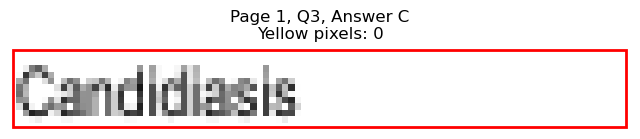

Page 1, Q3 - D: Detected box: x0=336.7, y0=241.7, x1=397.0, y1=253.8
Page 1, Q3, D: Yellow pixels: 1112
Page 1, Q3, D: Total non-white pixels: 1456
Page 1, Q3, D: Yellow percentage: 76.4%


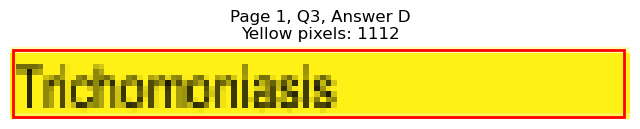

Page 1, Q3 - E: Detected box: x0=336.7, y0=253.7, x1=376.4, y1=265.8
Page 1, Q3, E: Yellow pixels: 91
Page 1, Q3, E: Total non-white pixels: 304
Page 1, Q3, E: Yellow percentage: 29.9%


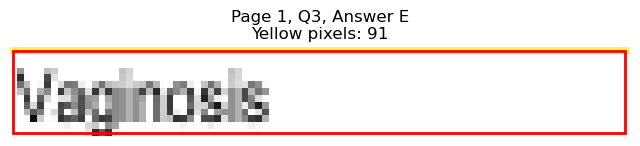


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=85.0, y0=326.1, x1=235.7, y1=338.2
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 748
Page 1, Q4, A: Yellow percentage: 0.0%


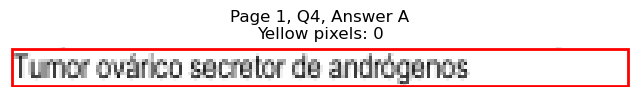

Page 1, Q4 - B: Detected box: x0=85.0, y0=338.1, x1=201.3, y1=350.2
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 627
Page 1, Q4, B: Yellow percentage: 0.0%


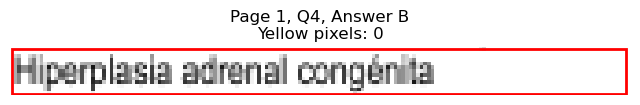

Page 1, Q4 - C: Detected box: x0=85.0, y0=350.2, x1=216.7, y1=362.3
Page 1, Q4, C: Yellow pixels: 1672
Page 1, Q4, C: Total non-white pixels: 2379
Page 1, Q4, C: Yellow percentage: 70.3%


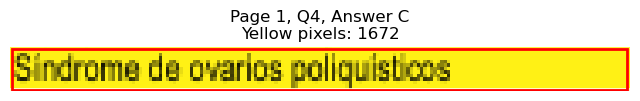

Page 1, Q4 - D: Detected box: x0=336.7, y0=326.1, x1=469.8, y1=338.2
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 713
Page 1, Q4, D: Yellow percentage: 0.0%


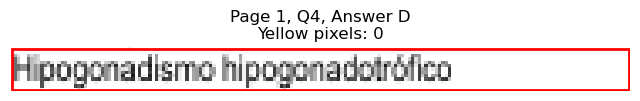

Page 1, Q4 - E: Detected box: x0=336.7, y0=338.1, x1=422.4, y1=350.2
Page 1, Q4, E: Yellow pixels: 0
Page 1, Q4, E: Total non-white pixels: 422
Page 1, Q4, E: Yellow percentage: 0.0%


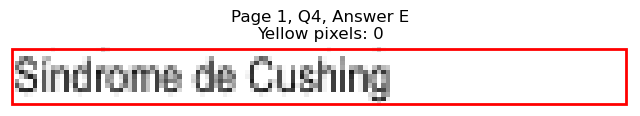


Page 1, Q4 - Selected Answer: C (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=85.0, y0=398.3, x1=134.3, y1=410.4
Page 1, Q5, A: Yellow pixels: 1106
Page 1, Q5, A: Total non-white pixels: 1313
Page 1, Q5, A: Yellow percentage: 84.2%


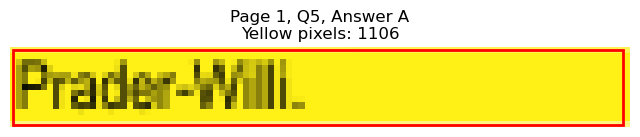

Page 1, Q5 - B: Detected box: x0=85.0, y0=410.4, x1=128.1, y1=422.5
Page 1, Q5, B: Yellow pixels: 95
Page 1, Q5, B: Total non-white pixels: 312
Page 1, Q5, B: Yellow percentage: 30.4%


Page 1, Q5 - C: Detected box: x0=85.0, y0=422.4, x1=115.1, y1=434.5
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 127
Page 1, Q5, C: Yellow percentage: 0.0%


Page 1, Q5 - D: Detected box: x0=336.7, y0=398.3, x1=363.4, y1=410.4
Page 1, Q5, D: Yellow pixels: 0
Page 1, Q5, D: Total non-white pixels: 122
Page 1, Q5, D: Yellow percentage: 0.0%


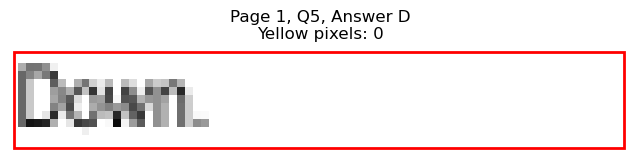

Page 1, Q5 - E: Detected box: x0=336.7, y0=410.4, x1=375.0, y1=422.5
Page 1, Q5, E: Yellow pixels: 0
Page 1, Q5, E: Total non-white pixels: 190
Page 1, Q5, E: Yellow percentage: 0.0%


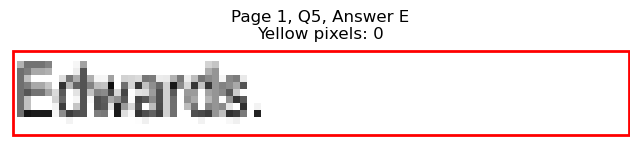


Page 1, Q5 - Selected Answer: A (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=85.0, y0=458.6, x1=176.9, y1=470.7
Page 1, Q6, A: Yellow pixels: 0
Page 1, Q6, A: Total non-white pixels: 455
Page 1, Q6, A: Yellow percentage: 0.0%


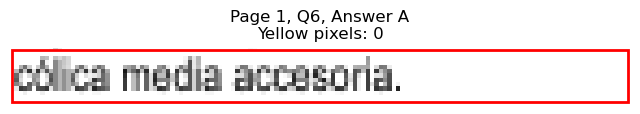

Page 1, Q6 - B: Detected box: x0=85.0, y0=470.7, x1=149.2, y1=482.8
Page 1, Q6, B: Yellow pixels: 0
Page 1, Q6, B: Total non-white pixels: 320
Page 1, Q6, B: Yellow percentage: 0.0%


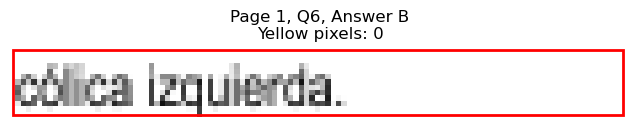

Page 1, Q6 - C: Detected box: x0=85.0, y0=482.7, x1=144.4, y1=494.8
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 399
Page 1, Q6, C: Yellow percentage: 0.0%


Page 1, Q6 - D: Detected box: x0=336.7, y0=458.6, x1=414.2, y1=470.7
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 395
Page 1, Q6, D: Yellow percentage: 0.0%


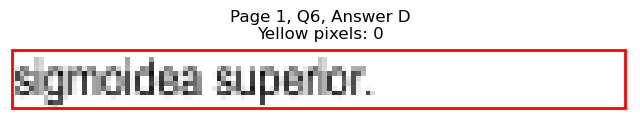

Page 1, Q6 - E: Detected box: x0=336.7, y0=470.7, x1=421.9, y1=482.8
Page 1, Q6, E: Yellow pixels: 1303
Page 1, Q6, E: Total non-white pixels: 1768
Page 1, Q6, E: Yellow percentage: 73.7%


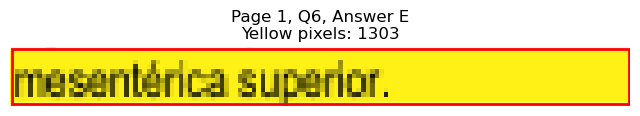


Page 1, Q6 - Selected Answer: E (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=85.0, y0=518.8, x1=155.8, y1=530.9
Page 1, Q7, A: Yellow pixels: 1184
Page 1, Q7, A: Total non-white pixels: 1586
Page 1, Q7, A: Yellow percentage: 74.7%


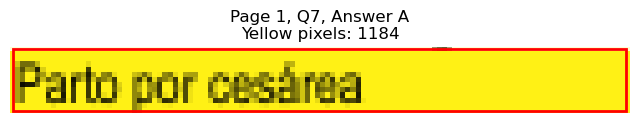

Page 1, Q7 - B: Detected box: x0=85.0, y0=530.9, x1=196.1, y1=543.0
Page 1, Q7, B: Yellow pixels: 161
Page 1, Q7, B: Total non-white pixels: 709
Page 1, Q7, B: Yellow percentage: 22.7%


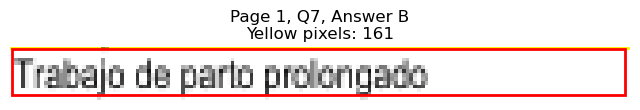

Page 1, Q7 - C: Detected box: x0=85.0, y0=542.9, x1=194.2, y1=555.0
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 585
Page 1, Q7, C: Yellow percentage: 0.0%


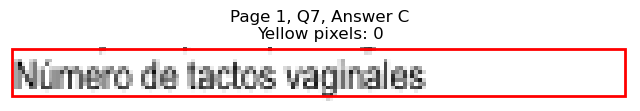

Page 1, Q7 - D: Detected box: x0=336.7, y0=518.8, x1=404.2, y1=530.9
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 331
Page 1, Q7, D: Yellow percentage: 0.0%


Page 1, Q7 - E: Detected box: x0=336.7, y0=530.9, x1=375.9, y1=543.0
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 210
Page 1, Q7, E: Yellow percentage: 0.0%



Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=85.0, y0=579.1, x1=166.8, y1=591.2
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 446
Page 1, Q8, A: Yellow percentage: 0.0%


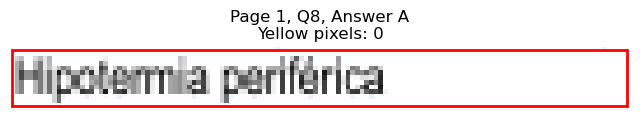

Page 1, Q8 - B: Detected box: x0=85.0, y0=591.2, x1=136.2, y1=603.3
Page 1, Q8, B: Yellow pixels: 103
Page 1, Q8, B: Total non-white pixels: 396
Page 1, Q8, B: Yellow percentage: 26.0%


Page 1, Q8 - C: Detected box: x0=85.0, y0=603.2, x1=172.1, y1=615.3
Page 1, Q8, C: Yellow pixels: 1302
Page 1, Q8, C: Total non-white pixels: 1807
Page 1, Q8, C: Yellow percentage: 72.1%


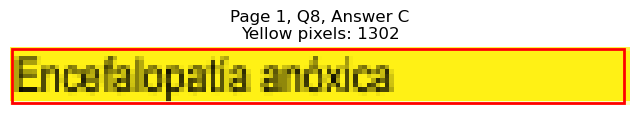

Page 1, Q8 - D: Detected box: x0=336.7, y0=579.1, x1=412.3, y1=591.2
Page 1, Q8, D: Yellow pixels: 0
Page 1, Q8, D: Total non-white pixels: 386
Page 1, Q8, D: Yellow percentage: 0.0%


Page 1, Q8 - E: Detected box: x0=336.7, y0=591.2, x1=430.0, y1=603.3
Page 1, Q8, E: Yellow pixels: 0
Page 1, Q8, E: Total non-white pixels: 511
Page 1, Q8, E: Yellow percentage: 0.0%


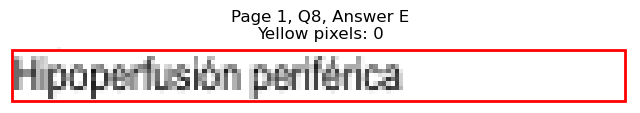


Page 1, Q8 - Selected Answer: C (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=85.0, y0=687.5, x1=153.5, y1=699.7
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 351
Page 1, Q9, A: Yellow percentage: 0.0%


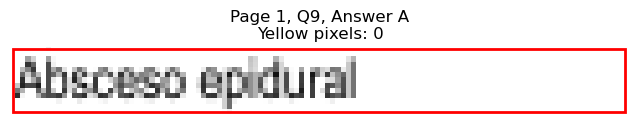

Page 1, Q9 - B: Detected box: x0=85.0, y0=699.5, x1=188.9, y1=711.7
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 549
Page 1, Q9, B: Yellow percentage: 0.0%


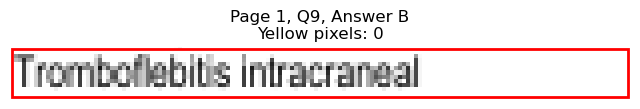

Page 1, Q9 - C: Detected box: x0=85.0, y0=711.7, x1=205.6, y1=723.8
Page 1, Q9, C: Yellow pixels: 0
Page 1, Q9, C: Total non-white pixels: 660
Page 1, Q9, C: Yellow percentage: 0.0%


Page 1, Q9 - D: Detected box: x0=336.7, y0=687.5, x1=428.6, y1=699.7
Page 1, Q9, D: Yellow pixels: 1486
Page 1, Q9, D: Total non-white pixels: 1859
Page 1, Q9, D: Yellow percentage: 79.9%


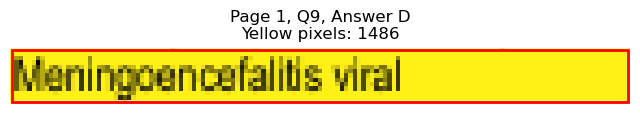

Page 1, Q9 - E: Detected box: x0=336.7, y0=699.5, x1=453.0, y1=711.7
Page 1, Q9, E: Yellow pixels: 167
Page 1, Q9, E: Total non-white pixels: 790
Page 1, Q9, E: Yellow percentage: 21.1%


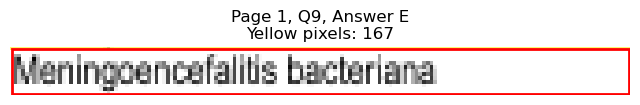


Page 1, Q9 - Selected Answer: D (based on yellow pixel count)





Page 2: Found 10 questions
Page 2, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=157.7, y1=133.3
Page 2, Q1, A: Yellow pixels: 1196
Page 2, Q1, A: Total non-white pixels: 1612
Page 2, Q1, A: Yellow percentage: 74.2%


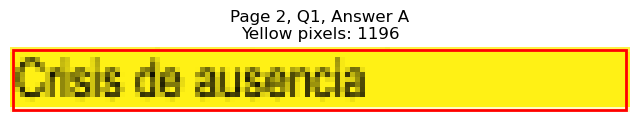

Page 2, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=191.8, y1=145.3
Page 2, Q1, B: Yellow pixels: 0
Page 2, Q1, B: Total non-white pixels: 691
Page 2, Q1, B: Yellow percentage: 0.0%


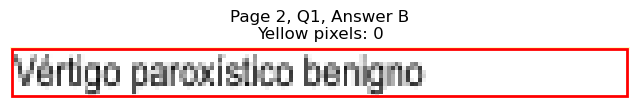

Page 2, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=118.9, y1=157.4
Page 2, Q1, C: Yellow pixels: 0
Page 2, Q1, C: Total non-white pixels: 183
Page 2, Q1, C: Yellow percentage: 0.0%


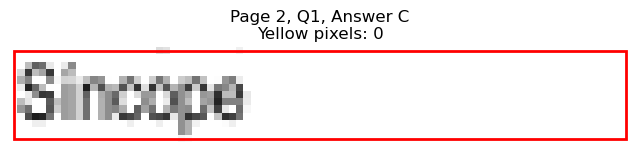

Page 2, Q1 - D: Detected box: x0=336.7, y0=121.2, x1=362.5, y1=133.3
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 124
Page 2, Q1, D: Yellow percentage: 0.0%


Page 2, Q1 - E: Detected box: x0=336.7, y0=133.2, x1=465.5, y1=145.3
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 640
Page 2, Q1, E: Yellow percentage: 0.0%


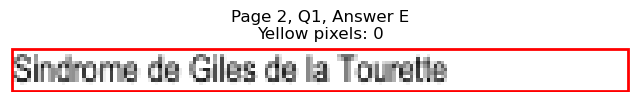


Page 2, Q1 - Selected Answer: A (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=85.0, y0=193.4, x1=132.9, y1=205.5
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 237
Page 2, Q2, A: Yellow percentage: 0.0%


Page 2, Q2 - B: Detected box: x0=85.0, y0=205.5, x1=151.5, y1=217.7
Page 2, Q2, B: Yellow pixels: 118
Page 2, Q2, B: Total non-white pixels: 471
Page 2, Q2, B: Yellow percentage: 25.1%


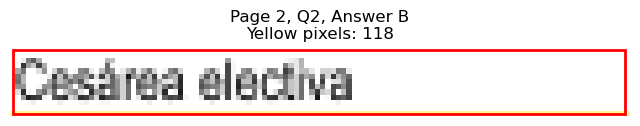

Page 2, Q2 - C: Detected box: x0=85.0, y0=217.5, x1=163.9, y1=229.7
Page 2, Q2, C: Yellow pixels: 1373
Page 2, Q2, C: Total non-white pixels: 1690
Page 2, Q2, C: Yellow percentage: 81.2%


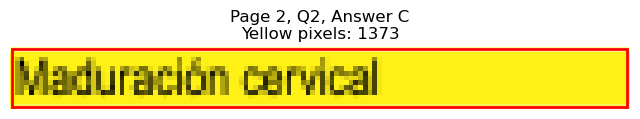

Page 2, Q2 - D: Detected box: x0=336.7, y0=193.4, x1=450.6, y1=205.5
Page 2, Q2, D: Yellow pixels: 0
Page 2, Q2, D: Total non-white pixels: 564
Page 2, Q2, D: Yellow percentage: 0.0%


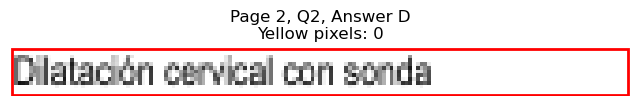

Page 2, Q2 - E: Detected box: x0=336.7, y0=205.5, x1=428.6, y1=217.7
Page 2, Q2, E: Yellow pixels: 0
Page 2, Q2, E: Total non-white pixels: 440
Page 2, Q2, E: Yellow percentage: 0.0%


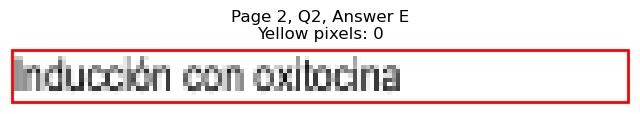


Page 2, Q2 - Selected Answer: C (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=85.0, y0=265.8, x1=221.0, y1=277.9
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 672
Page 2, Q3, A: Yellow percentage: 0.0%


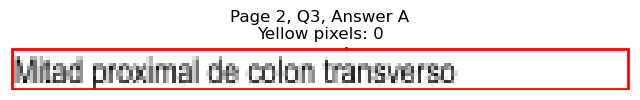

Page 2, Q3 - B: Detected box: x0=85.0, y0=277.8, x1=226.7, y1=289.9
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 689
Page 2, Q3, B: Yellow percentage: 0.0%


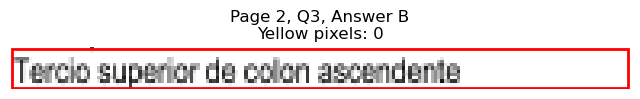

Page 2, Q3 - C: Detected box: x0=85.0, y0=289.9, x1=175.5, y1=302.0
Page 2, Q3, C: Yellow pixels: 1328
Page 2, Q3, C: Total non-white pixels: 1846
Page 2, Q3, C: Yellow percentage: 71.9%


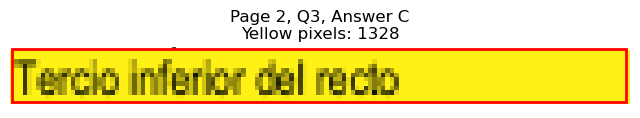

Page 2, Q3 - D: Detected box: x0=336.7, y0=265.8, x1=429.2, y1=277.9
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 468
Page 2, Q3, D: Yellow percentage: 0.0%


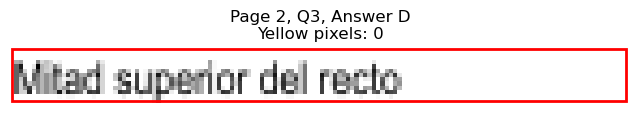

Page 2, Q3 - E: Detected box: x0=336.7, y0=277.8, x1=402.3, y1=289.9
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 341
Page 2, Q3, E: Yellow percentage: 0.0%


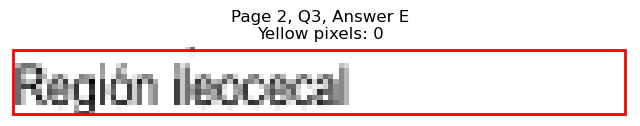


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=85.0, y0=326.1, x1=224.8, y1=338.2
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 732
Page 2, Q4, A: Yellow percentage: 0.0%


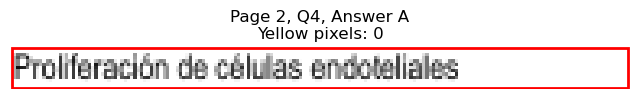

Page 2, Q4 - B: Detected box: x0=85.0, y0=338.1, x1=201.3, y1=350.2
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 614
Page 2, Q4, B: Yellow percentage: 0.0%


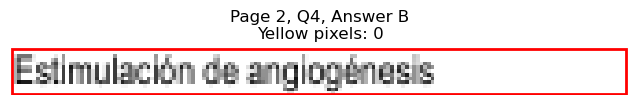

Page 2, Q4 - C: Detected box: x0=85.0, y0=350.2, x1=193.7, y1=362.3
Page 2, Q4, C: Yellow pixels: 160
Page 2, Q4, C: Total non-white pixels: 724
Page 2, Q4, C: Yellow percentage: 22.1%


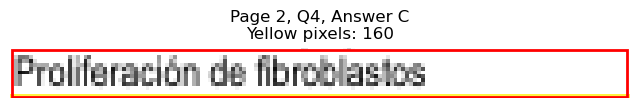

Page 2, Q4 - D: Detected box: x0=336.7, y0=326.1, x1=463.5, y1=338.2
Page 2, Q4, D: Yellow pixels: 178
Page 2, Q4, D: Total non-white pixels: 840
Page 2, Q4, D: Yellow percentage: 21.2%


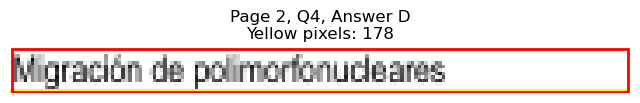

Page 2, Q4 - E: Detected box: x0=336.7, y0=338.1, x1=493.7, y1=350.2
Page 2, Q4, E: Yellow pixels: 1608
Page 2, Q4, E: Total non-white pixels: 2470
Page 2, Q4, E: Yellow percentage: 65.1%


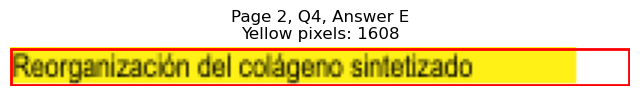


Page 2, Q4 - Selected Answer: E (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=85.0, y0=386.3, x1=97.0, y1=398.4
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 54
Page 2, Q5, A: Yellow percentage: 0.0%


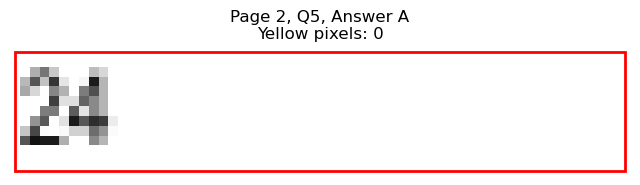

Page 2, Q5 - B: Detected box: x0=70.8, y0=398.3, x1=79.0, y1=410.4
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 73
Page 2, Q5, B: Yellow percentage: 0.0%


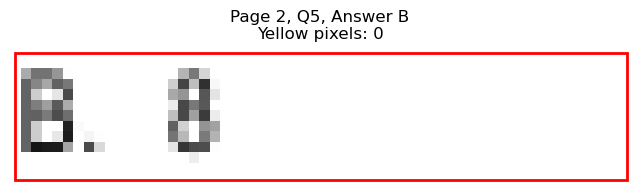

Page 2, Q5 - C: Detected box: x0=85.0, y0=410.4, x1=97.0, y1=422.5
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 44
Page 2, Q5, C: Yellow percentage: 0.0%


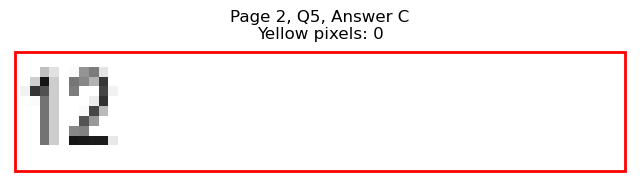

Page 2, Q5 - D: Detected box: x0=322.5, y0=386.3, x1=331.2, y1=398.4
Page 2, Q5, D: Yellow pixels: 670
Page 2, Q5, D: Total non-white pixels: 780
Page 2, Q5, D: Yellow percentage: 85.9%


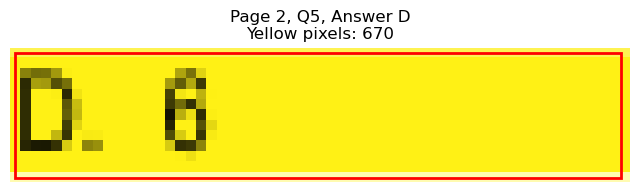

Page 2, Q5 - E: Detected box: x0=336.7, y0=398.3, x1=348.7, y1=410.4
Page 2, Q5, E: Yellow pixels: 0
Page 2, Q5, E: Total non-white pixels: 122
Page 2, Q5, E: Yellow percentage: 0.0%


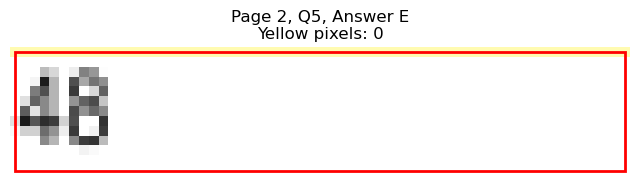


Page 2, Q5 - Selected Answer: D (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=85.0, y0=470.7, x1=133.3, y1=482.8
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 348
Page 2, Q6, A: Yellow percentage: 0.0%


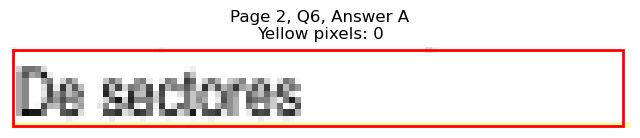

Page 2, Q6 - B: Detected box: x0=85.0, y0=482.7, x1=140.1, y1=494.8
Page 2, Q6, B: Yellow pixels: 1039
Page 2, Q6, B: Total non-white pixels: 1391
Page 2, Q6, B: Yellow percentage: 74.7%


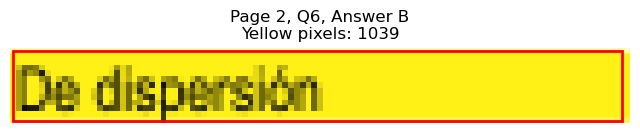

Page 2, Q6 - C: Detected box: x0=85.0, y0=494.7, x1=131.4, y1=506.8
Page 2, Q6, C: Yellow pixels: 97
Page 2, Q6, C: Total non-white pixels: 338
Page 2, Q6, C: Yellow percentage: 28.7%


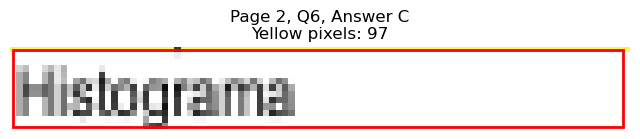

Page 2, Q6 - D: Detected box: x0=336.7, y0=470.7, x1=376.9, y1=482.8
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 196
Page 2, Q6, D: Yellow percentage: 0.0%


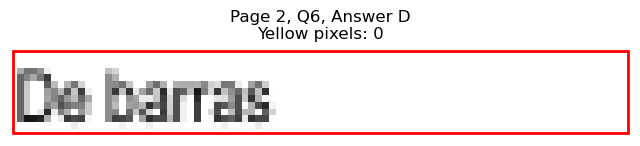

Page 2, Q6 - E: Detected box: x0=336.7, y0=482.7, x1=398.0, y1=494.8
Page 2, Q6, E: Yellow pixels: 0
Page 2, Q6, E: Total non-white pixels: 309
Page 2, Q6, E: Yellow percentage: 0.0%


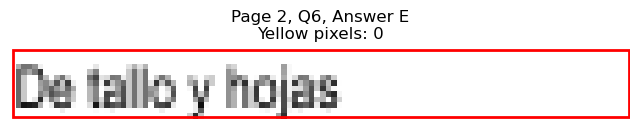


Page 2, Q6 - Selected Answer: B (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=85.0, y0=542.9, x1=166.8, y1=555.0
Page 2, Q7, A: Yellow pixels: 1238
Page 2, Q7, A: Total non-white pixels: 1731
Page 2, Q7, A: Yellow percentage: 71.5%


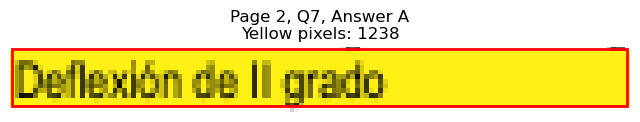

Page 2, Q7 - B: Detected box: x0=85.0, y0=554.9, x1=182.7, y1=567.0
Page 2, Q7, B: Yellow pixels: 145
Page 2, Q7, B: Total non-white pixels: 666
Page 2, Q7, B: Yellow percentage: 21.8%


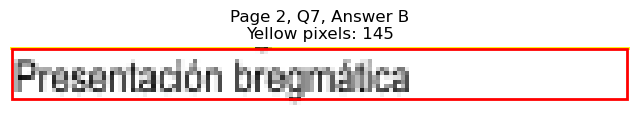

Page 2, Q7 - C: Detected box: x0=85.0, y0=567.1, x1=164.4, y1=579.2
Page 2, Q7, C: Yellow pixels: 0
Page 2, Q7, C: Total non-white pixels: 399
Page 2, Q7, C: Yellow percentage: 0.0%


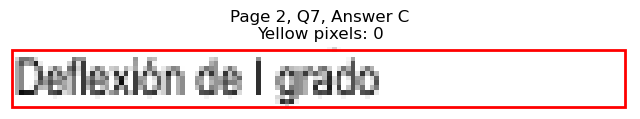

Page 2, Q7 - D: Detected box: x0=336.7, y0=542.9, x1=420.9, y1=555.0
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 440
Page 2, Q7, D: Yellow percentage: 0.0%


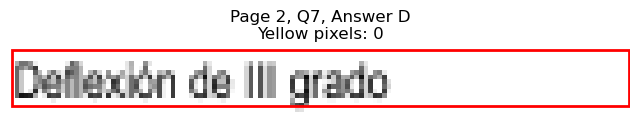

Page 2, Q7 - E: Detected box: x0=336.7, y0=554.9, x1=433.9, y1=567.0
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 489
Page 2, Q7, E: Yellow percentage: 0.0%


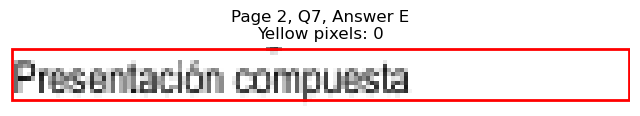


Page 2, Q7 - Selected Answer: A (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=85.0, y0=603.2, x1=104.2, y1=615.3
Page 2, Q8, A: Yellow pixels: 71
Page 2, Q8, A: Total non-white pixels: 165
Page 2, Q8, A: Yellow percentage: 43.0%


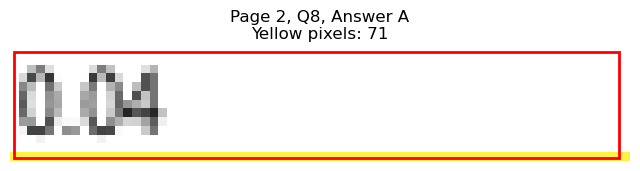

Page 2, Q8 - B: Detected box: x0=85.0, y0=615.2, x1=104.2, y1=627.3
Page 2, Q8, B: Yellow pixels: 771
Page 2, Q8, B: Total non-white pixels: 923
Page 2, Q8, B: Yellow percentage: 83.5%


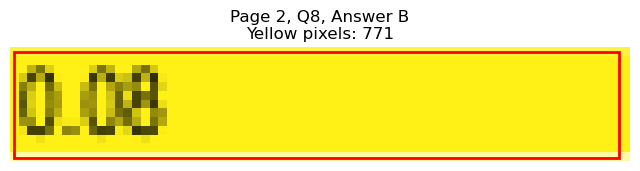

Page 2, Q8 - C: Detected box: x0=85.0, y0=627.3, x1=104.2, y1=639.4
Page 2, Q8, C: Yellow pixels: 0
Page 2, Q8, C: Total non-white pixels: 172
Page 2, Q8, C: Yellow percentage: 0.0%


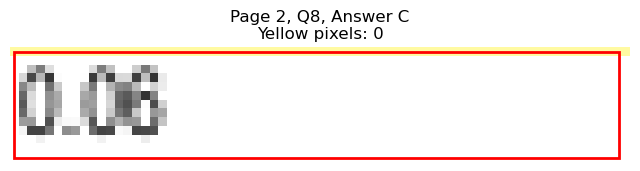

Page 2, Q8 - D: Detected box: x0=336.7, y0=603.2, x1=355.9, y1=615.3
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 92
Page 2, Q8, D: Yellow percentage: 0.0%


Page 2, Q8 - E: Detected box: x0=336.7, y0=615.2, x1=355.9, y1=627.3
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 78
Page 2, Q8, E: Yellow percentage: 0.0%



Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=85.0, y0=663.4, x1=149.7, y1=675.5
Page 2, Q9, A: Yellow pixels: 1221
Page 2, Q9, A: Total non-white pixels: 1508
Page 2, Q9, A: Yellow percentage: 81.0%


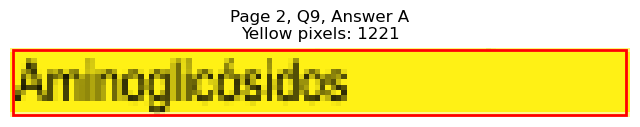

Page 2, Q9 - B: Detected box: x0=85.0, y0=675.4, x1=139.6, y1=687.5
Page 2, Q9, B: Yellow pixels: 106
Page 2, Q9, B: Total non-white pixels: 381
Page 2, Q9, B: Yellow percentage: 27.8%


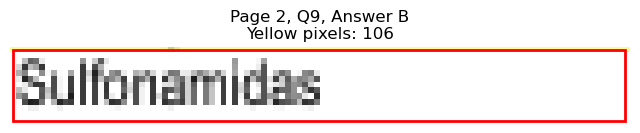

Page 2, Q9 - C: Detected box: x0=85.0, y0=687.5, x1=144.9, y1=699.7
Page 2, Q9, C: Yellow pixels: 0
Page 2, Q9, C: Total non-white pixels: 326
Page 2, Q9, C: Yellow percentage: 0.0%


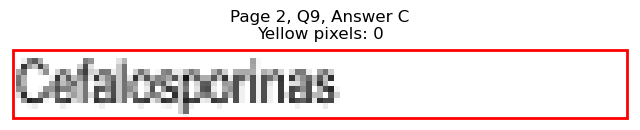

Page 2, Q9 - D: Detected box: x0=336.7, y0=663.4, x1=404.1, y1=675.5
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 344
Page 2, Q9, D: Yellow percentage: 0.0%


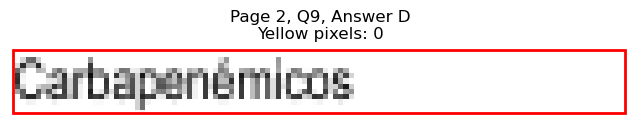

Page 2, Q9 - E: Detected box: x0=336.7, y0=675.4, x1=382.6, y1=687.5
Page 2, Q9, E: Yellow pixels: 0
Page 2, Q9, E: Total non-white pixels: 236
Page 2, Q9, E: Yellow percentage: 0.0%


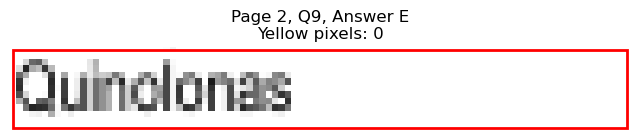


Page 2, Q9 - Selected Answer: A (based on yellow pixel count)




Page 2, Q10 - A: Detected box: x0=70.8, y0=747.8, x1=79.0, y1=759.9
Page 2, Q10, A: Yellow pixels: 0
Page 2, Q10, A: Total non-white pixels: 64
Page 2, Q10, A: Yellow percentage: 0.0%


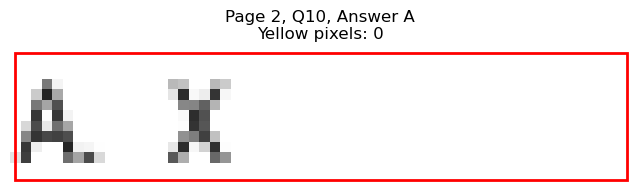

Page 2, Q10 - B: Detected box: x0=70.8, y0=759.8, x1=79.0, y1=771.9
Page 2, Q10, B: Yellow pixels: 0
Page 2, Q10, B: Total non-white pixels: 67
Page 2, Q10, B: Yellow percentage: 0.0%


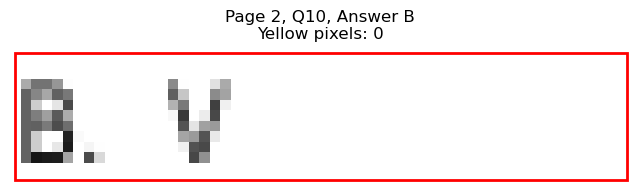

Page 2, Q10 - C: Detected box: x0=85.0, y0=771.9, x1=95.6, y1=784.0
Page 2, Q10, C: Yellow pixels: 0
Page 2, Q10, C: Total non-white pixels: 44
Page 2, Q10, C: Yellow percentage: 0.0%


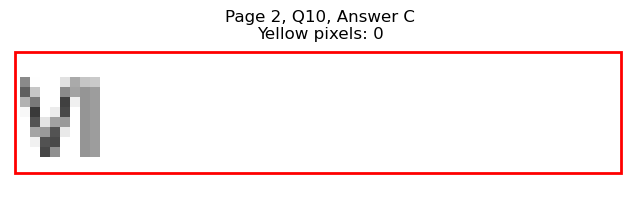

Page 2, Q10 - D: Detected box: x0=336.7, y0=747.8, x1=352.0, y1=759.9
Page 2, Q10, D: Yellow pixels: 0
Page 2, Q10, D: Total non-white pixels: 146
Page 2, Q10, D: Yellow percentage: 0.0%


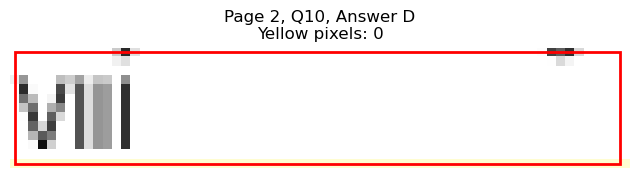

Page 2, Q10 - E: Detected box: x0=336.7, y0=759.8, x1=349.6, y1=771.9
Page 2, Q10, E: Yellow pixels: 723
Page 2, Q10, E: Total non-white pixels: 832
Page 2, Q10, E: Yellow percentage: 86.9%


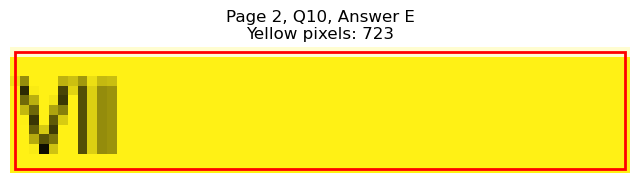


Page 2, Q10 - Selected Answer: E (based on yellow pixel count)





Page 3: Found 8 questions
Page 3, Q1 - A: Detected box: x0=85.0, y0=145.3, x1=191.8, y1=157.4
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 550
Page 3, Q1, A: Yellow percentage: 0.0%


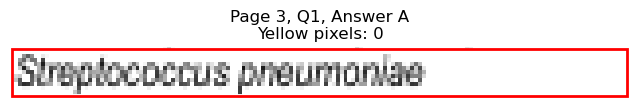

Page 3, Q1 - B: Detected box: x0=85.0, y0=157.3, x1=156.7, y1=169.4
Page 3, Q1, B: Yellow pixels: 0
Page 3, Q1, B: Total non-white pixels: 378
Page 3, Q1, B: Yellow percentage: 0.0%


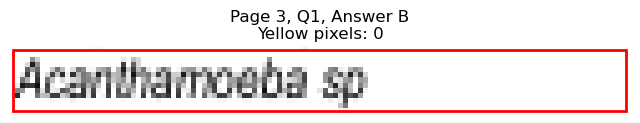

Page 3, Q1 - C: Detected box: x0=85.0, y0=169.4, x1=151.5, y1=181.5
Page 3, Q1, C: Yellow pixels: 1248
Page 3, Q1, C: Total non-white pixels: 1534
Page 3, Q1, C: Yellow percentage: 81.4%


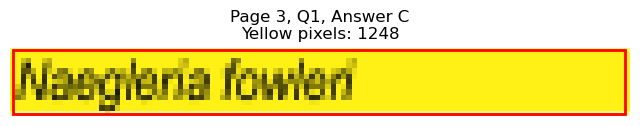

Page 3, Q1 - D: Detected box: x0=336.7, y0=145.3, x1=422.8, y1=157.4
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 463
Page 3, Q1, D: Yellow percentage: 0.0%


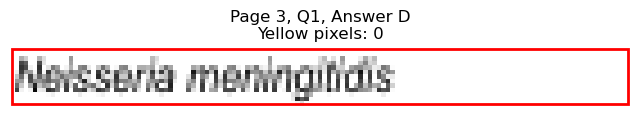

Page 3, Q1 - E: Detected box: x0=336.7, y0=157.3, x1=439.2, y1=169.4
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 509
Page 3, Q1, E: Yellow percentage: 0.0%


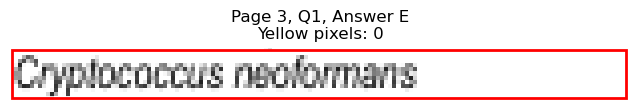


Page 3, Q1 - Selected Answer: C (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=85.0, y0=205.5, x1=133.8, y1=217.7
Page 3, Q2, A: Yellow pixels: 1079
Page 3, Q2, A: Total non-white pixels: 1300
Page 3, Q2, A: Yellow percentage: 83.0%


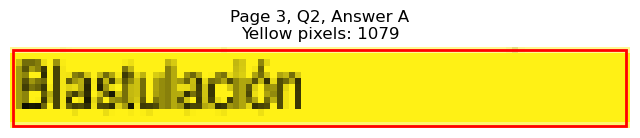

Page 3, Q2 - B: Detected box: x0=85.0, y0=217.5, x1=136.7, y1=229.7
Page 3, Q2, B: Yellow pixels: 103
Page 3, Q2, B: Total non-white pixels: 389
Page 3, Q2, B: Yellow percentage: 26.5%


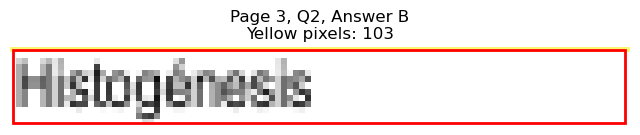

Page 3, Q2 - C: Detected box: x0=85.0, y0=229.7, x1=142.6, y1=241.8
Page 3, Q2, C: Yellow pixels: 0
Page 3, Q2, C: Total non-white pixels: 303
Page 3, Q2, C: Yellow percentage: 0.0%


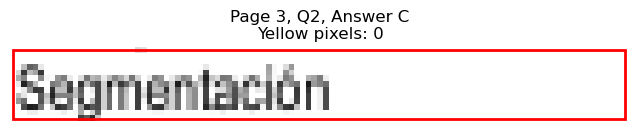

Page 3, Q2 - D: Detected box: x0=336.7, y0=205.5, x1=387.4, y1=217.7
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 256
Page 3, Q2, D: Yellow percentage: 0.0%


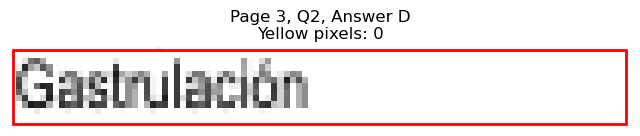

Page 3, Q2 - E: Detected box: x0=336.7, y0=217.5, x1=399.4, y1=229.7
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 343
Page 3, Q2, E: Yellow percentage: 0.0%


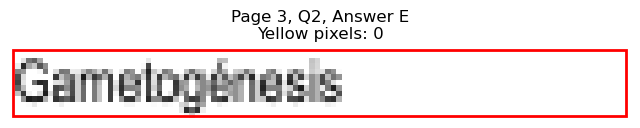


Page 3, Q2 - Selected Answer: A (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=85.0, y0=265.8, x1=195.1, y1=277.9
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 726
Page 3, Q3, A: Yellow percentage: 0.0%


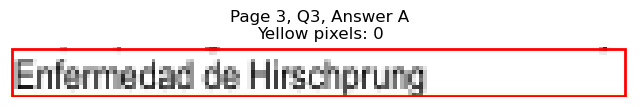

Page 3, Q3 - B: Detected box: x0=85.0, y0=277.8, x1=174.0, y1=289.9
Page 3, Q3, B: Yellow pixels: 1335
Page 3, Q3, B: Total non-white pixels: 1833
Page 3, Q3, B: Yellow percentage: 72.8%


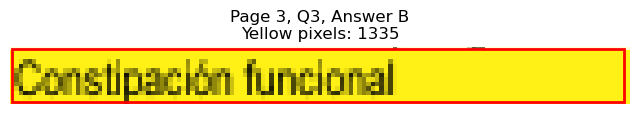

Page 3, Q3 - C: Detected box: x0=85.0, y0=289.9, x1=130.0, y1=302.0
Page 3, Q3, C: Yellow pixels: 95
Page 3, Q3, C: Total non-white pixels: 327
Page 3, Q3, C: Yellow percentage: 29.1%


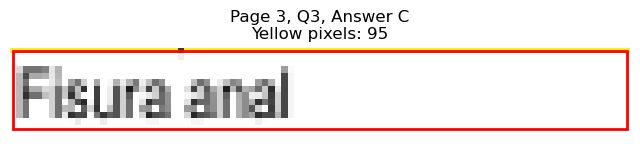

Page 3, Q3 - D: Detected box: x0=336.7, y0=265.8, x1=401.4, y1=277.9
Page 3, Q3, D: Yellow pixels: 0
Page 3, Q3, D: Total non-white pixels: 346
Page 3, Q3, D: Yellow percentage: 0.0%


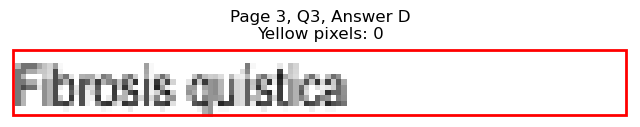

Page 3, Q3 - E: Detected box: x0=336.7, y0=277.8, x1=393.7, y1=289.9
Page 3, Q3, E: Yellow pixels: 0
Page 3, Q3, E: Total non-white pixels: 302
Page 3, Q3, E: Yellow percentage: 0.0%


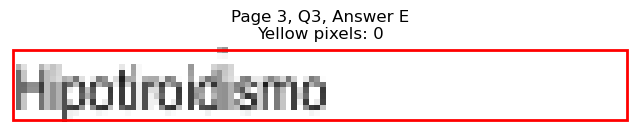


Page 3, Q3 - Selected Answer: B (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=70.8, y0=338.1, x1=79.0, y1=350.2
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 57
Page 3, Q4, A: Yellow percentage: 0.0%


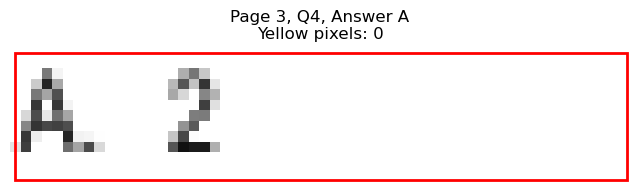

Page 3, Q4 - B: Detected box: x0=70.8, y0=350.2, x1=79.0, y1=362.3
Page 3, Q4, B: Yellow pixels: 650
Page 3, Q4, B: Total non-white pixels: 767
Page 3, Q4, B: Yellow percentage: 84.7%


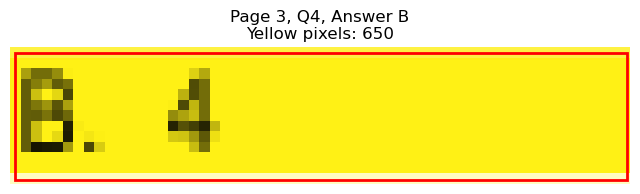

Page 3, Q4 - C: Detected box: x0=70.8, y0=362.2, x1=79.5, y1=374.3
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 128
Page 3, Q4, C: Yellow percentage: 0.0%


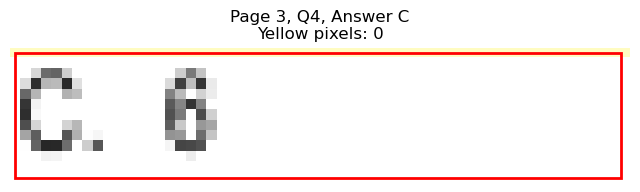

Page 3, Q4 - D: Detected box: x0=322.5, y0=338.1, x1=331.2, y1=350.2
Page 3, Q4, D: Yellow pixels: 0
Page 3, Q4, D: Total non-white pixels: 62
Page 3, Q4, D: Yellow percentage: 0.0%


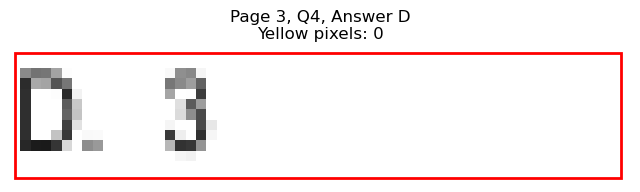

Page 3, Q4 - E: Detected box: x0=322.5, y0=350.2, x1=330.7, y1=362.3
Page 3, Q4, E: Yellow pixels: 0
Page 3, Q4, E: Total non-white pixels: 42
Page 3, Q4, E: Yellow percentage: 0.0%


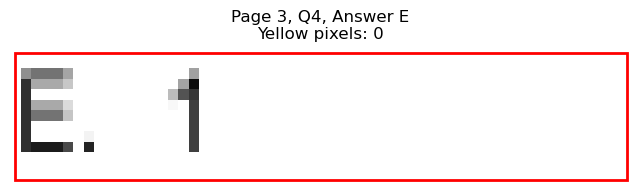


Page 3, Q4 - Selected Answer: B (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=85.0, y0=422.4, x1=110.8, y1=434.5
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 131
Page 3, Q5, A: Yellow percentage: 0.0%


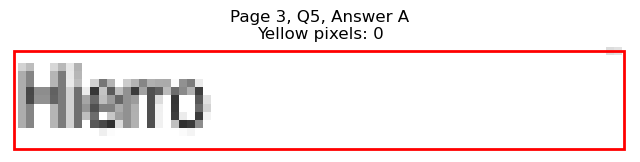

Page 3, Q5 - B: Detected box: x0=85.0, y0=434.4, x1=118.0, y1=446.5
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 171
Page 3, Q5, B: Yellow percentage: 0.0%


Page 3, Q5 - C: Detected box: x0=85.0, y0=446.6, x1=133.3, y1=458.7
Page 3, Q5, C: Yellow pixels: 0
Page 3, Q5, C: Total non-white pixels: 244
Page 3, Q5, C: Yellow percentage: 0.0%


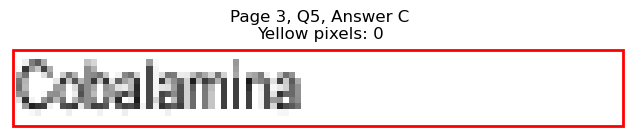

Page 3, Q5 - D: Detected box: x0=336.7, y0=422.4, x1=355.4, y1=434.5
Page 3, Q5, D: Yellow pixels: 843
Page 3, Q5, D: Total non-white pixels: 910
Page 3, Q5, D: Yellow percentage: 92.6%


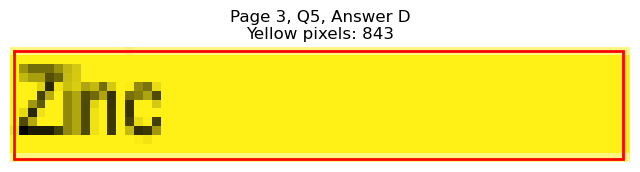

Page 3, Q5 - E: Detected box: x0=336.7, y0=434.4, x1=380.7, y1=446.5
Page 3, Q5, E: Yellow pixels: 95
Page 3, Q5, E: Total non-white pixels: 297
Page 3, Q5, E: Yellow percentage: 32.0%


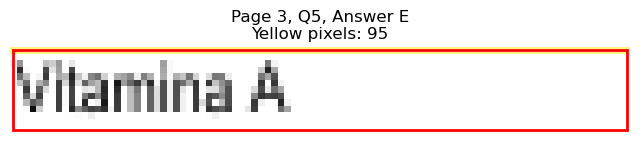


Page 3, Q5 - Selected Answer: D (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=85.0, y0=518.8, x1=106.6, y1=530.9
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 109
Page 3, Q6, A: Yellow percentage: 0.0%


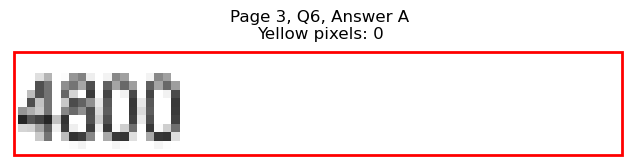

Page 3, Q6 - B: Detected box: x0=85.0, y0=530.9, x1=106.6, y1=543.0
Page 3, Q6, B: Yellow pixels: 788
Page 3, Q6, B: Total non-white pixels: 949
Page 3, Q6, B: Yellow percentage: 83.0%


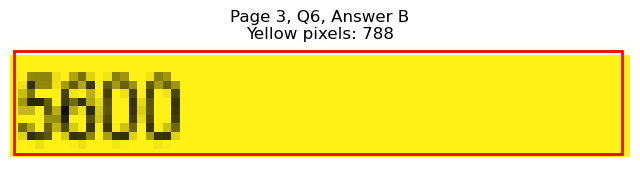

Page 3, Q6 - C: Detected box: x0=85.0, y0=542.9, x1=106.6, y1=555.0
Page 3, Q6, C: Yellow pixels: 73
Page 3, Q6, C: Total non-white pixels: 182
Page 3, Q6, C: Yellow percentage: 40.1%


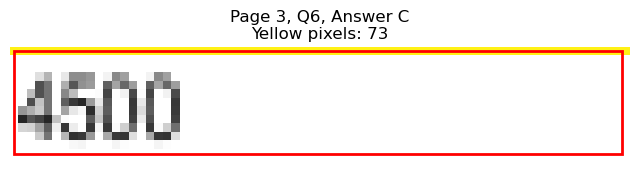

Page 3, Q6 - D: Detected box: x0=336.7, y0=518.8, x1=358.3, y1=530.9
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 125
Page 3, Q6, D: Yellow percentage: 0.0%


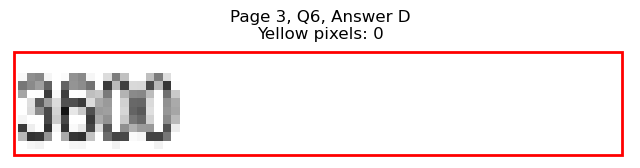

Page 3, Q6 - E: Detected box: x0=336.7, y0=530.9, x1=358.3, y1=543.0
Page 3, Q6, E: Yellow pixels: 0
Page 3, Q6, E: Total non-white pixels: 120
Page 3, Q6, E: Yellow percentage: 0.0%



Page 3, Q6 - Selected Answer: B (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=85.0, y0=603.2, x1=125.7, y1=615.3
Page 3, Q7, A: Yellow pixels: 92
Page 3, Q7, A: Total non-white pixels: 293
Page 3, Q7, A: Yellow percentage: 31.4%


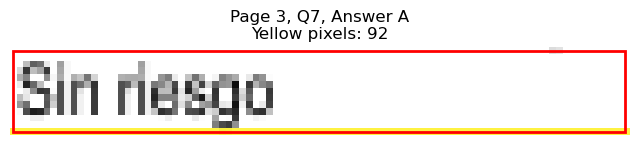

Page 3, Q7 - B: Detected box: x0=85.0, y0=615.2, x1=128.1, y1=627.3
Page 3, Q7, B: Yellow pixels: 955
Page 3, Q7, B: Total non-white pixels: 1235
Page 3, Q7, B: Yellow percentage: 77.3%


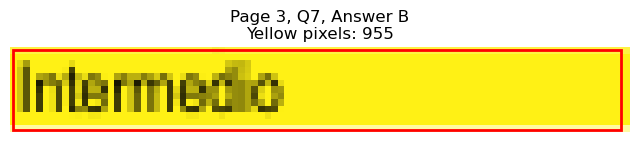

Page 3, Q7 - C: Detected box: x0=85.0, y0=627.3, x1=102.3, y1=639.4
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 155
Page 3, Q7, C: Yellow percentage: 0.0%


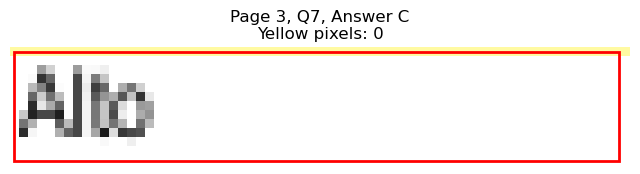

Page 3, Q7 - D: Detected box: x0=336.7, y0=603.2, x1=356.4, y1=615.3
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 109
Page 3, Q7, D: Yellow percentage: 0.0%


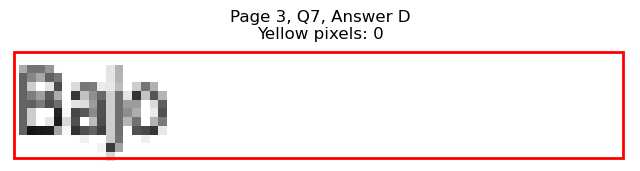

Page 3, Q7 - E: Detected box: x0=336.7, y0=615.2, x1=400.4, y1=627.3
Page 3, Q7, E: Yellow pixels: 0
Page 3, Q7, E: Total non-white pixels: 326
Page 3, Q7, E: Yellow percentage: 0.0%


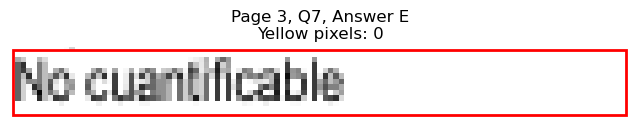


Page 3, Q7 - Selected Answer: B (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=85.0, y0=663.4, x1=93.6, y1=675.5
Page 3, Q8, A: Yellow pixels: 60
Page 3, Q8, A: Total non-white pixels: 98
Page 3, Q8, A: Yellow percentage: 61.2%


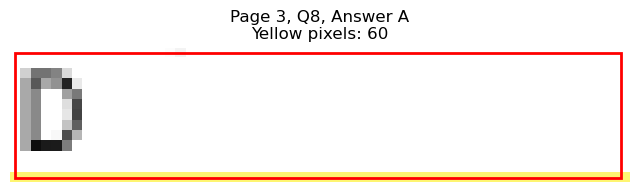

Page 3, Q8 - B: Detected box: x0=70.8, y0=675.4, x1=79.0, y1=687.5
Page 3, Q8, B: Yellow pixels: 701
Page 3, Q8, B: Total non-white pixels: 767
Page 3, Q8, B: Yellow percentage: 91.4%


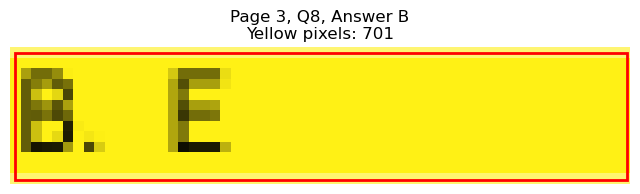

Page 3, Q8 - C: Detected box: x0=70.8, y0=687.5, x1=79.5, y1=699.7
Page 3, Q8, C: Yellow pixels: 60
Page 3, Q8, C: Total non-white pixels: 123
Page 3, Q8, C: Yellow percentage: 48.8%


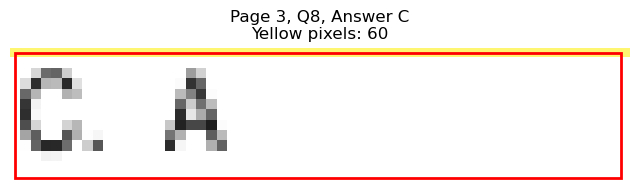

Page 3, Q8 - D: Detected box: x0=336.7, y0=663.4, x1=345.8, y1=675.5
Page 3, Q8, D: Yellow pixels: 0
Page 3, Q8, D: Total non-white pixels: 36
Page 3, Q8, D: Yellow percentage: 0.0%


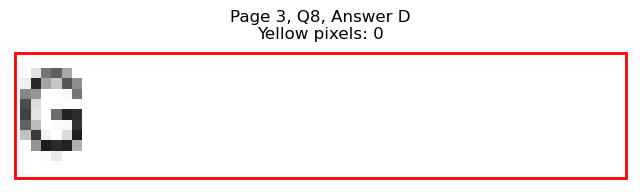

Page 3, Q8 - E: Detected box: x0=336.7, y0=675.4, x1=346.3, y1=687.5
Page 3, Q8, E: Yellow pixels: 0
Page 3, Q8, E: Total non-white pixels: 47
Page 3, Q8, E: Yellow percentage: 0.0%


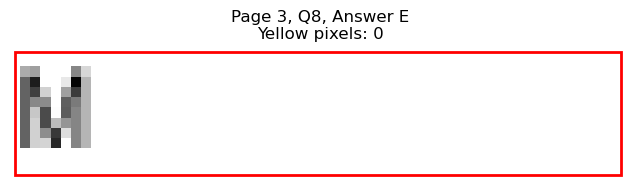


Page 3, Q8 - Selected Answer: B (based on yellow pixel count)





Page 4: Found 8 questions
Page 4, Q1 - A: Detected box: x0=85.0, y0=145.3, x1=221.0, y1=157.4
Page 4, Q1, A: Yellow pixels: 1683
Page 4, Q1, A: Total non-white pixels: 2431
Page 4, Q1, A: Yellow percentage: 69.2%


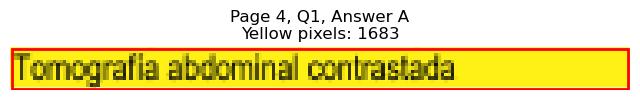

Page 4, Q1 - B: Detected box: x0=85.0, y0=157.3, x1=211.4, y1=169.4
Page 4, Q1, B: Yellow pixels: 2
Page 4, Q1, B: Total non-white pixels: 818
Page 4, Q1, B: Yellow percentage: 0.2%


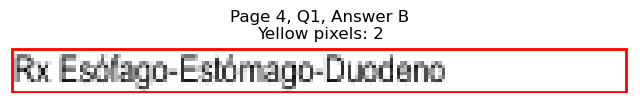

Page 4, Q1 - C: Detected box: x0=85.0, y0=169.4, x1=182.2, y1=181.5
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 496
Page 4, Q1, C: Yellow percentage: 0.0%


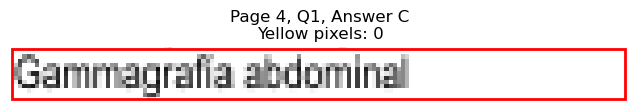

Page 4, Q1 - D: Detected box: x0=336.7, y0=145.3, x1=404.2, y1=157.4
Page 4, Q1, D: Yellow pixels: 0
Page 4, Q1, D: Total non-white pixels: 354
Page 4, Q1, D: Yellow percentage: 0.0%


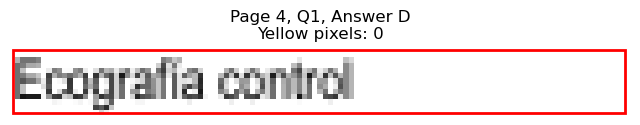

Page 4, Q1 - E: Detected box: x0=336.7, y0=157.3, x1=453.6, y1=169.4
Page 4, Q1, E: Yellow pixels: 0
Page 4, Q1, E: Total non-white pixels: 614
Page 4, Q1, E: Yellow percentage: 0.0%


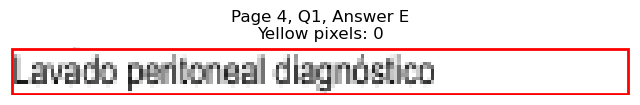


Page 4, Q1 - Selected Answer: A (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=85.0, y0=229.7, x1=121.8, y1=241.8
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 194
Page 4, Q2, A: Yellow percentage: 0.0%


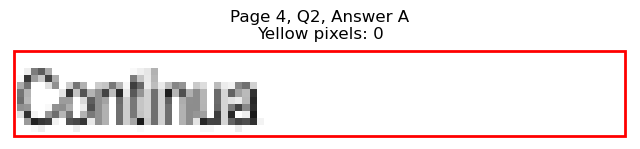

Page 4, Q2 - B: Detected box: x0=85.0, y0=241.7, x1=133.3, y1=253.8
Page 4, Q2, B: Yellow pixels: 0
Page 4, Q2, B: Total non-white pixels: 341
Page 4, Q2, B: Yellow percentage: 0.0%


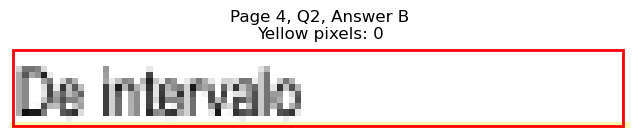

Page 4, Q2 - C: Detected box: x0=85.0, y0=253.7, x1=115.1, y1=265.8
Page 4, Q2, C: Yellow pixels: 852
Page 4, Q2, C: Total non-white pixels: 1066
Page 4, Q2, C: Yellow percentage: 79.9%


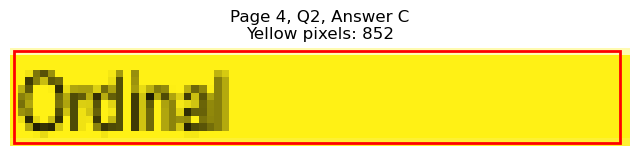

Page 4, Q2 - D: Detected box: x0=336.7, y0=229.7, x1=370.6, y1=241.8
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 168
Page 4, Q2, D: Yellow percentage: 0.0%


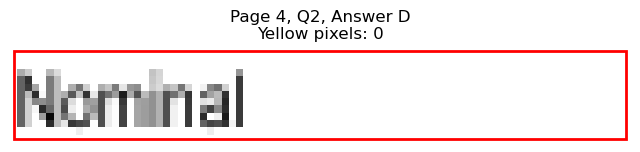

Page 4, Q2 - E: Detected box: x0=336.7, y0=241.7, x1=370.6, y1=253.8
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 176
Page 4, Q2, E: Yellow percentage: 0.0%


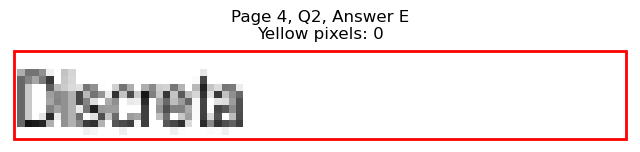


Page 4, Q2 - Selected Answer: C (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=85.0, y0=338.1, x1=135.7, y1=350.2
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 256
Page 4, Q3, A: Yellow percentage: 0.0%


Page 4, Q3 - B: Detected box: x0=85.0, y0=350.2, x1=179.3, y1=362.3
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 496
Page 4, Q3, B: Yellow percentage: 0.0%


Page 4, Q3 - C: Detected box: x0=85.0, y0=362.2, x1=120.9, y1=374.3
Page 4, Q3, C: Yellow pixels: 0
Page 4, Q3, C: Total non-white pixels: 193
Page 4, Q3, C: Yellow percentage: 0.0%


Page 4, Q3 - D: Detected box: x0=336.7, y0=338.1, x1=410.0, y1=350.2
Page 4, Q3, D: Yellow pixels: 1196
Page 4, Q3, D: Total non-white pixels: 1612
Page 4, Q3, D: Yellow percentage: 74.2%


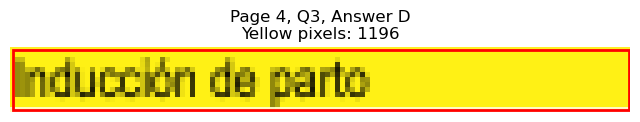

Page 4, Q3 - E: Detected box: x0=336.7, y0=350.2, x1=392.7, y1=362.3
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 412
Page 4, Q3, E: Yellow percentage: 0.0%


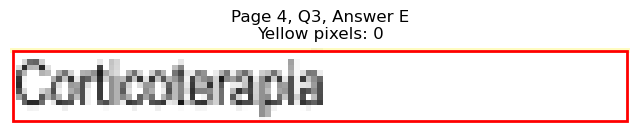


Page 4, Q3 - Selected Answer: D (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=85.0, y0=422.4, x1=145.0, y1=434.5
Page 4, Q4, A: Yellow pixels: 1197
Page 4, Q4, A: Total non-white pixels: 1443
Page 4, Q4, A: Yellow percentage: 83.0%


Page 4, Q4 - B: Detected box: x0=85.0, y0=434.4, x1=134.9, y1=446.5
Page 4, Q4, B: Yellow pixels: 101
Page 4, Q4, B: Total non-white pixels: 368
Page 4, Q4, B: Yellow percentage: 27.4%


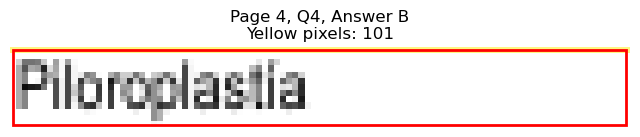

Page 4, Q4 - C: Detected box: x0=85.0, y0=446.6, x1=184.1, y1=458.7
Page 4, Q4, C: Yellow pixels: 0
Page 4, Q4, C: Total non-white pixels: 541
Page 4, Q4, C: Yellow percentage: 0.0%


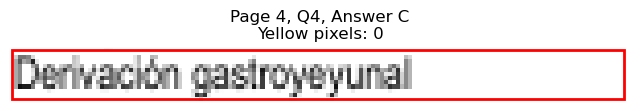

Page 4, Q4 - D: Detected box: x0=336.7, y0=422.4, x1=385.5, y1=434.5
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 249
Page 4, Q4, D: Yellow percentage: 0.0%


Page 4, Q4 - E: Detected box: x0=336.7, y0=434.4, x1=424.3, y1=446.5
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 438
Page 4, Q4, E: Yellow percentage: 0.0%


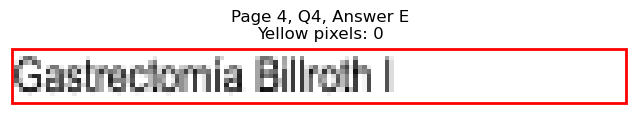


Page 4, Q4 - Selected Answer: A (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=85.0, y0=494.7, x1=193.3, y1=506.8
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 515
Page 4, Q5, A: Yellow percentage: 0.0%


Page 4, Q5 - B: Detected box: x0=85.0, y0=506.8, x1=176.9, y1=518.9
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 480
Page 4, Q5, B: Yellow percentage: 0.0%


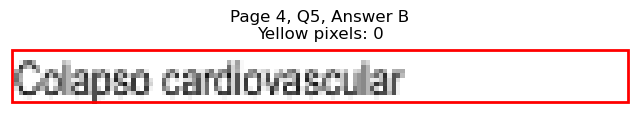

Page 4, Q5 - C: Detected box: x0=85.0, y0=518.8, x1=174.5, y1=530.9
Page 4, Q5, C: Yellow pixels: 0
Page 4, Q5, C: Total non-white pixels: 484
Page 4, Q5, C: Yellow percentage: 0.0%


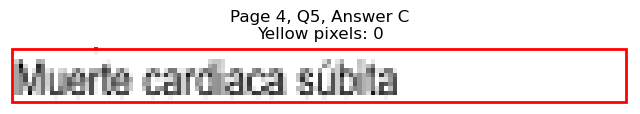

Page 4, Q5 - D: Detected box: x0=336.7, y0=494.7, x1=392.2, y1=506.8
Page 4, Q5, D: Yellow pixels: 1060
Page 4, Q5, D: Total non-white pixels: 1391
Page 4, Q5, D: Yellow percentage: 76.2%


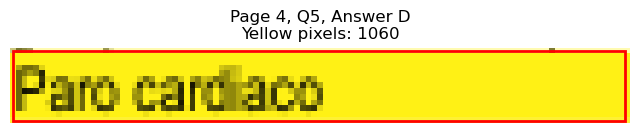

Page 4, Q5 - E: Detected box: x0=336.7, y0=506.8, x1=414.2, y1=518.9
Page 4, Q5, E: Yellow pixels: 129
Page 4, Q5, E: Total non-white pixels: 534
Page 4, Q5, E: Yellow percentage: 24.2%


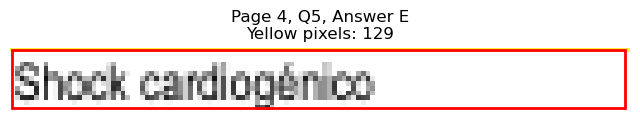


Page 4, Q5 - Selected Answer: D (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=85.0, y0=591.2, x1=209.0, y1=603.3
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 622
Page 4, Q6, A: Yellow percentage: 0.0%


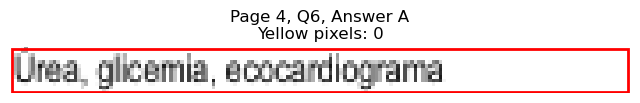

Page 4, Q6 - B: Detected box: x0=85.0, y0=603.2, x1=220.0, y1=615.3
Page 4, Q6, B: Yellow pixels: 187
Page 4, Q6, B: Total non-white pixels: 878
Page 4, Q6, B: Yellow percentage: 21.3%


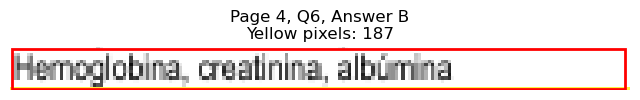

Page 4, Q6 - C: Detected box: x0=85.0, y0=615.2, x1=196.5, y1=627.3
Page 4, Q6, C: Yellow pixels: 1497
Page 4, Q6, C: Total non-white pixels: 2119
Page 4, Q6, C: Yellow percentage: 70.6%


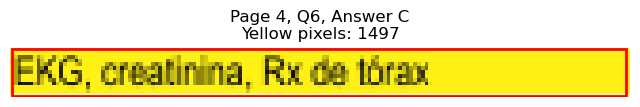

Page 4, Q6 - D: Detected box: x0=336.7, y0=591.2, x1=440.1, y1=603.3
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 496
Page 4, Q6, D: Yellow percentage: 0.0%


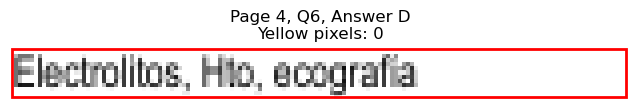

Page 4, Q6 - E: Detected box: x0=336.7, y0=603.2, x1=464.0, y1=615.3
Page 4, Q6, E: Yellow pixels: 0
Page 4, Q6, E: Total non-white pixels: 620
Page 4, Q6, E: Yellow percentage: 0.0%


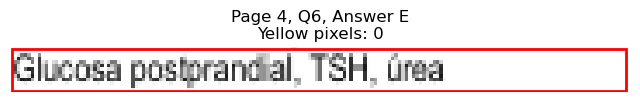


Page 4, Q6 - Selected Answer: C (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=85.0, y0=663.4, x1=230.6, y1=675.5
Page 4, Q7, A: Yellow pixels: 1856
Page 4, Q7, A: Total non-white pixels: 2483
Page 4, Q7, A: Yellow percentage: 74.7%


Page 4, Q7 - B: Detected box: x0=85.0, y0=675.4, x1=231.5, y1=687.5
Page 4, Q7, B: Yellow pixels: 190
Page 4, Q7, B: Total non-white pixels: 931
Page 4, Q7, B: Yellow percentage: 20.4%


Page 4, Q7 - C: Detected box: x0=85.0, y0=687.5, x1=228.7, y1=699.7
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 737
Page 4, Q7, C: Yellow percentage: 0.0%


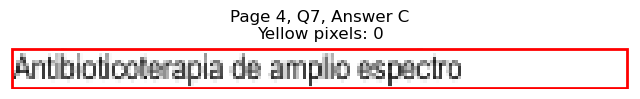

Page 4, Q7 - D: Detected box: x0=336.7, y0=663.4, x1=451.1, y1=675.5
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 547
Page 4, Q7, D: Yellow percentage: 0.0%


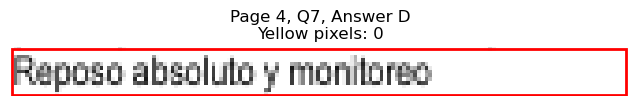

Page 4, Q7 - E: Detected box: x0=336.7, y0=675.4, x1=480.8, y1=687.5
Page 4, Q7, E: Yellow pixels: 0
Page 4, Q7, E: Total non-white pixels: 709
Page 4, Q7, E: Yellow percentage: 0.0%


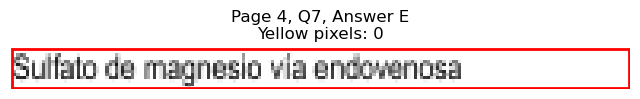


Page 4, Q7 - Selected Answer: A (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=85.0, y0=723.7, x1=183.1, y1=735.8
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 498
Page 4, Q8, A: Yellow percentage: 0.0%


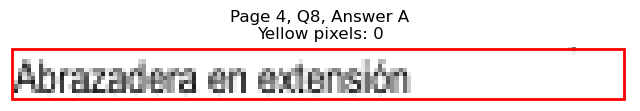

Page 4, Q8 - B: Detected box: x0=85.0, y0=735.8, x1=148.2, y1=747.9
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 336
Page 4, Q8, B: Yellow percentage: 0.0%


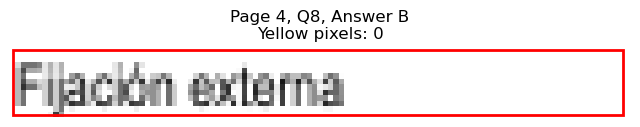

Page 4, Q8 - C: Detected box: x0=85.0, y0=747.8, x1=144.4, y1=759.9
Page 4, Q8, C: Yellow pixels: 0
Page 4, Q8, C: Total non-white pixels: 400
Page 4, Q8, C: Yellow percentage: 0.0%


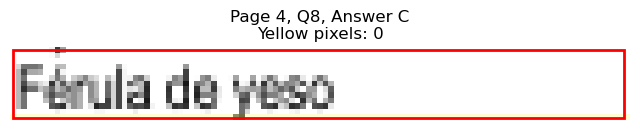

Page 4, Q8 - D: Detected box: x0=336.7, y0=723.7, x1=425.2, y1=735.8
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 453
Page 4, Q8, D: Yellow percentage: 0.0%


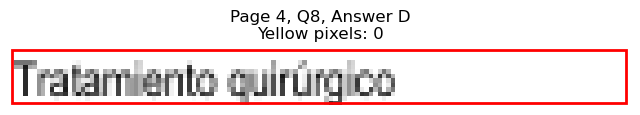

Page 4, Q8 - E: Detected box: x0=336.7, y0=735.8, x1=410.4, y1=747.9
Page 4, Q8, E: Yellow pixels: 1197
Page 4, Q8, E: Total non-white pixels: 1625
Page 4, Q8, E: Yellow percentage: 73.7%


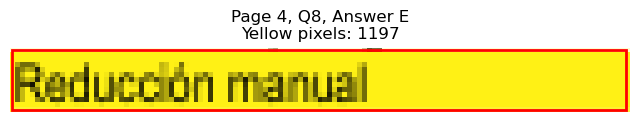


Page 4, Q8 - Selected Answer: E (based on yellow pixel count)





Page 5: Found 8 questions
Page 5, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=136.2, y1=109.2
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 290
Page 5, Q1, A: Yellow percentage: 0.0%


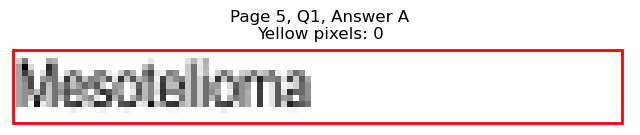

Page 5, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=214.3, y1=121.3
Page 5, Q1, B: Yellow pixels: 1619
Page 5, Q1, B: Total non-white pixels: 2353
Page 5, Q1, B: Yellow percentage: 68.8%


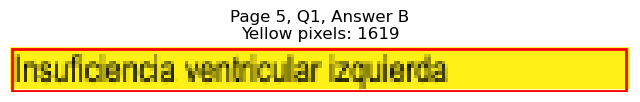

Page 5, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=151.5, y1=133.3
Page 5, Q1, C: Yellow pixels: 0
Page 5, Q1, C: Total non-white pixels: 480
Page 5, Q1, C: Yellow percentage: 0.0%


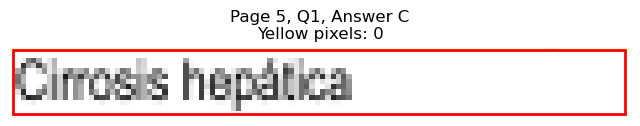

Page 5, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=421.4, y1=109.2
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 425
Page 5, Q1, D: Yellow percentage: 0.0%


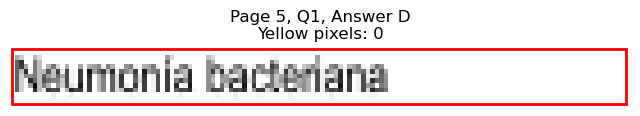

Page 5, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=419.0, y1=121.3
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 385
Page 5, Q1, E: Yellow percentage: 0.0%


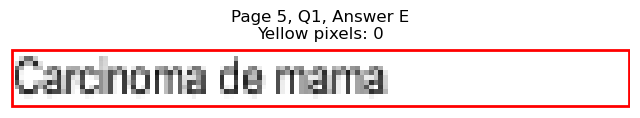


Page 5, Q1 - Selected Answer: B (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=85.0, y0=217.5, x1=134.8, y1=229.7
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 237
Page 5, Q2, A: Yellow percentage: 0.0%


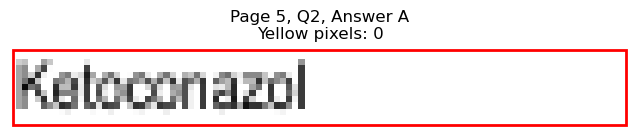

Page 5, Q2 - B: Detected box: x0=85.0, y0=229.7, x1=144.4, y1=241.8
Page 5, Q2, B: Yellow pixels: 1071
Page 5, Q2, B: Total non-white pixels: 1443
Page 5, Q2, B: Yellow percentage: 74.2%


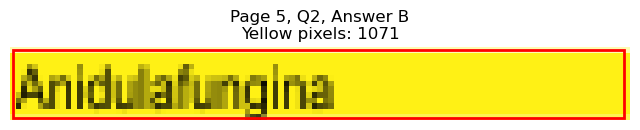

Page 5, Q2 - C: Detected box: x0=85.0, y0=241.7, x1=137.7, y1=253.8
Page 5, Q2, C: Yellow pixels: 100
Page 5, Q2, C: Total non-white pixels: 370
Page 5, Q2, C: Yellow percentage: 27.0%


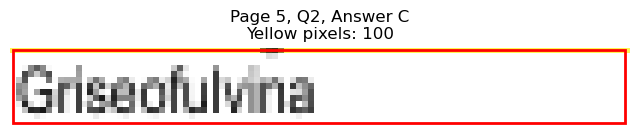

Page 5, Q2 - D: Detected box: x0=336.7, y0=217.5, x1=380.2, y1=229.7
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 226
Page 5, Q2, D: Yellow percentage: 0.0%


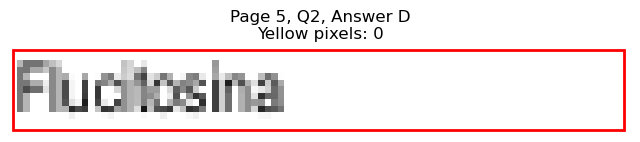

Page 5, Q2 - E: Detected box: x0=336.7, y0=229.7, x1=438.7, y1=241.8
Page 5, Q2, E: Yellow pixels: 0
Page 5, Q2, E: Total non-white pixels: 486
Page 5, Q2, E: Yellow percentage: 0.0%


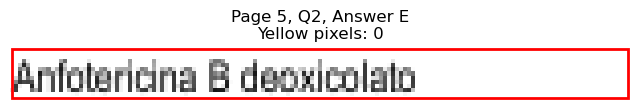


Page 5, Q2 - Selected Answer: B (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=85.0, y0=313.9, x1=181.7, y1=326.0
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 536
Page 5, Q3, A: Yellow percentage: 0.0%


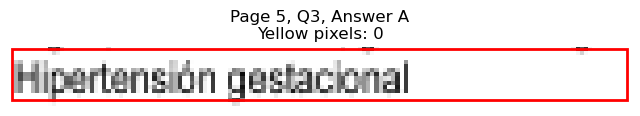

Page 5, Q3 - B: Detected box: x0=85.0, y0=326.1, x1=194.7, y1=338.2
Page 5, Q3, B: Yellow pixels: 0
Page 5, Q3, B: Total non-white pixels: 557
Page 5, Q3, B: Yellow percentage: 0.0%


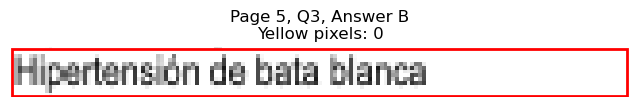

Page 5, Q3 - C: Detected box: x0=85.0, y0=338.1, x1=165.9, y1=350.2
Page 5, Q3, C: Yellow pixels: 0
Page 5, Q3, C: Total non-white pixels: 411
Page 5, Q3, C: Yellow percentage: 0.0%


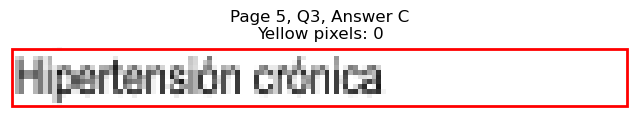

Page 5, Q3 - D: Detected box: x0=336.7, y0=313.9, x1=488.9, y1=326.0
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 788
Page 5, Q3, D: Yellow percentage: 0.0%


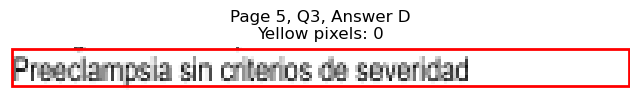

Page 5, Q3 - E: Detected box: x0=336.7, y0=326.1, x1=491.7, y1=338.2
Page 5, Q3, E: Yellow pixels: 1633
Page 5, Q3, E: Total non-white pixels: 2470
Page 5, Q3, E: Yellow percentage: 66.1%


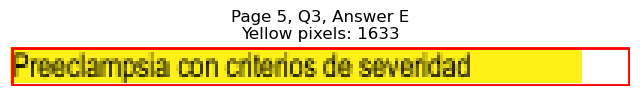


Page 5, Q3 - Selected Answer: E (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=85.0, y0=374.2, x1=174.0, y1=386.3
Page 5, Q4, A: Yellow pixels: 1320
Page 5, Q4, A: Total non-white pixels: 1833
Page 5, Q4, A: Yellow percentage: 72.0%


Page 5, Q4 - B: Detected box: x0=85.0, y0=386.3, x1=186.5, y1=398.4
Page 5, Q4, B: Yellow pixels: 0
Page 5, Q4, B: Total non-white pixels: 653
Page 5, Q4, B: Yellow percentage: 0.0%


Page 5, Q4 - C: Detected box: x0=85.0, y0=398.3, x1=187.0, y1=410.4
Page 5, Q4, C: Yellow pixels: 0
Page 5, Q4, C: Total non-white pixels: 525
Page 5, Q4, C: Yellow percentage: 0.0%


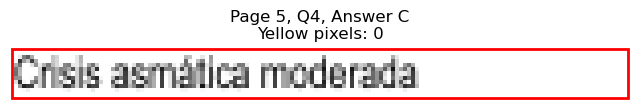

Page 5, Q4 - D: Detected box: x0=336.7, y0=374.2, x1=416.1, y1=386.3
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 380
Page 5, Q4, D: Yellow percentage: 0.0%


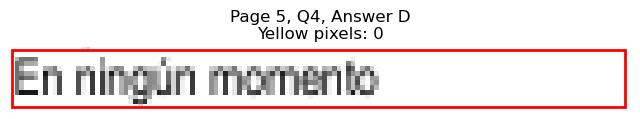

Page 5, Q4 - E: Detected box: x0=336.7, y0=386.3, x1=415.6, y1=398.4
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 407
Page 5, Q4, E: Yellow percentage: 0.0%


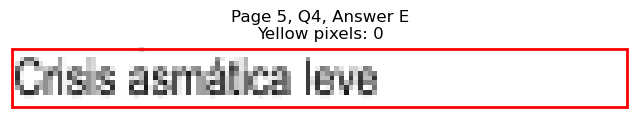


Page 5, Q4 - Selected Answer: A (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=85.0, y0=458.6, x1=177.4, y1=470.7
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 499
Page 5, Q5, A: Yellow percentage: 0.0%


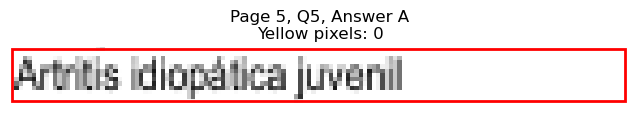

Page 5, Q5 - B: Detected box: x0=85.0, y0=470.7, x1=168.7, y1=482.8
Page 5, Q5, B: Yellow pixels: 0
Page 5, Q5, B: Total non-white pixels: 455
Page 5, Q5, B: Yellow percentage: 0.0%


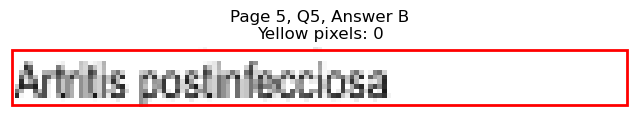

Page 5, Q5 - C: Detected box: x0=85.0, y0=482.7, x1=196.5, y1=494.8
Page 5, Q5, C: Yellow pixels: 0
Page 5, Q5, C: Total non-white pixels: 721
Page 5, Q5, C: Yellow percentage: 0.0%


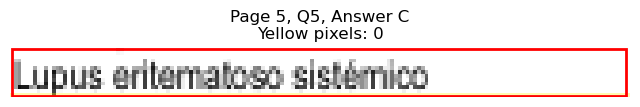

Page 5, Q5 - D: Detected box: x0=336.7, y0=458.6, x1=427.6, y1=470.7
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 471
Page 5, Q5, D: Yellow percentage: 0.0%


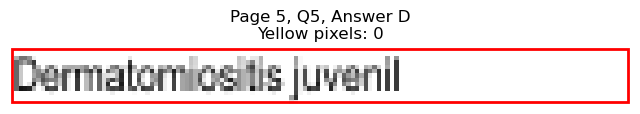

Page 5, Q5 - E: Detected box: x0=336.7, y0=470.7, x1=396.1, y1=482.8
Page 5, Q5, E: Yellow pixels: 1105
Page 5, Q5, E: Total non-white pixels: 1443
Page 5, Q5, E: Yellow percentage: 76.6%


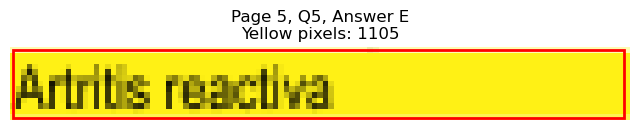


Page 5, Q5 - Selected Answer: E (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=85.0, y0=554.9, x1=186.5, y1=567.0
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 570
Page 5, Q6, A: Yellow percentage: 0.0%


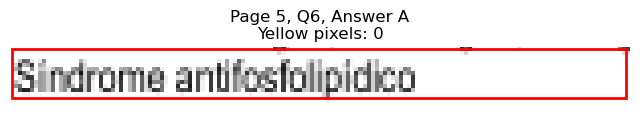

Page 5, Q6 - B: Detected box: x0=85.0, y0=567.1, x1=142.0, y1=579.2
Page 5, Q6, B: Yellow pixels: 108
Page 5, Q6, B: Total non-white pixels: 432
Page 5, Q6, B: Yellow percentage: 25.0%


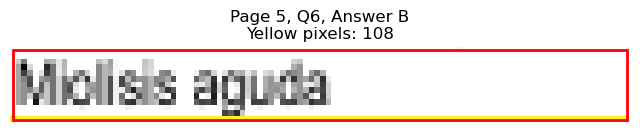

Page 5, Q6 - C: Detected box: x0=85.0, y0=579.1, x1=150.5, y1=591.2
Page 5, Q6, C: Yellow pixels: 1129
Page 5, Q6, C: Total non-white pixels: 1521
Page 5, Q6, C: Yellow percentage: 74.2%


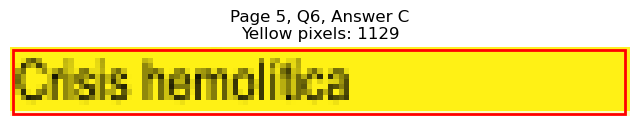

Page 5, Q6 - D: Detected box: x0=336.7, y0=554.9, x1=392.2, y1=567.0
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 296
Page 5, Q6, D: Yellow percentage: 0.0%


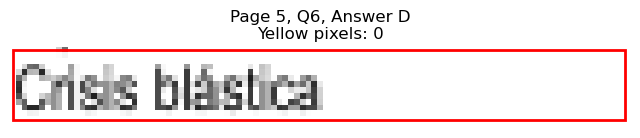

Page 5, Q6 - E: Detected box: x0=336.7, y0=567.1, x1=375.4, y1=579.2
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 203
Page 5, Q6, E: Yellow percentage: 0.0%


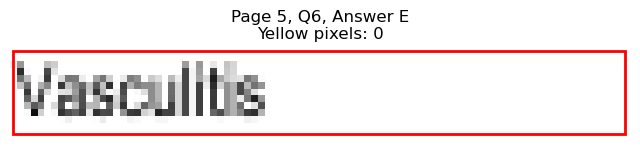


Page 5, Q6 - Selected Answer: C (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=70.8, y0=627.3, x1=79.0, y1=639.4
Page 5, Q7, A: Yellow pixels: 59
Page 5, Q7, A: Total non-white pixels: 107
Page 5, Q7, A: Yellow percentage: 55.1%


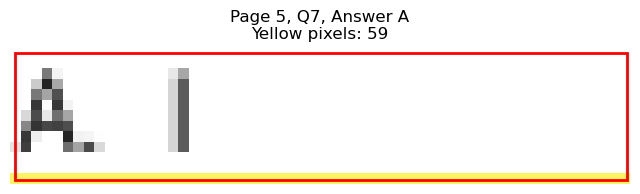

Page 5, Q7 - B: Detected box: x0=85.0, y0=639.3, x1=94.6, y1=651.4
Page 5, Q7, B: Yellow pixels: 754
Page 5, Q7, B: Total non-white pixels: 793
Page 5, Q7, B: Yellow percentage: 95.1%


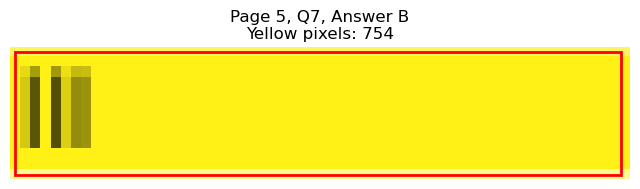

Page 5, Q7 - C: Detected box: x0=70.8, y0=651.4, x1=79.5, y1=663.5
Page 5, Q7, C: Yellow pixels: 60
Page 5, Q7, C: Total non-white pixels: 127
Page 5, Q7, C: Yellow percentage: 47.2%


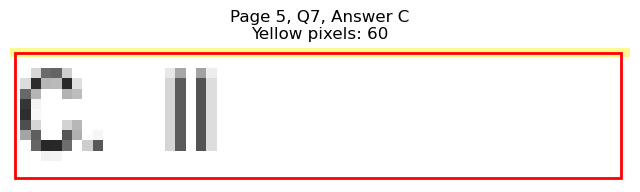

Page 5, Q7 - D: Detected box: x0=322.5, y0=627.3, x1=331.2, y1=639.4
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 61
Page 5, Q7, D: Yellow percentage: 0.0%


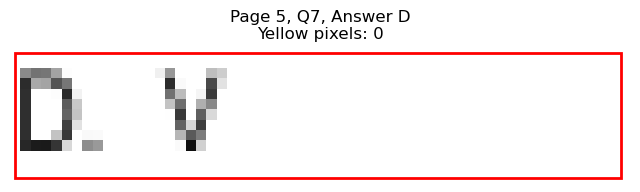

Page 5, Q7 - E: Detected box: x0=336.7, y0=639.3, x1=347.2, y1=651.4
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 44
Page 5, Q7, E: Yellow percentage: 0.0%


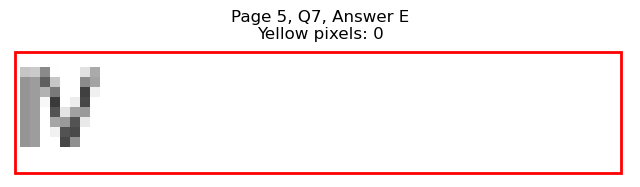


Page 5, Q7 - Selected Answer: B (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=85.0, y0=687.5, x1=148.2, y1=699.7
Page 5, Q8, A: Yellow pixels: 0
Page 5, Q8, A: Total non-white pixels: 337
Page 5, Q8, A: Yellow percentage: 0.0%


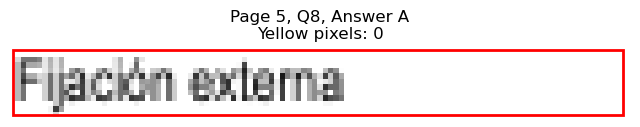

Page 5, Q8 - B: Detected box: x0=85.0, y0=699.5, x1=220.5, y1=711.7
Page 5, Q8, B: Yellow pixels: 0
Page 5, Q8, B: Total non-white pixels: 665
Page 5, Q8, B: Yellow percentage: 0.0%


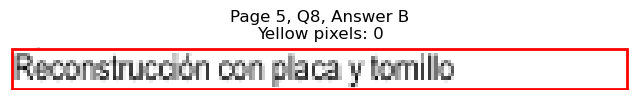

Page 5, Q8 - C: Detected box: x0=85.0, y0=711.7, x1=150.3, y1=723.8
Page 5, Q8, C: Yellow pixels: 1151
Page 5, Q8, C: Total non-white pixels: 1521
Page 5, Q8, C: Yellow percentage: 75.7%


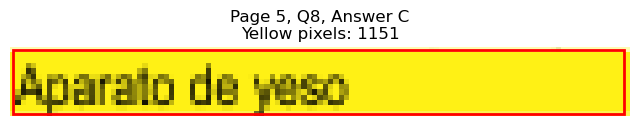

Page 5, Q8 - D: Detected box: x0=336.7, y0=687.5, x1=427.2, y1=699.7
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 470
Page 5, Q8, D: Yellow percentage: 0.0%


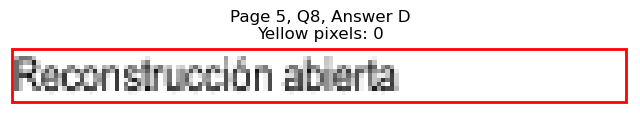

Page 5, Q8 - E: Detected box: x0=336.7, y0=699.5, x1=395.2, y1=711.7
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 313
Page 5, Q8, E: Yellow percentage: 0.0%


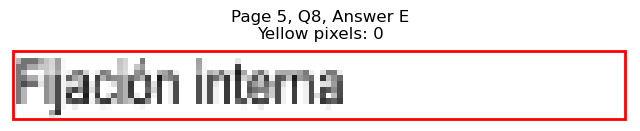


Page 5, Q8 - Selected Answer: C (based on yellow pixel count)





Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=198.5, y1=133.3
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 592
Page 6, Q1, A: Yellow percentage: 0.0%


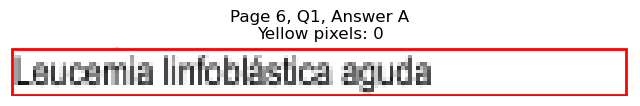

Page 6, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=149.2, y1=145.3
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 315
Page 6, Q1, B: Yellow percentage: 0.0%


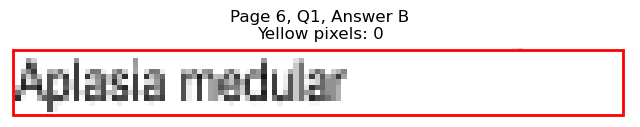

Page 6, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=215.7, y1=157.4
Page 6, Q1, C: Yellow pixels: 1652
Page 6, Q1, C: Total non-white pixels: 2366
Page 6, Q1, C: Yellow percentage: 69.8%


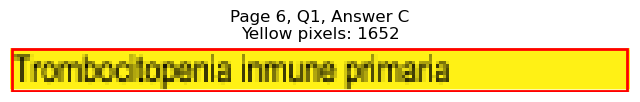

Page 6, Q1 - D: Detected box: x0=336.7, y0=121.2, x1=459.7, y1=133.3
Page 6, Q1, D: Yellow pixels: 0
Page 6, Q1, D: Total non-white pixels: 618
Page 6, Q1, D: Yellow percentage: 0.0%


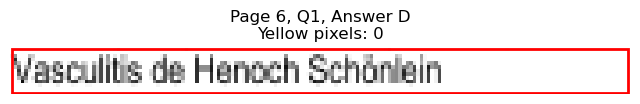

Page 6, Q1 - E: Detected box: x0=336.7, y0=133.2, x1=448.2, y1=145.3
Page 6, Q1, E: Yellow pixels: 0
Page 6, Q1, E: Total non-white pixels: 562
Page 6, Q1, E: Yellow percentage: 0.0%


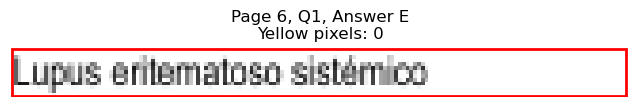


Page 6, Q1 - Selected Answer: C (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=85.0, y0=193.4, x1=154.3, y1=205.5
Page 6, Q2, A: Yellow pixels: 1296
Page 6, Q2, A: Total non-white pixels: 1573
Page 6, Q2, A: Yellow percentage: 82.4%


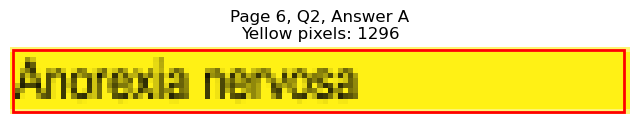

Page 6, Q2 - B: Detected box: x0=85.0, y0=205.5, x1=115.6, y1=217.7
Page 6, Q2, B: Yellow pixels: 82
Page 6, Q2, B: Total non-white pixels: 222
Page 6, Q2, B: Yellow percentage: 36.9%


Page 6, Q2 - C: Detected box: x0=85.0, y0=217.5, x1=118.9, y1=229.7
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 170
Page 6, Q2, C: Yellow percentage: 0.0%


Page 6, Q2 - D: Detected box: x0=336.7, y0=193.4, x1=378.3, y1=205.5
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 218
Page 6, Q2, D: Yellow percentage: 0.0%


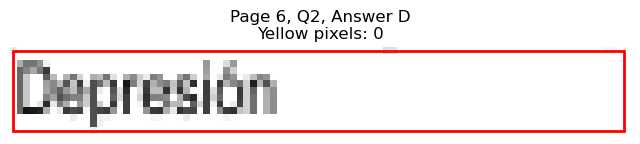

Page 6, Q2 - E: Detected box: x0=336.7, y0=205.5, x1=396.4, y1=217.7
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 323
Page 6, Q2, E: Yellow percentage: 0.0%


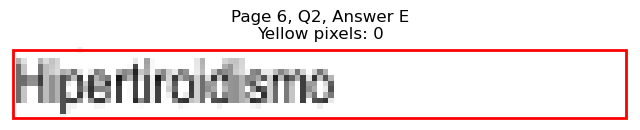


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=85.0, y0=289.9, x1=175.5, y1=302.0
Page 6, Q3, A: Yellow pixels: 1299
Page 6, Q3, A: Total non-white pixels: 1850
Page 6, Q3, A: Yellow percentage: 70.2%


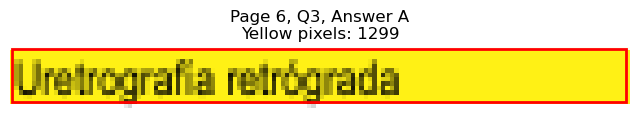

Page 6, Q3 - B: Detected box: x0=85.0, y0=301.9, x1=134.8, y1=314.0
Page 6, Q3, B: Yellow pixels: 93
Page 6, Q3, B: Total non-white pixels: 352
Page 6, Q3, B: Yellow percentage: 26.4%


Page 6, Q3 - C: Detected box: x0=85.0, y0=313.9, x1=160.6, y1=326.0
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 401
Page 6, Q3, C: Yellow percentage: 0.0%


Page 6, Q3 - D: Detected box: x0=336.7, y0=289.9, x1=380.8, y1=302.0
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 246
Page 6, Q3, D: Yellow percentage: 0.0%


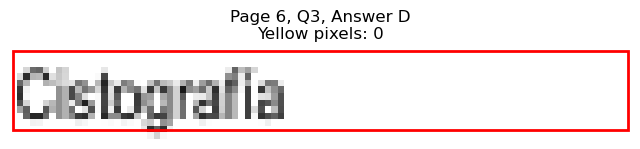

Page 6, Q3 - E: Detected box: x0=336.7, y0=301.9, x1=451.1, y1=314.0
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 622
Page 6, Q3, E: Yellow percentage: 0.0%


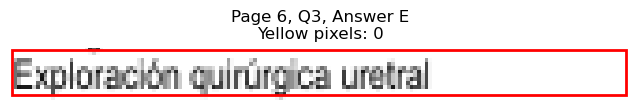


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=85.0, y0=350.2, x1=116.5, y1=362.3
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 155
Page 6, Q4, A: Yellow percentage: 0.0%


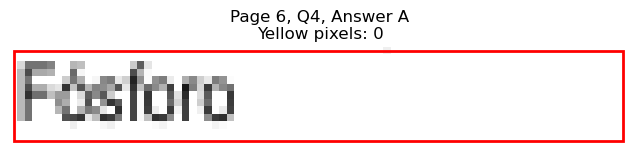

Page 6, Q4 - B: Detected box: x0=85.0, y0=362.2, x1=107.9, y1=374.3
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 110
Page 6, Q4, B: Yellow percentage: 0.0%


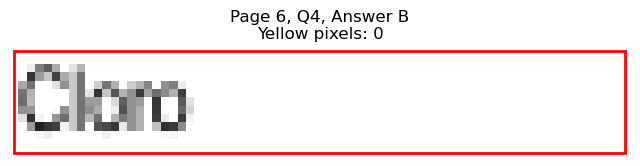

Page 6, Q4 - C: Detected box: x0=85.0, y0=374.2, x1=132.4, y1=386.3
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 251
Page 6, Q4, C: Yellow percentage: 0.0%


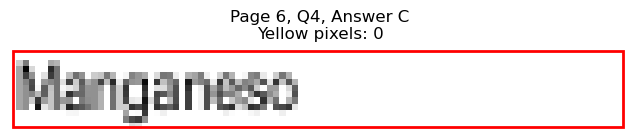

Page 6, Q4 - D: Detected box: x0=336.7, y0=350.2, x1=363.0, y1=362.3
Page 6, Q4, D: Yellow pixels: 821
Page 6, Q4, D: Total non-white pixels: 1001
Page 6, Q4, D: Yellow percentage: 82.0%


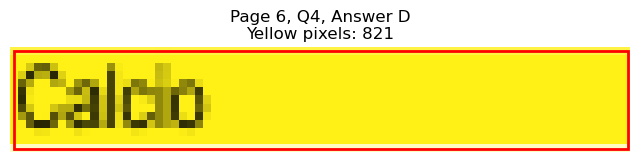

Page 6, Q4 - E: Detected box: x0=336.7, y0=362.2, x1=376.4, y1=374.3
Page 6, Q4, E: Yellow pixels: 0
Page 6, Q4, E: Total non-white pixels: 297
Page 6, Q4, E: Yellow percentage: 0.0%


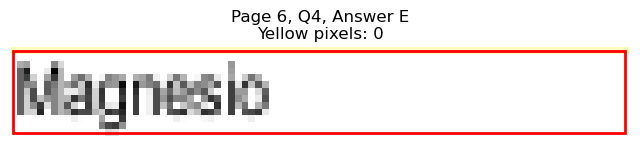


Page 6, Q4 - Selected Answer: D (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=85.0, y0=422.4, x1=235.3, y1=434.5
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 764
Page 6, Q5, A: Yellow percentage: 0.0%


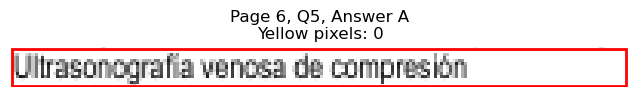

Page 6, Q5 - B: Detected box: x0=85.0, y0=434.4, x1=235.3, y1=446.5
Page 6, Q5, B: Yellow pixels: 0
Page 6, Q5, B: Total non-white pixels: 785
Page 6, Q5, B: Yellow percentage: 0.0%


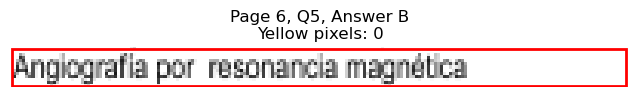

Page 6, Q5 - C: Detected box: x0=85.0, y0=446.6, x1=260.7, y1=458.7
Page 6, Q5, C: Yellow pixels: 1739
Page 6, Q5, C: Total non-white pixels: 2483
Page 6, Q5, C: Yellow percentage: 70.0%


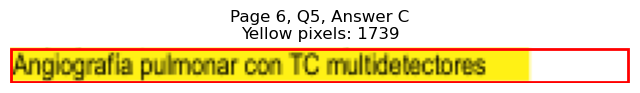

Page 6, Q5 - D: Detected box: x0=336.7, y0=422.4, x1=430.0, y1=434.5
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 473
Page 6, Q5, D: Yellow percentage: 0.0%


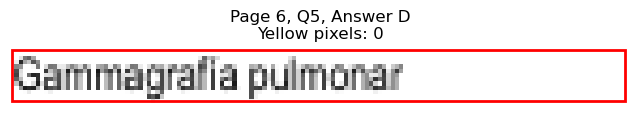

Page 6, Q5 - E: Detected box: x0=336.7, y0=434.4, x1=459.7, y1=446.5
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 602
Page 6, Q5, E: Yellow percentage: 0.0%


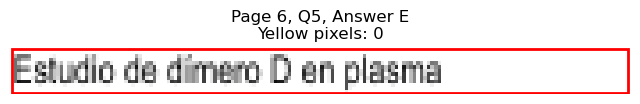


Page 6, Q5 - Selected Answer: C (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=85.0, y0=482.7, x1=123.3, y1=494.8
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 207
Page 6, Q6, A: Yellow percentage: 0.0%


Page 6, Q6 - B: Detected box: x0=85.0, y0=494.7, x1=126.6, y1=506.8
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 195
Page 6, Q6, B: Yellow percentage: 0.0%


Page 6, Q6 - C: Detected box: x0=85.0, y0=506.8, x1=129.5, y1=518.9
Page 6, Q6, C: Yellow pixels: 960
Page 6, Q6, C: Total non-white pixels: 1248
Page 6, Q6, C: Yellow percentage: 76.9%


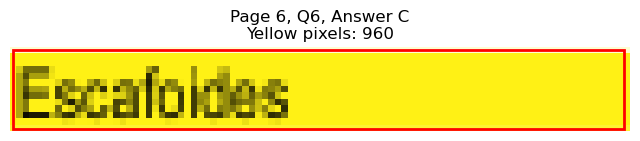

Page 6, Q6 - D: Detected box: x0=336.7, y0=482.7, x1=372.6, y1=494.8
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 160
Page 6, Q6, D: Yellow percentage: 0.0%


Page 6, Q6 - E: Detected box: x0=336.7, y0=494.7, x1=377.8, y1=506.8
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 210
Page 6, Q6, E: Yellow percentage: 0.0%


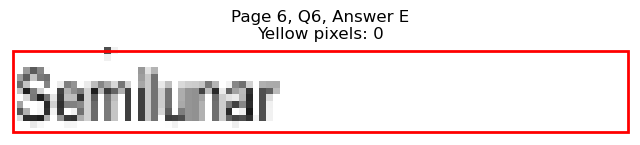


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=85.0, y0=554.9, x1=190.4, y1=567.0
Page 6, Q7, A: Yellow pixels: 0
Page 6, Q7, A: Total non-white pixels: 583
Page 6, Q7, A: Yellow percentage: 0.0%


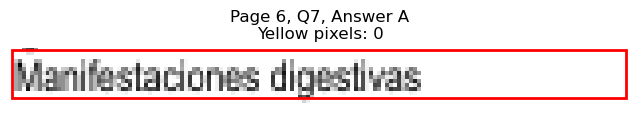

Page 6, Q7 - B: Detected box: x0=85.0, y0=567.1, x1=118.5, y1=579.2
Page 6, Q7, B: Yellow pixels: 85
Page 6, Q7, B: Total non-white pixels: 277
Page 6, Q7, B: Yellow percentage: 30.7%


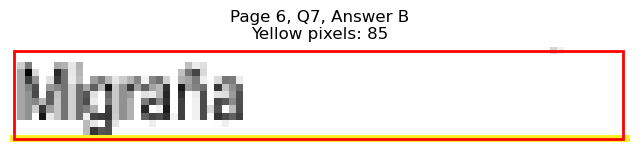

Page 6, Q7 - C: Detected box: x0=85.0, y0=579.1, x1=204.2, y1=591.2
Page 6, Q7, C: Yellow pixels: 1510
Page 6, Q7, C: Total non-white pixels: 2223
Page 6, Q7, C: Yellow percentage: 67.9%


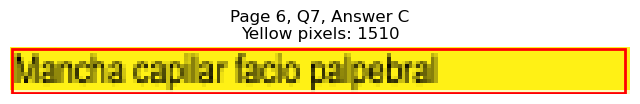

Page 6, Q7 - D: Detected box: x0=336.7, y0=554.9, x1=390.8, y1=567.0
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 264
Page 6, Q7, D: Yellow percentage: 0.0%


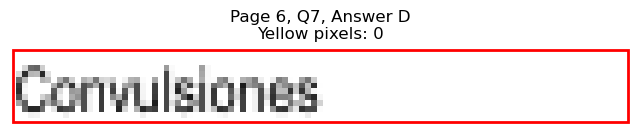

Page 6, Q7 - E: Detected box: x0=336.7, y0=567.1, x1=423.3, y1=579.2
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 458
Page 6, Q7, E: Yellow percentage: 0.0%



Page 6, Q7 - Selected Answer: C (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=85.0, y0=627.3, x1=129.0, y1=639.4
Page 6, Q8, A: Yellow pixels: 0
Page 6, Q8, A: Total non-white pixels: 211
Page 6, Q8, A: Yellow percentage: 0.0%


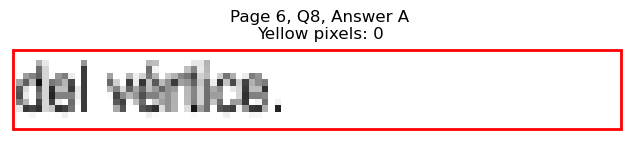

Page 6, Q8 - B: Detected box: x0=85.0, y0=639.3, x1=145.3, y1=651.4
Page 6, Q8, B: Yellow pixels: 0
Page 6, Q8, B: Total non-white pixels: 294
Page 6, Q8, B: Yellow percentage: 0.0%


Page 6, Q8 - C: Detected box: x0=85.0, y0=651.4, x1=142.9, y1=663.5
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 278
Page 6, Q8, C: Yellow percentage: 0.0%


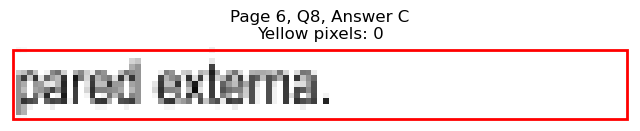

Page 6, Q8 - D: Detected box: x0=336.7, y0=627.3, x1=392.2, y1=639.4
Page 6, Q8, D: Yellow pixels: 1047
Page 6, Q8, D: Total non-white pixels: 1391
Page 6, Q8, D: Yellow percentage: 75.3%


Page 6, Q8 - E: Detected box: x0=336.7, y0=639.3, x1=392.2, y1=651.4
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 389
Page 6, Q8, E: Yellow percentage: 0.0%


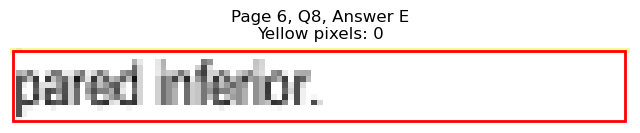


Page 6, Q8 - Selected Answer: D (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=85.0, y0=699.5, x1=171.6, y1=711.7
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 472
Page 6, Q9, A: Yellow percentage: 0.0%


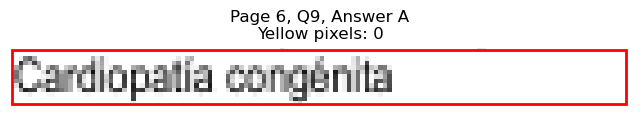

Page 6, Q9 - B: Detected box: x0=85.0, y0=711.7, x1=214.7, y1=723.8
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 661
Page 6, Q9, B: Yellow percentage: 0.0%


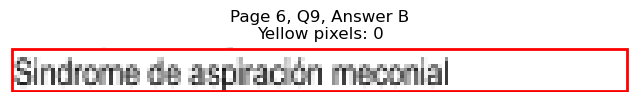

Page 6, Q9 - C: Detected box: x0=85.0, y0=723.7, x1=197.6, y1=735.8
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 582
Page 6, Q9, C: Yellow percentage: 0.0%


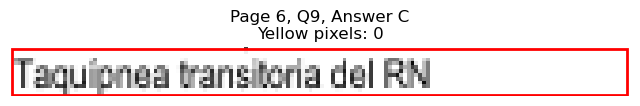

Page 6, Q9 - D: Detected box: x0=336.7, y0=699.5, x1=413.7, y1=711.7
Page 6, Q9, D: Yellow pixels: 0
Page 6, Q9, D: Total non-white pixels: 362
Page 6, Q9, D: Yellow percentage: 0.0%


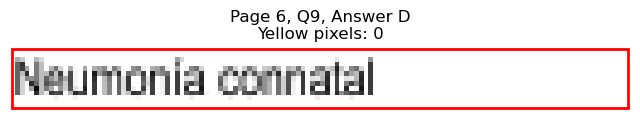

Page 6, Q9 - E: Detected box: x0=336.7, y0=711.7, x1=468.8, y1=723.8
Page 6, Q9, E: Yellow pixels: 1628
Page 6, Q9, E: Total non-white pixels: 2379
Page 6, Q9, E: Yellow percentage: 68.4%


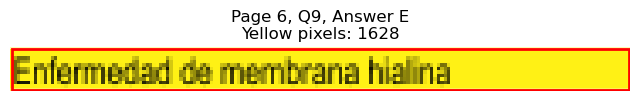


Page 6, Q9 - Selected Answer: E (based on yellow pixel count)





Page 7: Found 9 questions
Page 7, Q1 - A: Detected box: x0=85.0, y0=121.2, x1=191.8, y1=133.3
Page 7, Q1, A: Yellow pixels: 158
Page 7, Q1, A: Total non-white pixels: 700
Page 7, Q1, A: Yellow percentage: 22.6%


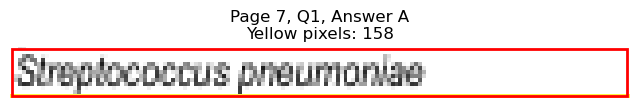

Page 7, Q1 - B: Detected box: x0=85.0, y0=133.2, x1=183.1, y1=145.3
Page 7, Q1, B: Yellow pixels: 1398
Page 7, Q1, B: Total non-white pixels: 1950
Page 7, Q1, B: Yellow percentage: 71.7%


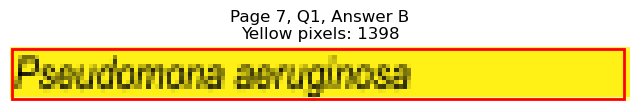

Page 7, Q1 - C: Detected box: x0=85.0, y0=145.3, x1=179.3, y1=157.4
Page 7, Q1, C: Yellow pixels: 1
Page 7, Q1, C: Total non-white pixels: 638
Page 7, Q1, C: Yellow percentage: 0.2%


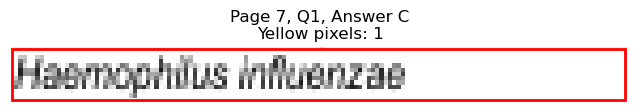

Page 7, Q1 - D: Detected box: x0=336.7, y0=121.2, x1=428.1, y1=133.3
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 457
Page 7, Q1, D: Yellow percentage: 0.0%


Page 7, Q1 - E: Detected box: x0=336.7, y0=133.2, x1=433.4, y1=145.3
Page 7, Q1, E: Yellow pixels: 0
Page 7, Q1, E: Total non-white pixels: 516
Page 7, Q1, E: Yellow percentage: 0.0%



Page 7, Q1 - Selected Answer: B (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=135.9, y1=193.5
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 276
Page 7, Q2, A: Yellow percentage: 0.0%


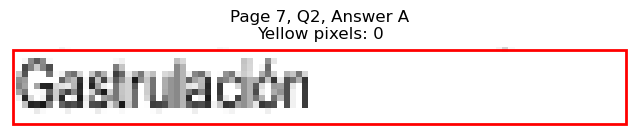

Page 7, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=142.5, y1=205.5
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 303
Page 7, Q2, B: Yellow percentage: 0.0%


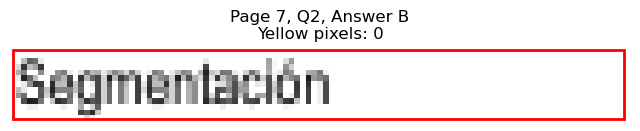

Page 7, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=147.7, y1=217.7
Page 7, Q2, C: Yellow pixels: 0
Page 7, Q2, C: Total non-white pixels: 338
Page 7, Q2, C: Yellow percentage: 0.0%


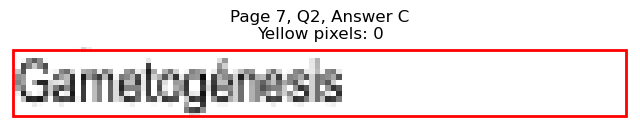

Page 7, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=388.5, y1=193.5
Page 7, Q2, D: Yellow pixels: 1121
Page 7, Q2, D: Total non-white pixels: 1339
Page 7, Q2, D: Yellow percentage: 83.7%


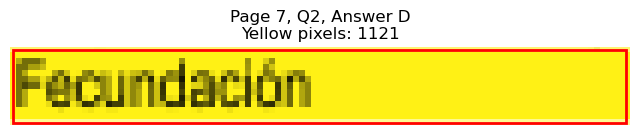

Page 7, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=394.3, y1=205.5
Page 7, Q2, E: Yellow pixels: 109
Page 7, Q2, E: Total non-white pixels: 430
Page 7, Q2, E: Yellow percentage: 25.3%


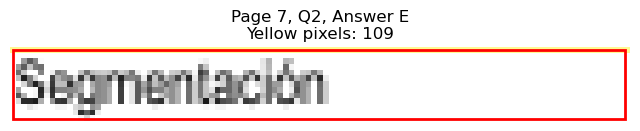


Page 7, Q2 - Selected Answer: D (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=85.0, y0=277.8, x1=190.4, y1=289.9
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 576
Page 7, Q3, A: Yellow percentage: 0.0%


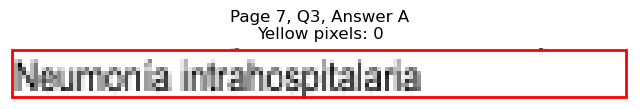

Page 7, Q3 - B: Detected box: x0=85.0, y0=289.9, x1=213.3, y1=302.0
Page 7, Q3, B: Yellow pixels: 180
Page 7, Q3, B: Total non-white pixels: 1001
Page 7, Q3, B: Yellow percentage: 18.0%


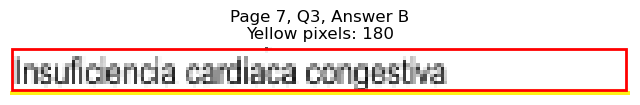

Page 7, Q3 - C: Detected box: x0=85.0, y0=301.9, x1=156.7, y1=314.0
Page 7, Q3, C: Yellow pixels: 1186
Page 7, Q3, C: Total non-white pixels: 1600
Page 7, Q3, C: Yellow percentage: 74.1%


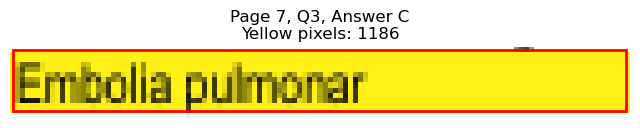

Page 7, Q3 - D: Detected box: x0=336.7, y0=277.8, x1=441.7, y1=289.9
Page 7, Q3, D: Yellow pixels: 0
Page 7, Q3, D: Total non-white pixels: 529
Page 7, Q3, D: Yellow percentage: 0.0%


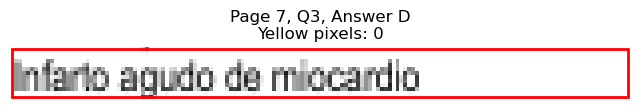

Page 7, Q3 - E: Detected box: x0=336.7, y0=289.9, x1=402.8, y1=302.0
Page 7, Q3, E: Yellow pixels: 0
Page 7, Q3, E: Total non-white pixels: 367
Page 7, Q3, E: Yellow percentage: 0.0%


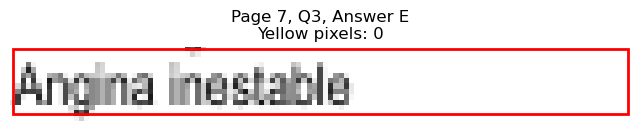


Page 7, Q3 - Selected Answer: C (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=85.0, y0=338.1, x1=130.9, y1=350.2
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 232
Page 7, Q4, A: Yellow percentage: 0.0%


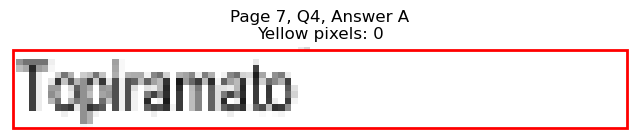

Page 7, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=135.3, y1=362.3
Page 7, Q4, B: Yellow pixels: 102
Page 7, Q4, B: Total non-white pixels: 382
Page 7, Q4, B: Yellow percentage: 26.7%


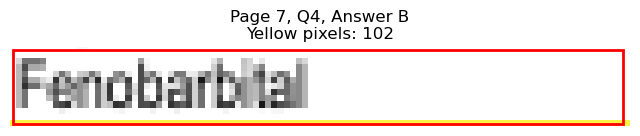

Page 7, Q4 - C: Detected box: x0=85.0, y0=362.2, x1=148.2, y1=374.3
Page 7, Q4, C: Yellow pixels: 1112
Page 7, Q4, C: Total non-white pixels: 1495
Page 7, Q4, C: Yellow percentage: 74.4%


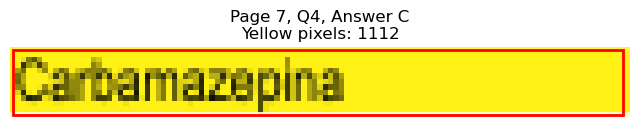

Page 7, Q4 - D: Detected box: x0=336.7, y0=338.1, x1=384.1, y1=350.2
Page 7, Q4, D: Yellow pixels: 0
Page 7, Q4, D: Total non-white pixels: 242
Page 7, Q4, D: Yellow percentage: 0.0%


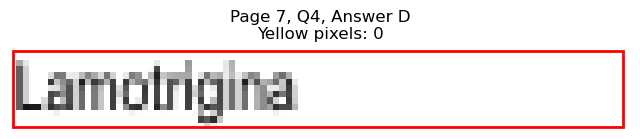

Page 7, Q4 - E: Detected box: x0=336.7, y0=350.2, x1=375.0, y1=362.3
Page 7, Q4, E: Yellow pixels: 0
Page 7, Q4, E: Total non-white pixels: 188
Page 7, Q4, E: Yellow percentage: 0.0%


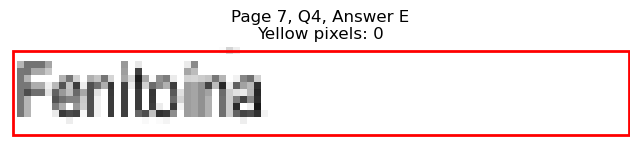


Page 7, Q4 - Selected Answer: C (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=85.0, y0=410.4, x1=218.6, y1=422.5
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 705
Page 7, Q5, A: Yellow percentage: 0.0%


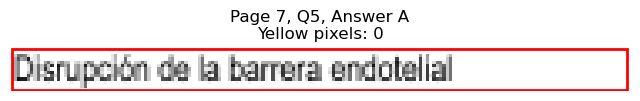

Page 7, Q5 - B: Detected box: x0=85.0, y0=422.4, x1=193.7, y1=434.5
Page 7, Q5, B: Yellow pixels: 0
Page 7, Q5, B: Total non-white pixels: 560
Page 7, Q5, B: Yellow percentage: 0.0%


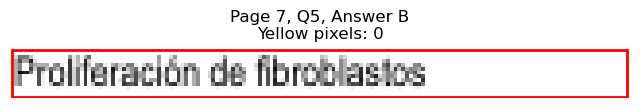

Page 7, Q5 - C: Detected box: x0=85.0, y0=434.4, x1=239.6, y1=446.5
Page 7, Q5, C: Yellow pixels: 0
Page 7, Q5, C: Total non-white pixels: 765
Page 7, Q5, C: Yellow percentage: 0.0%


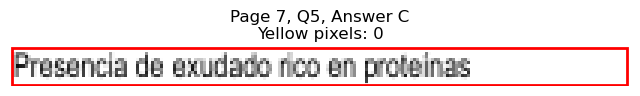

Page 7, Q5 - D: Detected box: x0=336.7, y0=410.4, x1=452.0, y1=422.5
Page 7, Q5, D: Yellow pixels: 167
Page 7, Q5, D: Total non-white pixels: 723
Page 7, Q5, D: Yellow percentage: 23.1%


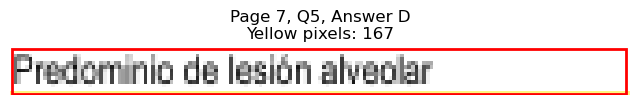

Page 7, Q5 - E: Detected box: x0=336.7, y0=422.4, x1=492.2, y1=434.5
Page 7, Q5, E: Yellow pixels: 1846
Page 7, Q5, E: Total non-white pixels: 2470
Page 7, Q5, E: Yellow percentage: 74.7%


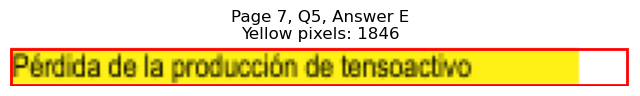


Page 7, Q5 - Selected Answer: E (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=85.0, y0=482.7, x1=185.5, y1=494.8
Page 7, Q6, A: Yellow pixels: 1405
Page 7, Q6, A: Total non-white pixels: 1976
Page 7, Q6, A: Yellow percentage: 71.1%


Page 7, Q6 - B: Detected box: x0=85.0, y0=494.7, x1=168.3, y1=506.8
Page 7, Q6, B: Yellow pixels: 135
Page 7, Q6, B: Total non-white pixels: 545
Page 7, Q6, B: Yellow percentage: 24.8%


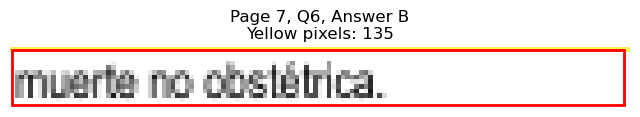

Page 7, Q6 - C: Detected box: x0=85.0, y0=506.8, x1=229.5, y1=518.9
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 706
Page 7, Q6, C: Yellow percentage: 0.0%


Page 7, Q6 - D: Detected box: x0=336.7, y0=482.7, x1=430.5, y1=494.8
Page 7, Q6, D: Yellow pixels: 0
Page 7, Q6, D: Total non-white pixels: 456
Page 7, Q6, D: Yellow percentage: 0.0%


Page 7, Q6 - E: Detected box: x0=336.7, y0=494.7, x1=446.9, y1=506.8
Page 7, Q6, E: Yellow pixels: 0
Page 7, Q6, E: Total non-white pixels: 563
Page 7, Q6, E: Yellow percentage: 0.0%


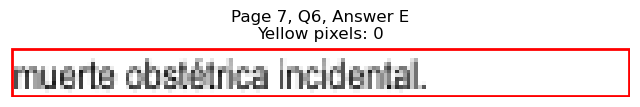


Page 7, Q6 - Selected Answer: A (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=85.0, y0=554.9, x1=219.5, y1=567.0
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 708
Page 7, Q7, A: Yellow percentage: 0.0%


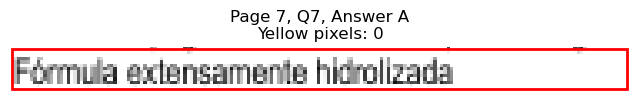

Page 7, Q7 - B: Detected box: x0=85.0, y0=567.1, x1=203.7, y1=579.2
Page 7, Q7, B: Yellow pixels: 1548
Page 7, Q7, B: Total non-white pixels: 2210
Page 7, Q7, B: Yellow percentage: 70.0%


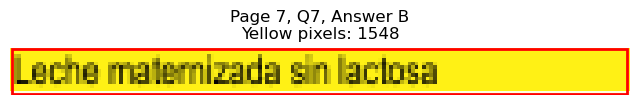

Page 7, Q7 - C: Detected box: x0=85.0, y0=579.1, x1=195.2, y1=591.2
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 729
Page 7, Q7, C: Yellow percentage: 0.0%


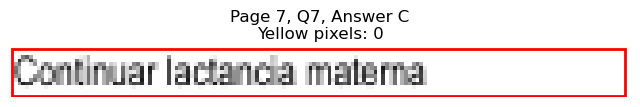

Page 7, Q7 - D: Detected box: x0=336.7, y0=554.9, x1=466.4, y1=567.0
Page 7, Q7, D: Yellow pixels: 0
Page 7, Q7, D: Total non-white pixels: 676
Page 7, Q7, D: Yellow percentage: 0.0%


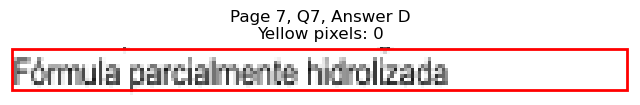

Page 7, Q7 - E: Detected box: x0=336.7, y0=567.1, x1=399.0, y1=579.2
Page 7, Q7, E: Yellow pixels: 0
Page 7, Q7, E: Total non-white pixels: 306
Page 7, Q7, E: Yellow percentage: 0.0%


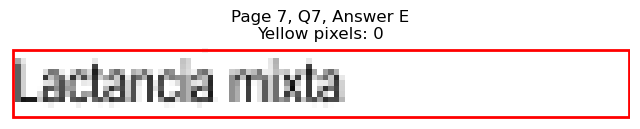


Page 7, Q7 - Selected Answer: B (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=85.0, y0=651.4, x1=241.0, y1=663.5
Page 7, Q8, A: Yellow pixels: 190
Page 7, Q8, A: Total non-white pixels: 994
Page 7, Q8, A: Yellow percentage: 19.1%


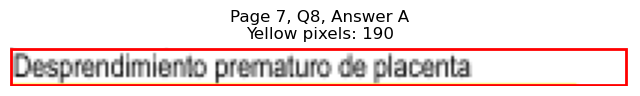

Page 7, Q8 - B: Detected box: x0=85.0, y0=663.4, x1=132.9, y1=675.5
Page 7, Q8, B: Yellow pixels: 1101
Page 7, Q8, B: Total non-white pixels: 1287
Page 7, Q8, B: Yellow percentage: 85.5%


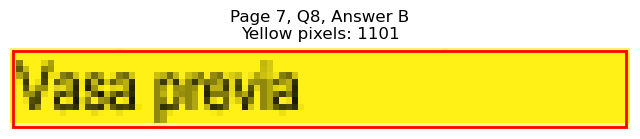

Page 7, Q8 - C: Detected box: x0=85.0, y0=675.4, x1=146.8, y1=687.5
Page 7, Q8, C: Yellow pixels: 113
Page 7, Q8, C: Total non-white pixels: 426
Page 7, Q8, C: Yellow percentage: 26.5%


Page 7, Q8 - D: Detected box: x0=336.7, y0=651.4, x1=398.5, y1=663.5
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 314
Page 7, Q8, D: Yellow percentage: 0.0%


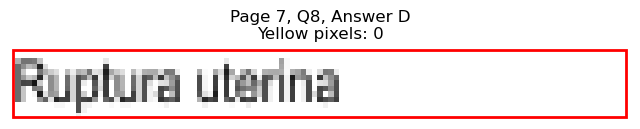

Page 7, Q8 - E: Detected box: x0=336.7, y0=663.4, x1=399.0, y1=675.5
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 315
Page 7, Q8, E: Yellow percentage: 0.0%


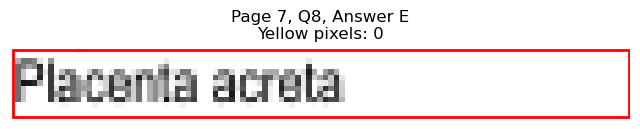


Page 7, Q8 - Selected Answer: B (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=85.0, y0=735.8, x1=174.0, y1=747.9
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 462
Page 7, Q9, A: Yellow percentage: 0.0%


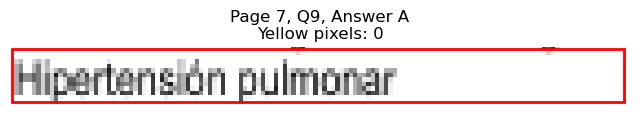

Page 7, Q9 - B: Detected box: x0=85.0, y0=747.8, x1=187.0, y1=759.9
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 689
Page 7, Q9, B: Yellow percentage: 0.0%


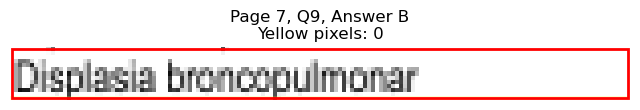

Page 7, Q9 - C: Detected box: x0=85.0, y0=759.8, x1=214.7, y1=771.9
Page 7, Q9, C: Yellow pixels: 1634
Page 7, Q9, C: Total non-white pixels: 2353
Page 7, Q9, C: Yellow percentage: 69.4%


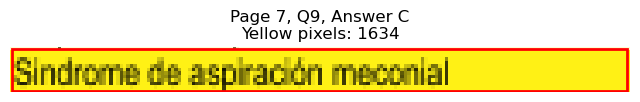

Page 7, Q9 - D: Detected box: x0=336.7, y0=735.8, x1=449.1, y1=747.9
Page 7, Q9, D: Yellow pixels: 0
Page 7, Q9, D: Total non-white pixels: 521
Page 7, Q9, D: Yellow percentage: 0.0%


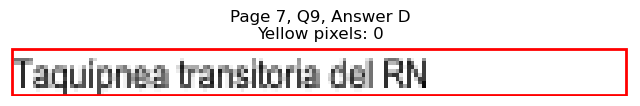

Page 7, Q9 - E: Detected box: x0=336.7, y0=747.8, x1=411.0, y1=759.9
Page 7, Q9, E: Yellow pixels: 0
Page 7, Q9, E: Total non-white pixels: 401
Page 7, Q9, E: Yellow percentage: 0.0%


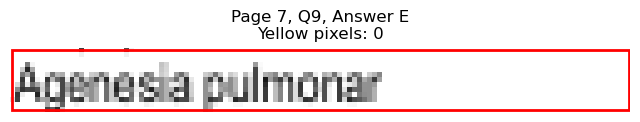


Page 7, Q9 - Selected Answer: C (based on yellow pixel count)





Page 8: Found 8 questions
Page 8, Q1 - A: Detected box: x0=85.0, y0=133.2, x1=223.9, y1=145.3
Page 8, Q1, A: Yellow pixels: 1718
Page 8, Q1, A: Total non-white pixels: 2470
Page 8, Q1, A: Yellow percentage: 69.6%


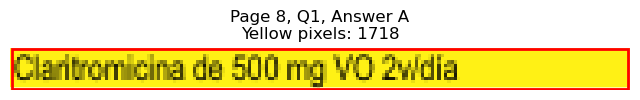

Page 8, Q1 - B: Detected box: x0=85.0, y0=145.3, x1=205.6, y1=157.4
Page 8, Q1, B: Yellow pixels: 2
Page 8, Q1, B: Total non-white pixels: 743
Page 8, Q1, B: Yellow percentage: 0.3%


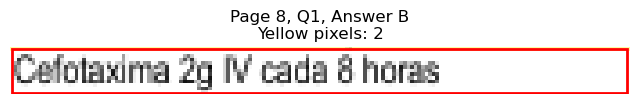

Page 8, Q1 - C: Detected box: x0=85.0, y0=157.3, x1=254.0, y1=169.4
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 863
Page 8, Q1, C: Yellow percentage: 0.0%


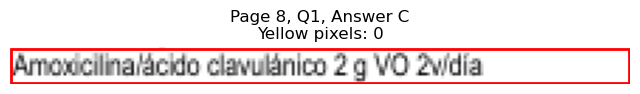

Page 8, Q1 - D: Detected box: x0=336.7, y0=133.2, x1=454.9, y1=145.3
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 597
Page 8, Q1, D: Yellow percentage: 0.0%


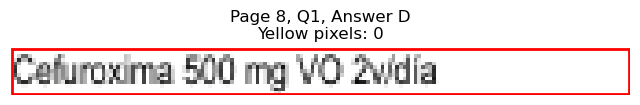

Page 8, Q1 - E: Detected box: x0=336.7, y0=145.3, x1=463.5, y1=157.4
Page 8, Q1, E: Yellow pixels: 0
Page 8, Q1, E: Total non-white pixels: 654
Page 8, Q1, E: Yellow percentage: 0.0%


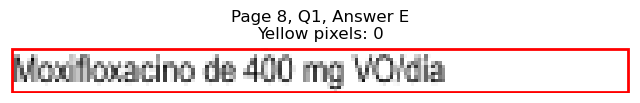


Page 8, Q1 - Selected Answer: A (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=85.0, y0=205.5, x1=209.5, y1=217.7
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 653
Page 8, Q2, A: Yellow percentage: 0.0%


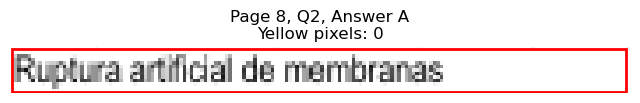

Page 8, Q2 - B: Detected box: x0=85.0, y0=217.5, x1=187.5, y1=229.7
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 509
Page 8, Q2, B: Yellow percentage: 0.0%


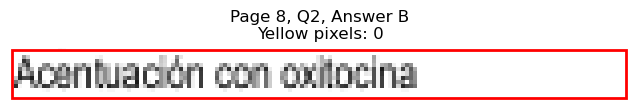

Page 8, Q2 - C: Detected box: x0=85.0, y0=229.7, x1=194.2, y1=241.8
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 551
Page 8, Q2, C: Yellow percentage: 0.0%


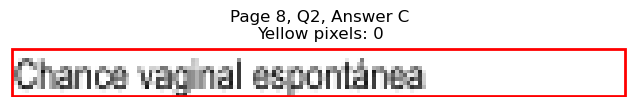

Page 8, Q2 - D: Detected box: x0=336.7, y0=205.5, x1=407.5, y1=217.7
Page 8, Q2, D: Yellow pixels: 1315
Page 8, Q2, D: Total non-white pixels: 1586
Page 8, Q2, D: Yellow percentage: 82.9%


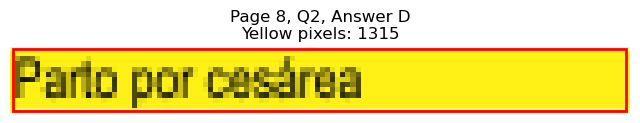

Page 8, Q2 - E: Detected box: x0=336.7, y0=217.5, x1=372.6, y1=229.7
Page 8, Q2, E: Yellow pixels: 87
Page 8, Q2, E: Total non-white pixels: 269
Page 8, Q2, E: Yellow percentage: 32.3%


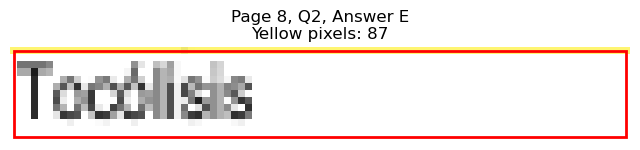


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=85.0, y0=277.8, x1=107.5, y1=289.9
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 82
Page 8, Q3, A: Yellow percentage: 0.0%


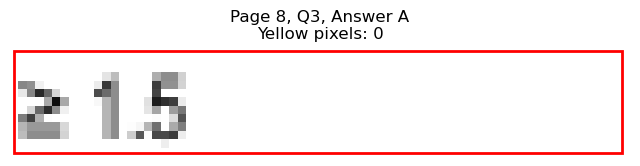

Page 8, Q3 - B: Detected box: x0=70.8, y0=289.9, x1=79.0, y1=302.0
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 71
Page 8, Q3, B: Yellow percentage: 0.0%


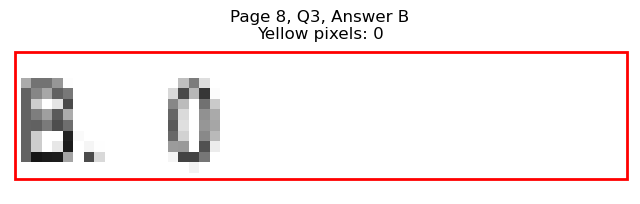

Page 8, Q3 - C: Detected box: x0=85.0, y0=301.9, x1=100.4, y1=314.0
Page 8, Q3, C: Yellow pixels: 67
Page 8, Q3, C: Total non-white pixels: 184
Page 8, Q3, C: Yellow percentage: 36.4%


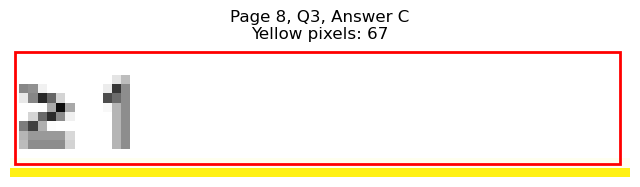

Page 8, Q3 - D: Detected box: x0=336.7, y0=277.8, x1=352.0, y1=289.9
Page 8, Q3, D: Yellow pixels: 0
Page 8, Q3, D: Total non-white pixels: 55
Page 8, Q3, D: Yellow percentage: 0.0%


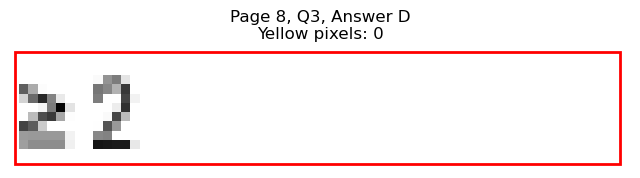

Page 8, Q3 - E: Detected box: x0=336.7, y0=289.9, x1=352.0, y1=302.0
Page 8, Q3, E: Yellow pixels: 760
Page 8, Q3, E: Total non-white pixels: 871
Page 8, Q3, E: Yellow percentage: 87.3%


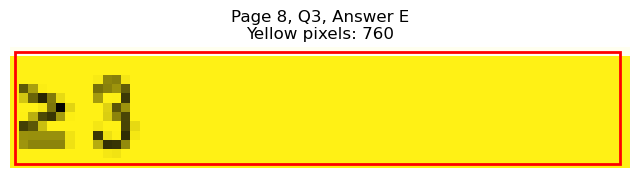


Page 8, Q3 - Selected Answer: E (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=85.0, y0=350.2, x1=170.2, y1=362.3
Page 8, Q4, A: Yellow pixels: 1286
Page 8, Q4, A: Total non-white pixels: 1781
Page 8, Q4, A: Yellow percentage: 72.2%


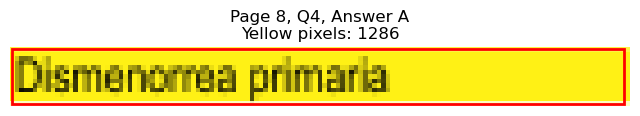

Page 8, Q4 - B: Detected box: x0=85.0, y0=362.2, x1=181.2, y1=374.3
Page 8, Q4, B: Yellow pixels: 0
Page 8, Q4, B: Total non-white pixels: 635
Page 8, Q4, B: Yellow percentage: 0.0%


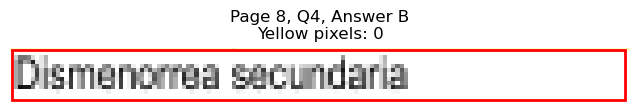

Page 8, Q4 - C: Detected box: x0=85.0, y0=374.2, x1=140.5, y1=386.3
Page 8, Q4, C: Yellow pixels: 0
Page 8, Q4, C: Total non-white pixels: 307
Page 8, Q4, C: Yellow percentage: 0.0%


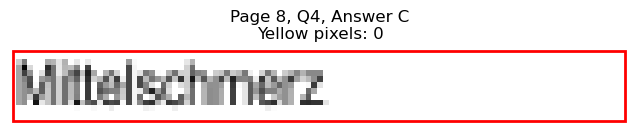

Page 8, Q4 - D: Detected box: x0=336.7, y0=350.2, x1=393.7, y1=362.3
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 307
Page 8, Q4, D: Yellow percentage: 0.0%


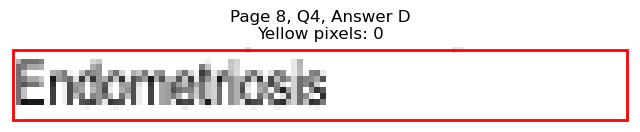

Page 8, Q4 - E: Detected box: x0=336.7, y0=362.2, x1=388.4, y1=374.3
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 265
Page 8, Q4, E: Yellow percentage: 0.0%


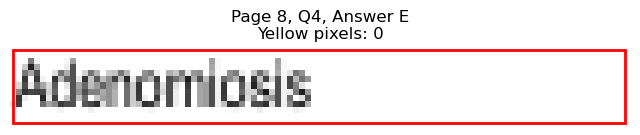


Page 8, Q4 - Selected Answer: A (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=85.0, y0=434.4, x1=166.3, y1=446.5
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 420
Page 8, Q5, A: Yellow percentage: 0.0%


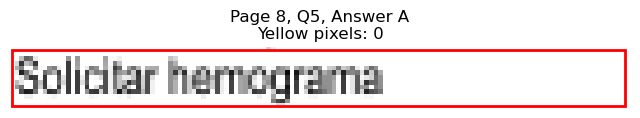

Page 8, Q5 - B: Detected box: x0=85.0, y0=446.6, x1=194.2, y1=458.7
Page 8, Q5, B: Yellow pixels: 161
Page 8, Q5, B: Total non-white pixels: 762
Page 8, Q5, B: Yellow percentage: 21.1%


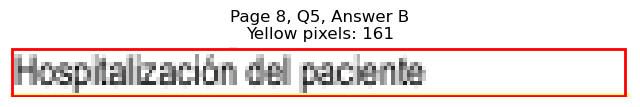

Page 8, Q5 - C: Detected box: x0=85.0, y0=458.6, x1=173.1, y1=470.7
Page 8, Q5, C: Yellow pixels: 1452
Page 8, Q5, C: Total non-white pixels: 1820
Page 8, Q5, C: Yellow percentage: 79.8%


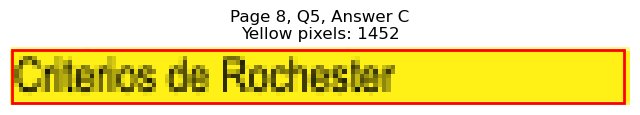

Page 8, Q5 - D: Detected box: x0=336.7, y0=434.4, x1=457.3, y1=446.5
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 586
Page 8, Q5, D: Yellow percentage: 0.0%


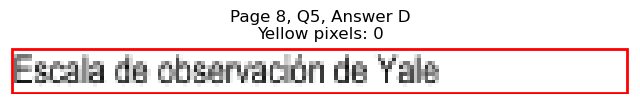

Page 8, Q5 - E: Detected box: x0=336.7, y0=446.6, x1=434.8, y1=458.7
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 507
Page 8, Q5, E: Yellow percentage: 0.0%


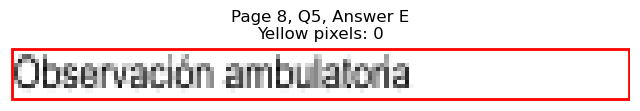


Page 8, Q5 - Selected Answer: C (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=85.0, y0=530.9, x1=195.2, y1=543.0
Page 8, Q6, A: Yellow pixels: 1488
Page 8, Q6, A: Total non-white pixels: 2109
Page 8, Q6, A: Yellow percentage: 70.6%


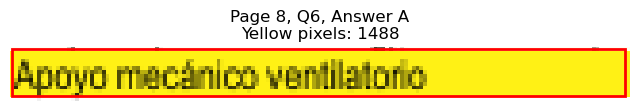

Page 8, Q6 - B: Detected box: x0=85.0, y0=542.9, x1=209.0, y1=555.0
Page 8, Q6, B: Yellow pixels: 171
Page 8, Q6, B: Total non-white pixels: 816
Page 8, Q6, B: Yellow percentage: 21.0%


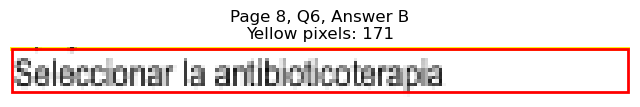

Page 8, Q6 - C: Detected box: x0=85.0, y0=554.9, x1=178.8, y1=567.0
Page 8, Q6, C: Yellow pixels: 0
Page 8, Q6, C: Total non-white pixels: 451
Page 8, Q6, C: Yellow percentage: 0.0%


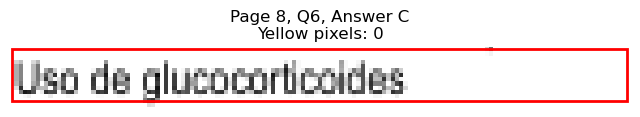

Page 8, Q6 - D: Detected box: x0=336.7, y0=530.9, x1=459.2, y1=543.0
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 620
Page 8, Q6, D: Yellow percentage: 0.0%


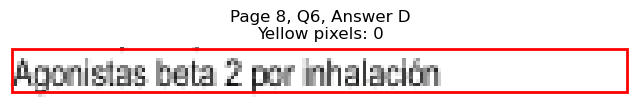

Page 8, Q6 - E: Detected box: x0=336.7, y0=542.9, x1=438.7, y1=555.0
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 505
Page 8, Q6, E: Yellow percentage: 0.0%


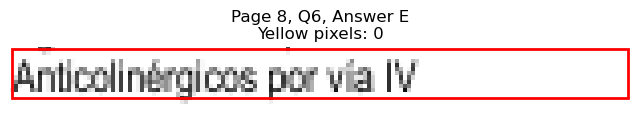


Page 8, Q6 - Selected Answer: A (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=85.0, y0=603.2, x1=192.3, y1=615.3
Page 8, Q7, A: Yellow pixels: 159
Page 8, Q7, A: Total non-white pixels: 707
Page 8, Q7, A: Yellow percentage: 22.5%


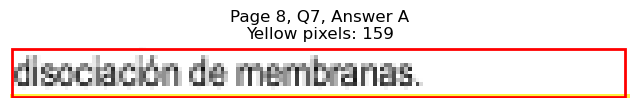

Page 8, Q7 - B: Detected box: x0=85.0, y0=615.2, x1=152.9, y1=627.3
Page 8, Q7, B: Yellow pixels: 1154
Page 8, Q7, B: Total non-white pixels: 1547
Page 8, Q7, B: Yellow percentage: 74.6%


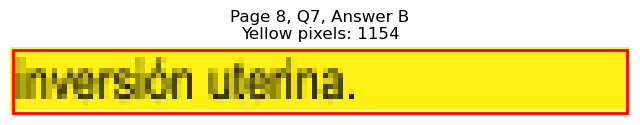

Page 8, Q7 - C: Detected box: x0=85.0, y0=627.3, x1=145.8, y1=639.4
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 392
Page 8, Q7, C: Yellow percentage: 0.0%


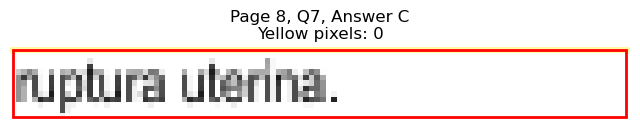

Page 8, Q7 - D: Detected box: x0=336.7, y0=603.2, x1=421.4, y1=615.3
Page 8, Q7, D: Yellow pixels: 0
Page 8, Q7, D: Total non-white pixels: 429
Page 8, Q7, D: Yellow percentage: 0.0%


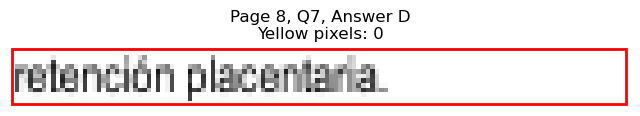

Page 8, Q7 - E: Detected box: x0=336.7, y0=615.2, x1=394.2, y1=627.3
Page 8, Q7, E: Yellow pixels: 0
Page 8, Q7, E: Total non-white pixels: 273
Page 8, Q7, E: Yellow percentage: 0.0%


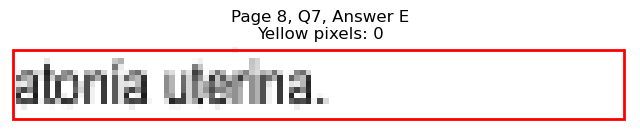


Page 8, Q7 - Selected Answer: B (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=85.0, y0=699.5, x1=130.0, y1=711.7
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 231
Page 8, Q8, A: Yellow percentage: 0.0%


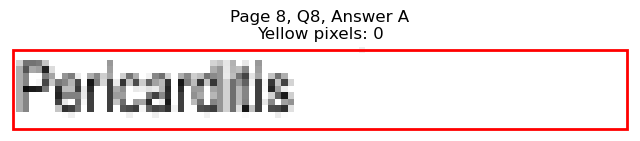

Page 8, Q8 - B: Detected box: x0=85.0, y0=711.7, x1=172.6, y1=723.8
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 562
Page 8, Q8, B: Yellow percentage: 0.0%


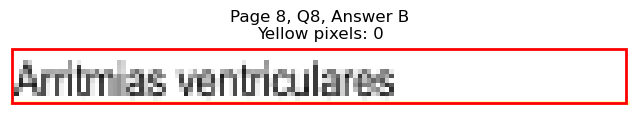

Page 8, Q8 - C: Detected box: x0=85.0, y0=723.7, x1=169.7, y1=735.8
Page 8, Q8, C: Yellow pixels: 1306
Page 8, Q8, C: Total non-white pixels: 1768
Page 8, Q8, C: Yellow percentage: 73.9%


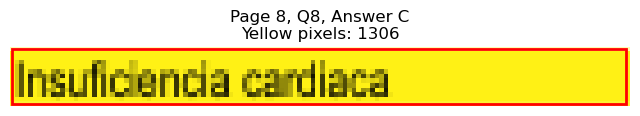

Page 8, Q8 - D: Detected box: x0=336.7, y0=699.5, x1=417.1, y1=711.7
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 423
Page 8, Q8, D: Yellow percentage: 0.0%


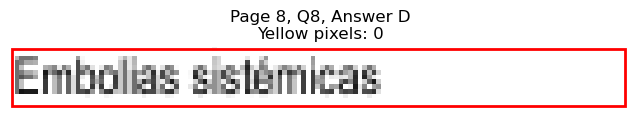

Page 8, Q8 - E: Detected box: x0=336.7, y0=711.7, x1=433.5, y1=723.8
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 500
Page 8, Q8, E: Yellow percentage: 0.0%


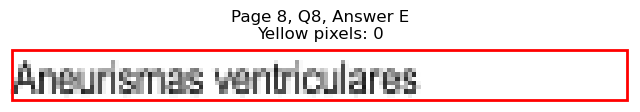


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=85.0, y0=145.3, x1=155.4, y1=157.4
Page 9, Q1, A: Yellow pixels: 0
Page 9, Q1, A: Total non-white pixels: 378
Page 9, Q1, A: Yellow percentage: 0.0%


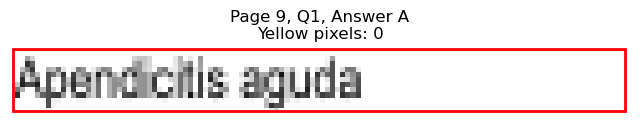

Page 9, Q1 - B: Detected box: x0=85.0, y0=157.3, x1=157.2, y1=169.4
Page 9, Q1, B: Yellow pixels: 0
Page 9, Q1, B: Total non-white pixels: 403
Page 9, Q1, B: Yellow percentage: 0.0%


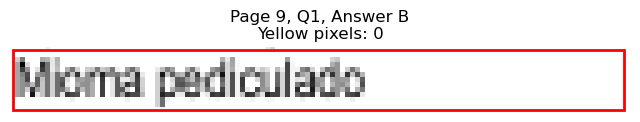

Page 9, Q1 - C: Detected box: x0=85.0, y0=169.4, x1=178.3, y1=181.5
Page 9, Q1, C: Yellow pixels: 145
Page 9, Q1, C: Total non-white pixels: 614
Page 9, Q1, C: Yellow percentage: 23.6%


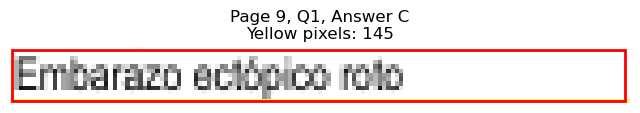

Page 9, Q1 - D: Detected box: x0=336.7, y0=145.3, x1=421.9, y1=157.4
Page 9, Q1, D: Yellow pixels: 136
Page 9, Q1, D: Total non-white pixels: 542
Page 9, Q1, D: Yellow percentage: 25.1%


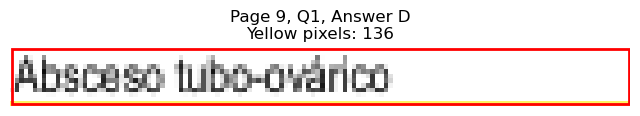

Page 9, Q1 - E: Detected box: x0=336.7, y0=157.3, x1=464.0, y1=169.4
Page 9, Q1, E: Yellow pixels: 1833
Page 9, Q1, E: Total non-white pixels: 2327
Page 9, Q1, E: Yellow percentage: 78.8%


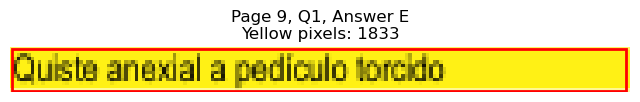


Page 9, Q1 - Selected Answer: E (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=85.0, y0=217.5, x1=118.0, y1=229.7
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 185
Page 9, Q2, A: Yellow percentage: 0.0%


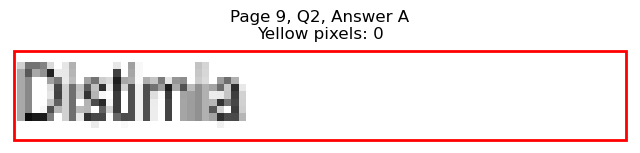

Page 9, Q2 - B: Detected box: x0=85.0, y0=229.7, x1=157.2, y1=241.8
Page 9, Q2, B: Yellow pixels: 0
Page 9, Q2, B: Total non-white pixels: 369
Page 9, Q2, B: Yellow percentage: 0.0%


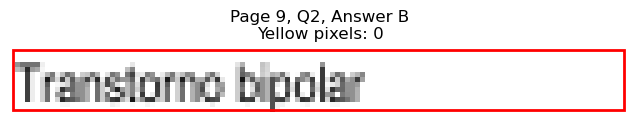

Page 9, Q2 - C: Detected box: x0=85.0, y0=470.7, x1=123.4, y1=482.8
Page 9, Q2, C: Yellow pixels: 1
Page 9, Q2, C: Total non-white pixels: 568
Page 9, Q2, C: Yellow percentage: 0.2%


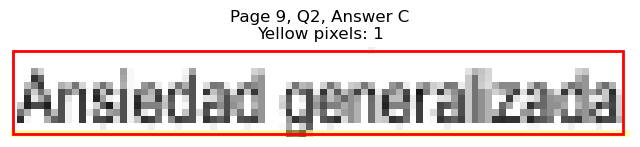

Page 9, Q2 - D: Detected box: x0=336.7, y0=217.5, x1=404.6, y1=229.7
Page 9, Q2, D: Yellow pixels: 1279
Page 9, Q2, D: Total non-white pixels: 1547
Page 9, Q2, D: Yellow percentage: 82.7%


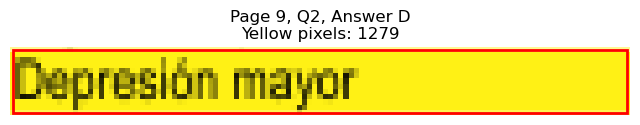

Page 9, Q2 - E: Detected box: x0=336.7, y0=229.7, x1=370.2, y1=241.8
Page 9, Q2, E: Yellow pixels: 85
Page 9, Q2, E: Total non-white pixels: 249
Page 9, Q2, E: Yellow percentage: 34.1%


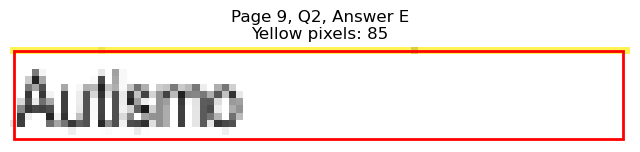


Page 9, Q2 - Selected Answer: D (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=85.0, y0=313.9, x1=197.5, y1=326.0
Page 9, Q3, A: Yellow pixels: 1491
Page 9, Q3, A: Total non-white pixels: 2296
Page 9, Q3, A: Yellow percentage: 64.9%


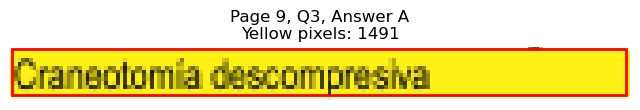

Page 9, Q3 - B: Detected box: x0=85.0, y0=326.1, x1=199.9, y1=338.2
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 742
Page 9, Q3, B: Yellow percentage: 0.0%


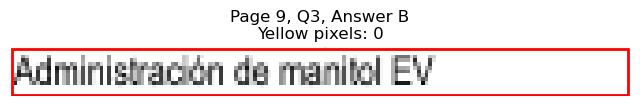

Page 9, Q3 - C: Detected box: x0=85.0, y0=338.1, x1=226.3, y1=350.2
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 702
Page 9, Q3, C: Yellow percentage: 0.0%


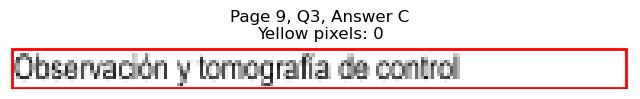

Page 9, Q3 - D: Detected box: x0=336.7, y0=313.9, x1=431.0, y1=326.0
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 510
Page 9, Q3, D: Yellow percentage: 0.0%


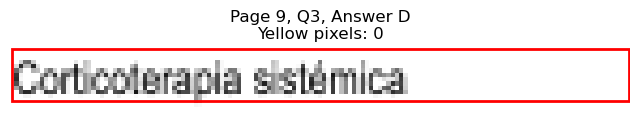

Page 9, Q3 - E: Detected box: x0=336.7, y0=326.1, x1=422.8, y1=338.2
Page 9, Q3, E: Yellow pixels: 0
Page 9, Q3, E: Total non-white pixels: 460
Page 9, Q3, E: Yellow percentage: 0.0%


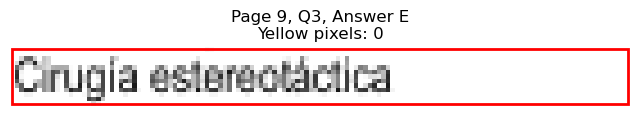


Page 9, Q3 - Selected Answer: A (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=85.0, y0=374.2, x1=275.2, y1=386.3
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 992
Page 9, Q4, A: Yellow percentage: 0.0%


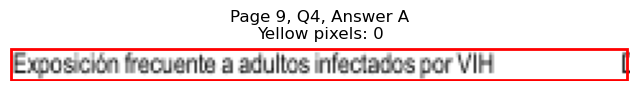

Page 9, Q4 - B: Detected box: x0=85.0, y0=386.3, x1=275.2, y1=398.4
Page 9, Q4, B: Yellow pixels: 42
Page 9, Q4, B: Total non-white pixels: 979
Page 9, Q4, B: Yellow percentage: 4.3%


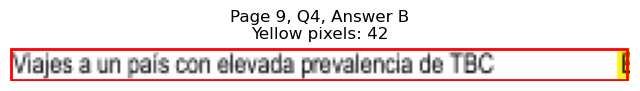

Page 9, Q4 - C: Detected box: x0=85.0, y0=398.3, x1=180.3, y1=410.4
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 509
Page 9, Q4, C: Yellow percentage: 0.0%


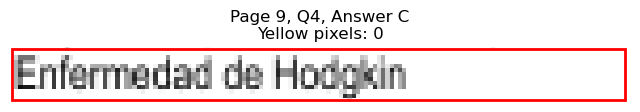

Page 9, Q4 - D: Detected box: x0=336.7, y0=374.2, x1=454.9, y1=386.3
Page 9, Q4, D: Yellow pixels: 0
Page 9, Q4, D: Total non-white pixels: 597
Page 9, Q4, D: Yellow percentage: 0.0%


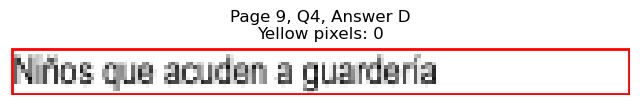

Page 9, Q4 - E: Detected box: x0=336.7, y0=386.3, x1=441.1, y1=398.4
Page 9, Q4, E: Yellow pixels: 1453
Page 9, Q4, E: Total non-white pixels: 2028
Page 9, Q4, E: Yellow percentage: 71.6%


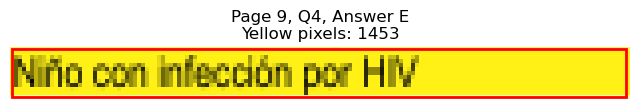


Page 9, Q4 - Selected Answer: E (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=85.0, y0=446.6, x1=161.5, y1=458.7
Page 9, Q5, A: Yellow pixels: 0
Page 9, Q5, A: Total non-white pixels: 374
Page 9, Q5, A: Yellow percentage: 0.0%


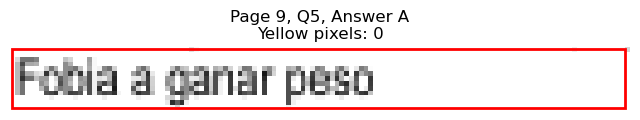

Page 9, Q5 - B: Detected box: x0=85.0, y0=229.7, x1=157.2, y1=241.8
Page 9, Q5, B: Yellow pixels: 0
Page 9, Q5, B: Total non-white pixels: 369
Page 9, Q5, B: Yellow percentage: 0.0%


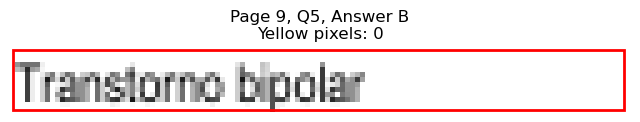

Page 9, Q5 - C: Detected box: x0=85.0, y0=470.7, x1=175.0, y1=482.8
Page 9, Q5, C: Yellow pixels: 1
Page 9, Q5, C: Total non-white pixels: 619
Page 9, Q5, C: Yellow percentage: 0.2%


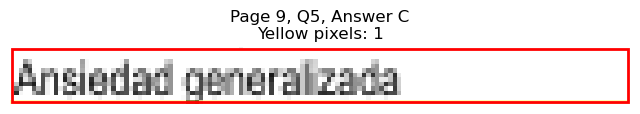

Page 9, Q5 - D: Detected box: x0=336.7, y0=446.6, x1=355.9, y1=458.7
Page 9, Q5, D: Yellow pixels: 70
Page 9, Q5, D: Total non-white pixels: 158
Page 9, Q5, D: Yellow percentage: 44.3%


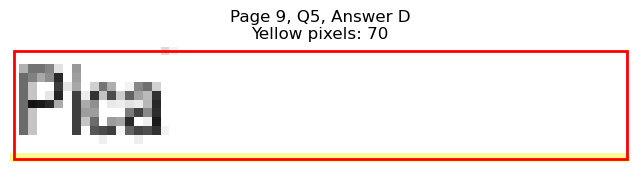

Page 9, Q5 - E: Detected box: x0=336.7, y0=458.6, x1=400.4, y1=470.7
Page 9, Q5, E: Yellow pixels: 1225
Page 9, Q5, E: Total non-white pixels: 1495
Page 9, Q5, E: Yellow percentage: 81.9%


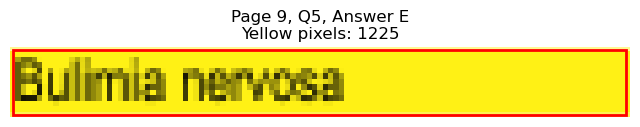


Page 9, Q5 - Selected Answer: E (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=85.0, y0=506.8, x1=135.3, y1=518.9
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 290
Page 9, Q6, A: Yellow percentage: 0.0%


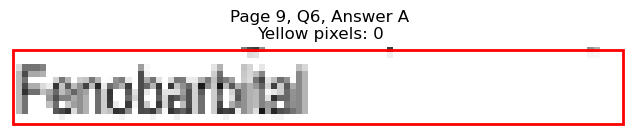

Page 9, Q6 - B: Detected box: x0=85.0, y0=518.8, x1=135.7, y1=530.9
Page 9, Q6, B: Yellow pixels: 0
Page 9, Q6, B: Total non-white pixels: 258
Page 9, Q6, B: Yellow percentage: 0.0%


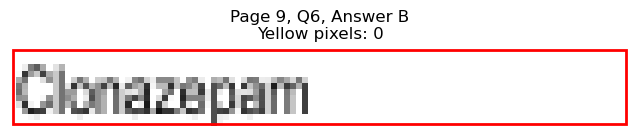

Page 9, Q6 - C: Detected box: x0=85.0, y0=530.9, x1=134.3, y1=543.0
Page 9, Q6, C: Yellow pixels: 999
Page 9, Q6, C: Total non-white pixels: 1313
Page 9, Q6, C: Yellow percentage: 76.1%


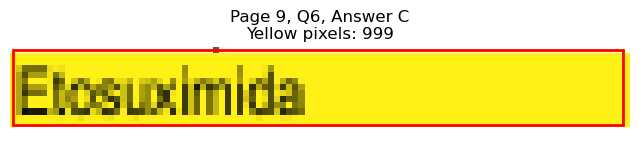

Page 9, Q6 - D: Detected box: x0=336.7, y0=506.8, x1=375.0, y1=518.9
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 194
Page 9, Q6, D: Yellow percentage: 0.0%


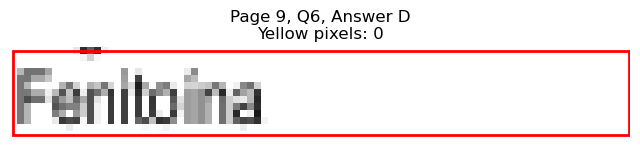

Page 9, Q6 - E: Detected box: x0=336.7, y0=518.8, x1=399.9, y1=530.9
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 330
Page 9, Q6, E: Yellow percentage: 0.0%


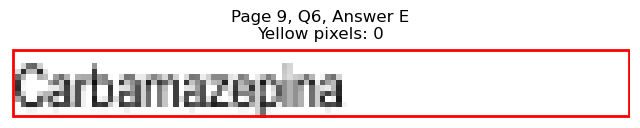


Page 9, Q6 - Selected Answer: C (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=85.0, y0=591.2, x1=133.8, y1=603.3
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 237
Page 9, Q7, A: Yellow percentage: 0.0%


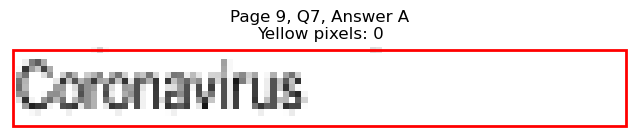

Page 9, Q7 - B: Detected box: x0=85.0, y0=603.2, x1=147.3, y1=615.3
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 304
Page 9, Q7, B: Yellow percentage: 0.0%


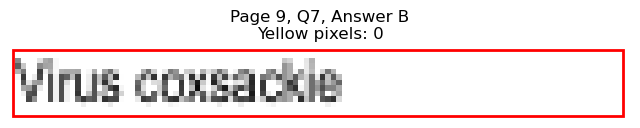

Page 9, Q7 - C: Detected box: x0=85.0, y0=615.2, x1=135.7, y1=627.3
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 242
Page 9, Q7, C: Yellow percentage: 0.0%


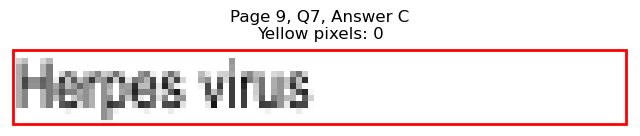

Page 9, Q7 - D: Detected box: x0=336.7, y0=591.2, x1=382.2, y1=603.3
Page 9, Q7, D: Yellow pixels: 980
Page 9, Q7, D: Total non-white pixels: 1261
Page 9, Q7, D: Yellow percentage: 77.7%


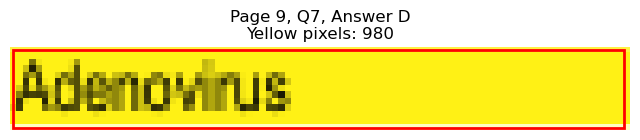

Page 9, Q7 - E: Detected box: x0=336.7, y0=603.2, x1=382.6, y1=615.3
Page 9, Q7, E: Yellow pixels: 0
Page 9, Q7, E: Total non-white pixels: 315
Page 9, Q7, E: Yellow percentage: 0.0%


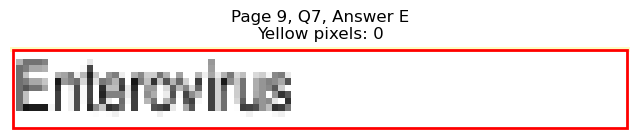


Page 9, Q7 - Selected Answer: D (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=85.0, y0=651.4, x1=177.9, y1=663.5
Page 9, Q8, A: Yellow pixels: 0
Page 9, Q8, A: Total non-white pixels: 477
Page 9, Q8, A: Yellow percentage: 0.0%


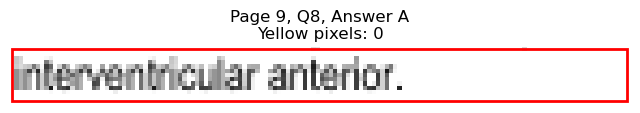

Page 9, Q8 - B: Detected box: x0=85.0, y0=663.4, x1=156.3, y1=675.5
Page 9, Q8, B: Yellow pixels: 123
Page 9, Q8, B: Total non-white pixels: 486
Page 9, Q8, B: Yellow percentage: 25.3%


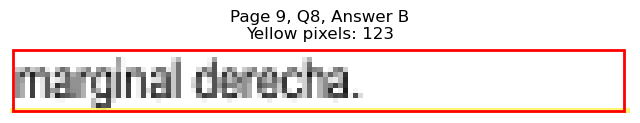

Page 9, Q8 - C: Detected box: x0=85.0, y0=675.4, x1=159.1, y1=687.5
Page 9, Q8, C: Yellow pixels: 1347
Page 9, Q8, C: Total non-white pixels: 1638
Page 9, Q8, C: Yellow percentage: 82.2%


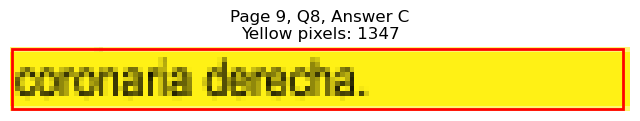

Page 9, Q8 - D: Detected box: x0=336.7, y0=651.4, x1=411.8, y1=663.5
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 405
Page 9, Q8, D: Yellow percentage: 0.0%


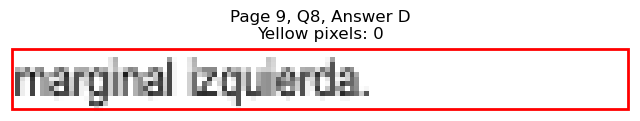

Page 9, Q8 - E: Detected box: x0=336.7, y0=663.4, x1=412.8, y1=675.5
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 366
Page 9, Q8, E: Yellow percentage: 0.0%


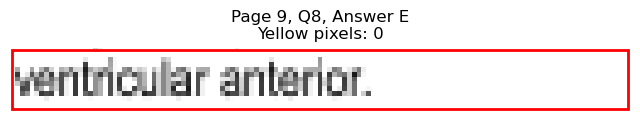


Page 9, Q8 - Selected Answer: C (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=85.0, y0=711.7, x1=129.0, y1=723.8
Page 9, Q9, A: Yellow pixels: 0
Page 9, Q9, A: Total non-white pixels: 318
Page 9, Q9, A: Yellow percentage: 0.0%


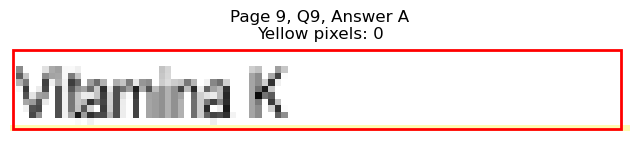

Page 9, Q9 - B: Detected box: x0=85.0, y0=723.7, x1=119.4, y1=735.8
Page 9, Q9, B: Yellow pixels: 893
Page 9, Q9, B: Total non-white pixels: 1118
Page 9, Q9, B: Yellow percentage: 79.9%


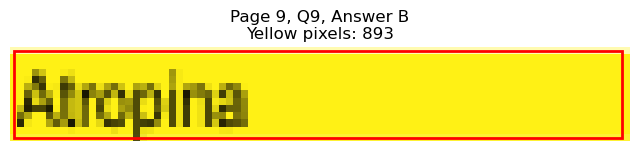

Page 9, Q9 - C: Detected box: x0=85.0, y0=735.8, x1=129.0, y1=747.9
Page 9, Q9, C: Yellow pixels: 95
Page 9, Q9, C: Total non-white pixels: 334
Page 9, Q9, C: Yellow percentage: 28.4%


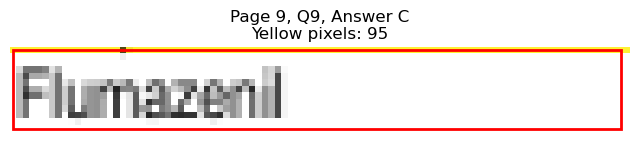

Page 9, Q9 - D: Detected box: x0=336.7, y0=711.7, x1=389.8, y1=723.8
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 289
Page 9, Q9, D: Yellow percentage: 0.0%


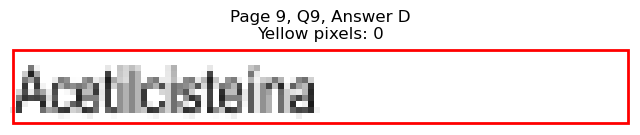

Page 9, Q9 - E: Detected box: x0=336.7, y0=723.7, x1=401.8, y1=735.8
Page 9, Q9, E: Yellow pixels: 0
Page 9, Q9, E: Total non-white pixels: 326
Page 9, Q9, E: Yellow percentage: 0.0%


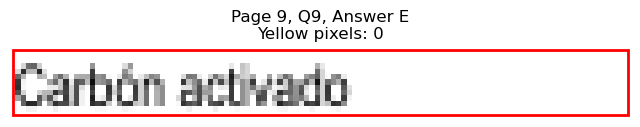


Page 9, Q9 - Selected Answer: B (based on yellow pixel count)





Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=70.8, y0=109.2, x1=79.0, y1=121.3
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 67
Page 10, Q1, A: Yellow percentage: 0.0%


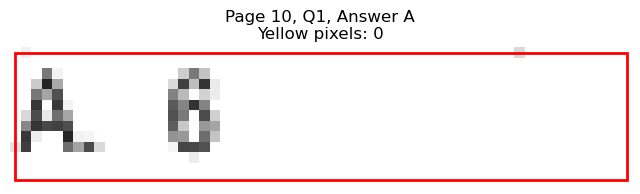

Page 10, Q1 - B: Detected box: x0=85.0, y0=121.2, x1=97.0, y1=133.3
Page 10, Q1, B: Yellow pixels: 63
Page 10, Q1, B: Total non-white pixels: 110
Page 10, Q1, B: Yellow percentage: 57.3%


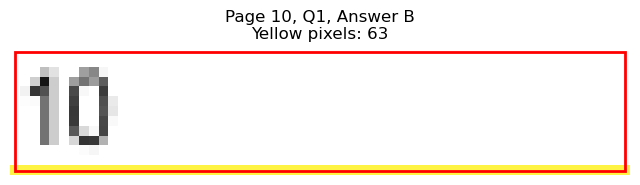

Page 10, Q1 - C: Detected box: x0=70.8, y0=133.2, x1=79.5, y1=145.3
Page 10, Q1, C: Yellow pixels: 672
Page 10, Q1, C: Total non-white pixels: 780
Page 10, Q1, C: Yellow percentage: 86.2%


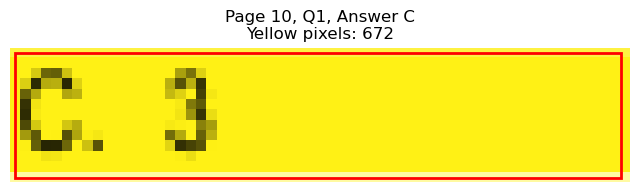

Page 10, Q1 - D: Detected box: x0=336.7, y0=109.2, x1=348.7, y1=121.3
Page 10, Q1, D: Yellow pixels: 0
Page 10, Q1, D: Total non-white pixels: 37
Page 10, Q1, D: Yellow percentage: 0.0%


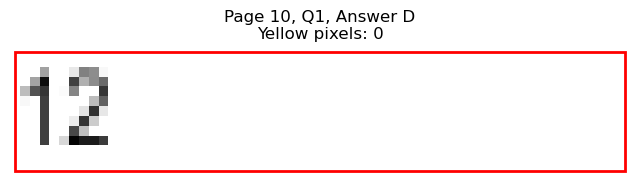

Page 10, Q1 - E: Detected box: x0=322.5, y0=121.2, x1=330.7, y1=133.3
Page 10, Q1, E: Yellow pixels: 0
Page 10, Q1, E: Total non-white pixels: 60
Page 10, Q1, E: Yellow percentage: 0.0%


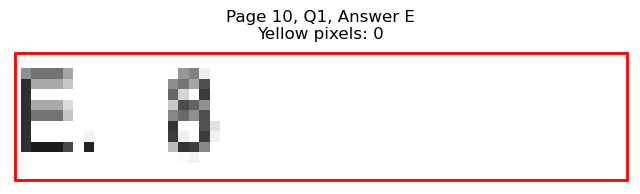


Page 10, Q1 - Selected Answer: C (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=85.0, y0=169.4, x1=126.1, y1=181.5
Page 10, Q2, A: Yellow pixels: 1026
Page 10, Q2, A: Total non-white pixels: 1209
Page 10, Q2, A: Yellow percentage: 84.9%


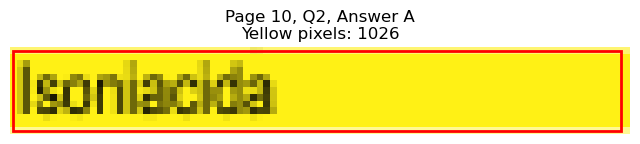

Page 10, Q2 - B: Detected box: x0=85.0, y0=181.4, x1=132.4, y1=193.5
Page 10, Q2, B: Yellow pixels: 99
Page 10, Q2, B: Total non-white pixels: 348
Page 10, Q2, B: Yellow percentage: 28.4%


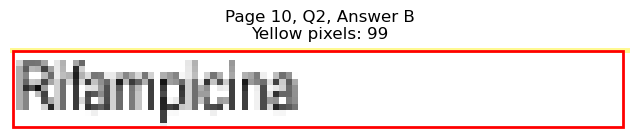

Page 10, Q2 - C: Detected box: x0=85.0, y0=193.4, x1=126.1, y1=205.5
Page 10, Q2, C: Yellow pixels: 0
Page 10, Q2, C: Total non-white pixels: 233
Page 10, Q2, C: Yellow percentage: 0.0%


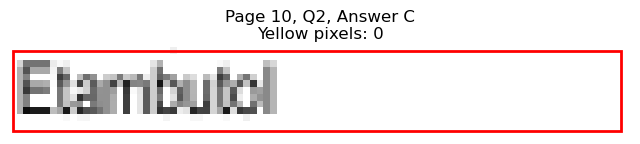

Page 10, Q2 - D: Detected box: x0=336.7, y0=169.4, x1=388.9, y1=181.5
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 276
Page 10, Q2, D: Yellow percentage: 0.0%


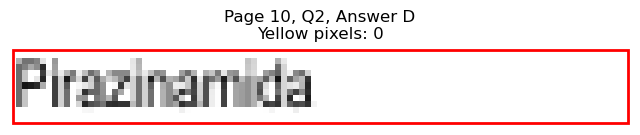

Page 10, Q2 - E: Detected box: x0=336.7, y0=181.4, x1=396.1, y1=193.5
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 329
Page 10, Q2, E: Yellow percentage: 0.0%


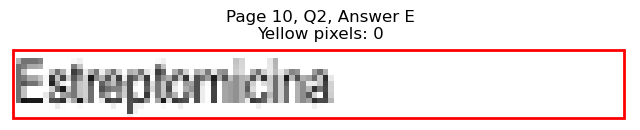


Page 10, Q2 - Selected Answer: A (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=85.0, y0=253.7, x1=229.6, y1=265.8
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 714
Page 10, Q3, A: Yellow percentage: 0.0%


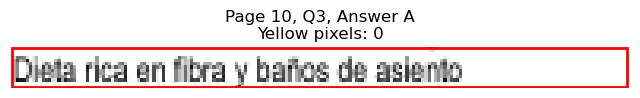

Page 10, Q3 - B: Detected box: x0=85.0, y0=265.8, x1=175.5, y1=277.9
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 472
Page 10, Q3, B: Yellow percentage: 0.0%


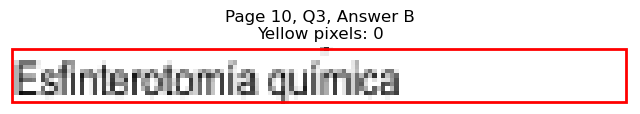

Page 10, Q3 - C: Detected box: x0=85.0, y0=277.8, x1=199.9, y1=289.9
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 598
Page 10, Q3, C: Yellow percentage: 0.0%


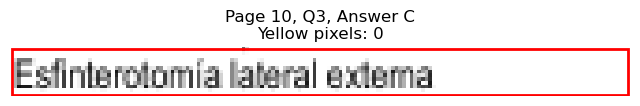

Page 10, Q3 - D: Detected box: x0=336.7, y0=253.7, x1=449.1, y1=265.8
Page 10, Q3, D: Yellow pixels: 1493
Page 10, Q3, D: Total non-white pixels: 2132
Page 10, Q3, D: Yellow percentage: 70.0%


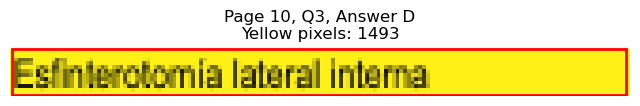

Page 10, Q3 - E: Detected box: x0=336.7, y0=265.8, x1=384.6, y1=277.9
Page 10, Q3, E: Yellow pixels: 99
Page 10, Q3, E: Total non-white pixels: 346
Page 10, Q3, E: Yellow percentage: 28.6%


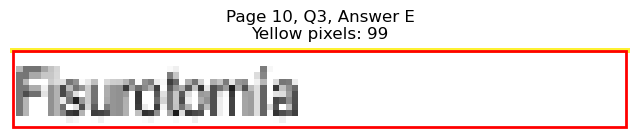


Page 10, Q3 - Selected Answer: D (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=85.0, y0=338.1, x1=226.3, y1=350.2
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 693
Page 10, Q4, A: Yellow percentage: 0.0%


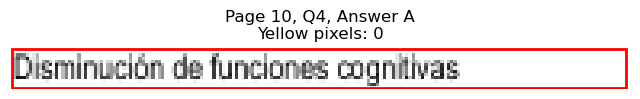

Page 10, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=169.2, y1=362.3
Page 10, Q4, B: Yellow pixels: 1306
Page 10, Q4, B: Total non-white pixels: 1768
Page 10, Q4, B: Yellow percentage: 73.9%


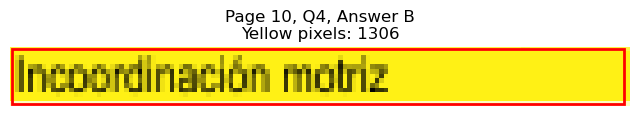

Page 10, Q4 - C: Detected box: x0=85.0, y0=362.2, x1=192.8, y1=374.3
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 704
Page 10, Q4, C: Yellow percentage: 0.0%


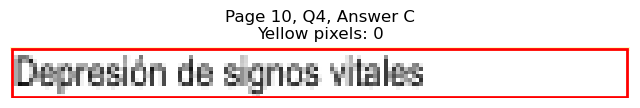

Page 10, Q4 - D: Detected box: x0=336.7, y0=338.1, x1=424.3, y1=350.2
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 463
Page 10, Q4, D: Yellow percentage: 0.0%


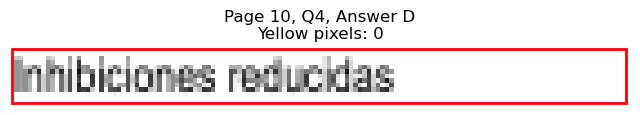

Page 10, Q4 - E: Detected box: x0=336.7, y0=350.2, x1=380.2, y1=362.3
Page 10, Q4, E: Yellow pixels: 0
Page 10, Q4, E: Total non-white pixels: 208
Page 10, Q4, E: Yellow percentage: 0.0%


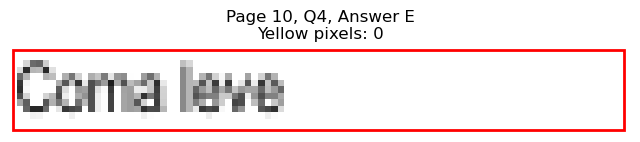


Page 10, Q4 - Selected Answer: B (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=85.0, y0=398.3, x1=150.1, y1=410.4
Page 10, Q5, A: Yellow pixels: 0
Page 10, Q5, A: Total non-white pixels: 317
Page 10, Q5, A: Yellow percentage: 0.0%


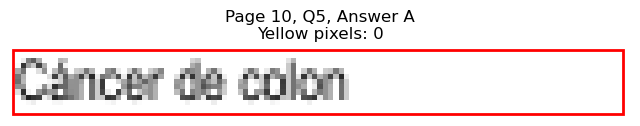

Page 10, Q5 - B: Detected box: x0=85.0, y0=410.4, x1=144.9, y1=422.5
Page 10, Q5, B: Yellow pixels: 0
Page 10, Q5, B: Total non-white pixels: 305
Page 10, Q5, B: Yellow percentage: 0.0%


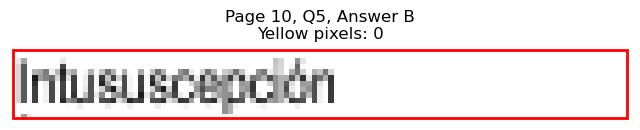

Page 10, Q5 - C: Detected box: x0=85.0, y0=422.4, x1=121.8, y1=434.5
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 200
Page 10, Q5, C: Yellow percentage: 0.0%


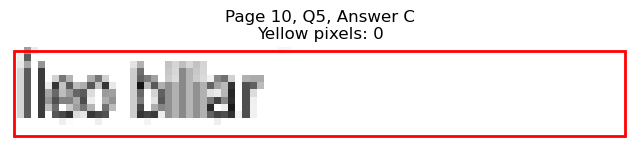

Page 10, Q5 - D: Detected box: x0=336.7, y0=398.3, x1=419.5, y1=410.4
Page 10, Q5, D: Yellow pixels: 1377
Page 10, Q5, D: Total non-white pixels: 1742
Page 10, Q5, D: Yellow percentage: 79.0%


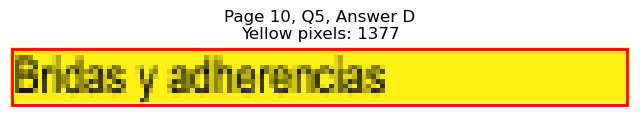

Page 10, Q5 - E: Detected box: x0=336.7, y0=410.4, x1=420.4, y1=422.5
Page 10, Q5, E: Yellow pixels: 135
Page 10, Q5, E: Total non-white pixels: 559
Page 10, Q5, E: Yellow percentage: 24.2%


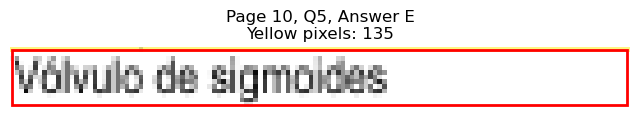


Page 10, Q5 - Selected Answer: D (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=85.0, y0=458.6, x1=122.8, y1=470.7
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 208
Page 10, Q6, A: Yellow percentage: 0.0%


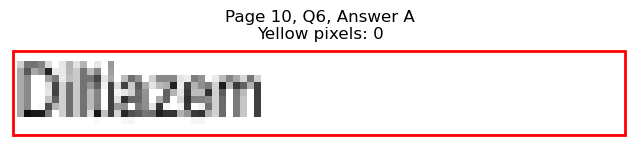

Page 10, Q6 - B: Detected box: x0=85.0, y0=470.7, x1=130.9, y1=482.8
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 240
Page 10, Q6, B: Yellow percentage: 0.0%


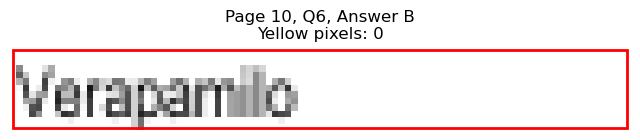

Page 10, Q6 - C: Detected box: x0=85.0, y0=482.7, x1=140.5, y1=494.8
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 393
Page 10, Q6, C: Yellow percentage: 0.0%


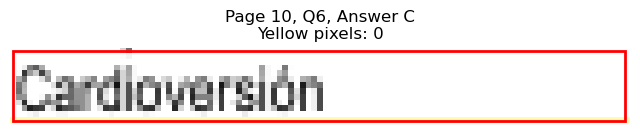

Page 10, Q6 - D: Detected box: x0=336.7, y0=458.6, x1=379.3, y1=470.7
Page 10, Q6, D: Yellow pixels: 0
Page 10, Q6, D: Total non-white pixels: 240
Page 10, Q6, D: Yellow percentage: 0.0%


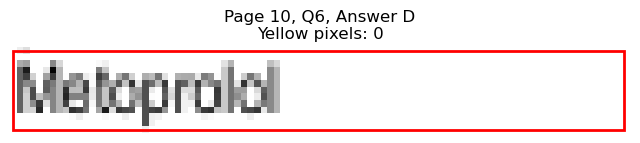

Page 10, Q6 - E: Detected box: x0=336.7, y0=470.7, x1=372.6, y1=482.8
Page 10, Q6, E: Yellow pixels: 896
Page 10, Q6, E: Total non-white pixels: 1131
Page 10, Q6, E: Yellow percentage: 79.2%


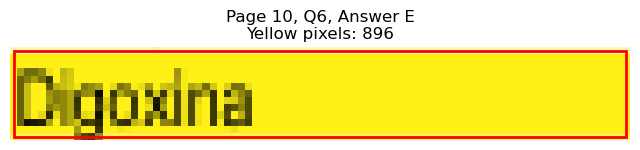


Page 10, Q6 - Selected Answer: E (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=85.0, y0=542.9, x1=127.6, y1=555.0
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 245
Page 10, Q7, A: Yellow percentage: 0.0%


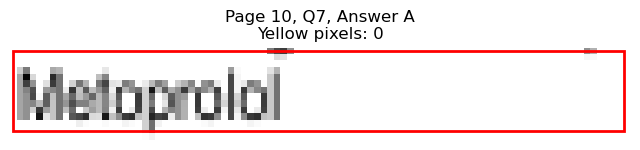

Page 10, Q7 - B: Detected box: x0=85.0, y0=554.9, x1=129.5, y1=567.0
Page 10, Q7, B: Yellow pixels: 0
Page 10, Q7, B: Total non-white pixels: 225
Page 10, Q7, B: Yellow percentage: 0.0%


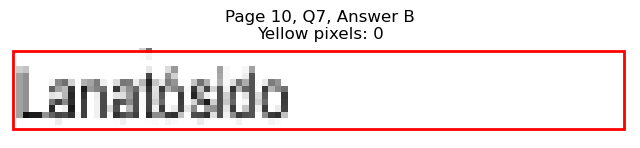

Page 10, Q7 - C: Detected box: x0=85.0, y0=567.1, x1=128.1, y1=579.2
Page 10, Q7, C: Yellow pixels: 951
Page 10, Q7, C: Total non-white pixels: 1235
Page 10, Q7, C: Yellow percentage: 77.0%


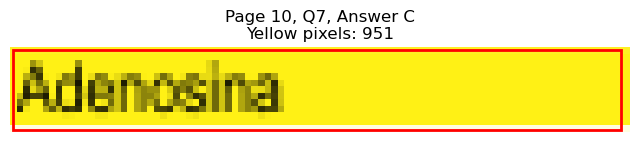

Page 10, Q7 - D: Detected box: x0=336.7, y0=542.9, x1=385.5, y1=555.0
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 238
Page 10, Q7, D: Yellow percentage: 0.0%


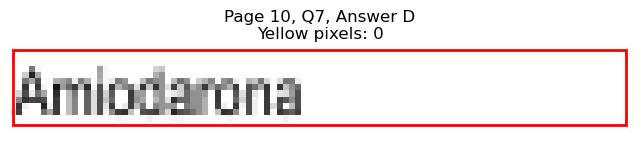

Page 10, Q7 - E: Detected box: x0=336.7, y0=554.9, x1=382.6, y1=567.0
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 239
Page 10, Q7, E: Yellow percentage: 0.0%


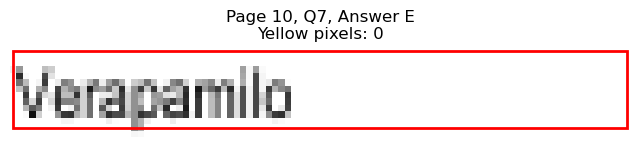


Page 10, Q7 - Selected Answer: C (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=85.0, y0=603.2, x1=152.1, y1=615.3
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 338
Page 10, Q8, A: Yellow percentage: 0.0%


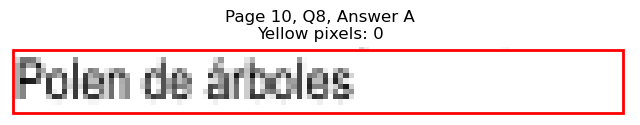

Page 10, Q8 - B: Detected box: x0=85.0, y0=615.2, x1=133.3, y1=627.3
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 248
Page 10, Q8, B: Yellow percentage: 0.0%


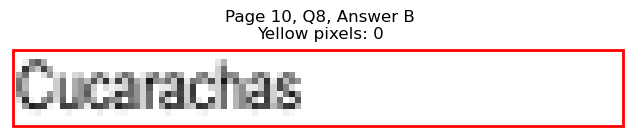

Page 10, Q8 - C: Detected box: x0=85.0, y0=627.3, x1=160.1, y1=639.4
Page 10, Q8, C: Yellow pixels: 1168
Page 10, Q8, C: Total non-white pixels: 1651
Page 10, Q8, C: Yellow percentage: 70.7%


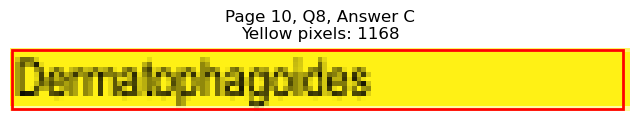

Page 10, Q8 - D: Detected box: x0=336.7, y0=603.2, x1=405.2, y1=615.3
Page 10, Q8, D: Yellow pixels: 0
Page 10, Q8, D: Total non-white pixels: 355
Page 10, Q8, D: Yellow percentage: 0.0%


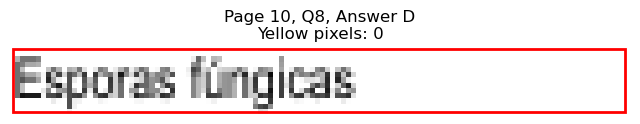

Page 10, Q8 - E: Detected box: x0=336.7, y0=615.2, x1=421.9, y1=627.3
Page 10, Q8, E: Yellow pixels: 0
Page 10, Q8, E: Total non-white pixels: 455
Page 10, Q8, E: Yellow percentage: 0.0%


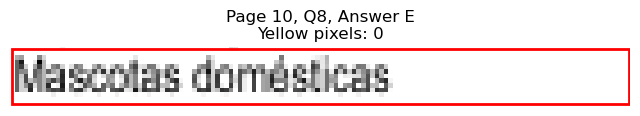


Page 10, Q8 - Selected Answer: C (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=85.0, y0=663.4, x1=121.3, y1=675.5
Page 10, Q9, A: Yellow pixels: 0
Page 10, Q9, A: Total non-white pixels: 185
Page 10, Q9, A: Yellow percentage: 0.0%


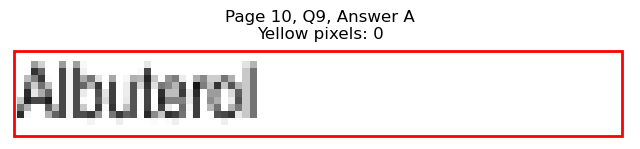

Page 10, Q9 - B: Detected box: x0=85.0, y0=675.4, x1=133.3, y1=687.5
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 258
Page 10, Q9, B: Yellow percentage: 0.0%


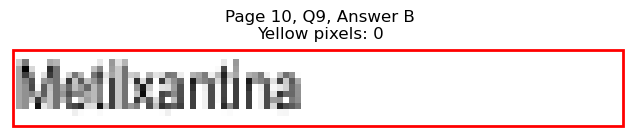

Page 10, Q9 - C: Detected box: x0=85.0, y0=687.5, x1=170.7, y1=699.7
Page 10, Q9, C: Yellow pixels: 1446
Page 10, Q9, C: Total non-white pixels: 1781
Page 10, Q9, C: Yellow percentage: 81.2%


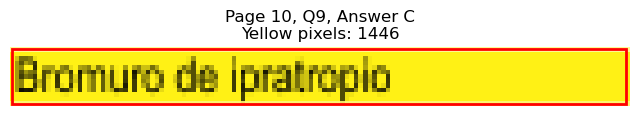

Page 10, Q9 - D: Detected box: x0=336.7, y0=663.4, x1=417.6, y1=675.5
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 412
Page 10, Q9, D: Yellow percentage: 0.0%


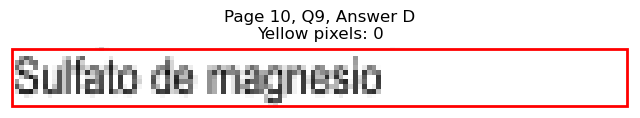

Page 10, Q9 - E: Detected box: x0=336.7, y0=675.4, x1=371.6, y1=687.5
Page 10, Q9, E: Yellow pixels: 0
Page 10, Q9, E: Total non-white pixels: 180
Page 10, Q9, E: Yellow percentage: 0.0%


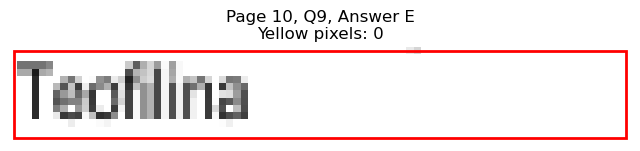


Page 10, Q9 - Selected Answer: C (based on yellow pixel count)




Page 10, Q10 - A: Detected box: x0=85.0, y0=723.7, x1=154.3, y1=735.8
Page 10, Q10, A: Yellow pixels: 0
Page 10, Q10, A: Total non-white pixels: 359
Page 10, Q10, A: Yellow percentage: 0.0%


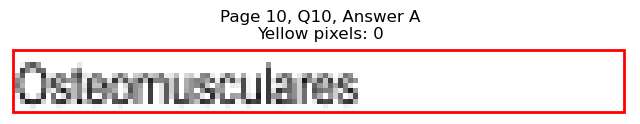

Page 10, Q10 - B: Detected box: x0=85.0, y0=735.8, x1=195.5, y1=747.9
Page 10, Q10, B: Yellow pixels: 0
Page 10, Q10, B: Total non-white pixels: 560
Page 10, Q10, B: Yellow percentage: 0.0%


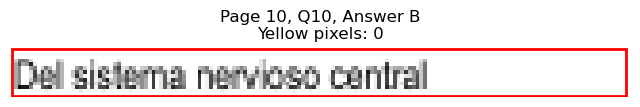

Page 10, Q10 - C: Detected box: x0=85.0, y0=747.8, x1=135.7, y1=759.9
Page 10, Q10, C: Yellow pixels: 0
Page 10, Q10, C: Total non-white pixels: 369
Page 10, Q10, C: Yellow percentage: 0.0%


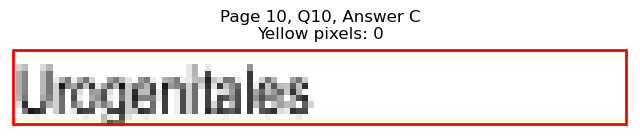

Page 10, Q10 - D: Detected box: x0=336.7, y0=723.7, x1=408.0, y1=735.8
Page 10, Q10, D: Yellow pixels: 0
Page 10, Q10, D: Total non-white pixels: 388
Page 10, Q10, D: Yellow percentage: 0.0%


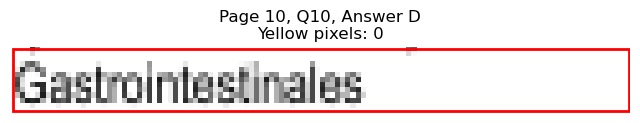

Page 10, Q10 - E: Detected box: x0=336.7, y0=735.8, x1=403.3, y1=747.9
Page 10, Q10, E: Yellow pixels: 1145
Page 10, Q10, E: Total non-white pixels: 1534
Page 10, Q10, E: Yellow percentage: 74.6%


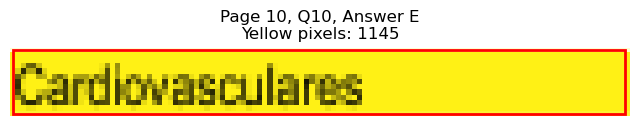


Page 10, Q10 - Selected Answer: E (based on yellow pixel count)





Page 11: Found 8 questions
Page 11, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=158.2, y1=109.2
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 430
Page 11, Q1, A: Yellow percentage: 0.0%


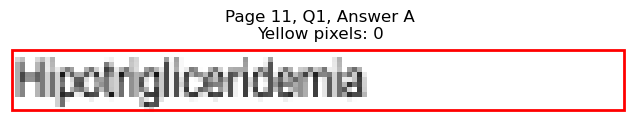

Page 11, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=136.8, y1=121.3
Page 11, Q1, B: Yellow pixels: 0
Page 11, Q1, B: Total non-white pixels: 278
Page 11, Q1, B: Yellow percentage: 0.0%


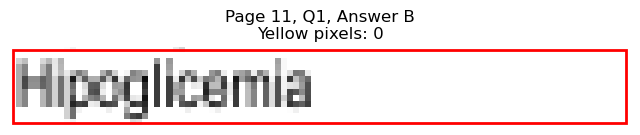

Page 11, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=140.5, y1=133.3
Page 11, Q1, C: Yellow pixels: 0
Page 11, Q1, C: Total non-white pixels: 299
Page 11, Q1, C: Yellow percentage: 0.0%


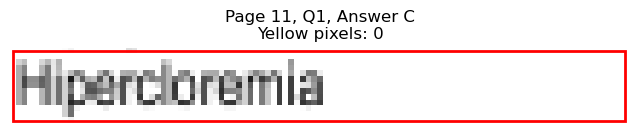

Page 11, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=386.5, y1=109.2
Page 11, Q1, D: Yellow pixels: 1001
Page 11, Q1, D: Total non-white pixels: 1313
Page 11, Q1, D: Yellow percentage: 76.2%


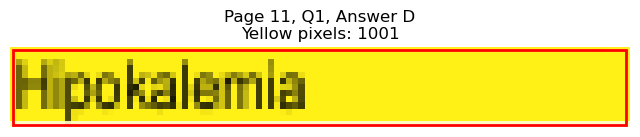

Page 11, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=390.3, y1=121.3
Page 11, Q1, E: Yellow pixels: 0
Page 11, Q1, E: Total non-white pixels: 389
Page 11, Q1, E: Yellow percentage: 0.0%


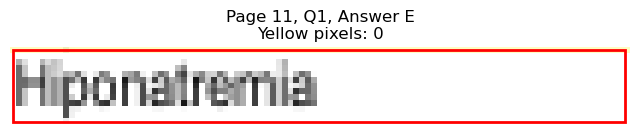


Page 11, Q1 - Selected Answer: D (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=85.0, y0=181.4, x1=130.0, y1=193.5
Page 11, Q2, A: Yellow pixels: 96
Page 11, Q2, A: Total non-white pixels: 348
Page 11, Q2, A: Yellow percentage: 27.6%


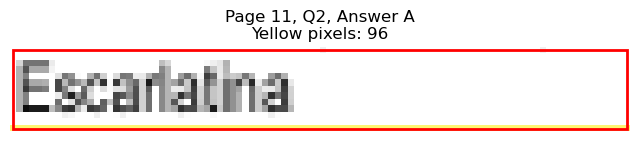

Page 11, Q2 - B: Detected box: x0=85.0, y0=193.4, x1=118.5, y1=205.5
Page 11, Q2, B: Yellow pixels: 983
Page 11, Q2, B: Total non-white pixels: 1105
Page 11, Q2, B: Yellow percentage: 89.0%


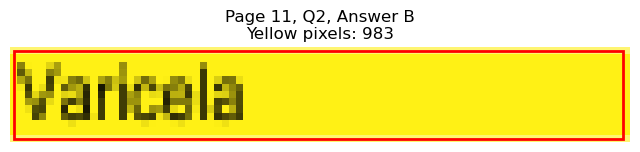

Page 11, Q2 - C: Detected box: x0=85.0, y0=205.5, x1=119.4, y1=217.7
Page 11, Q2, C: Yellow pixels: 86
Page 11, Q2, C: Total non-white pixels: 267
Page 11, Q2, C: Yellow percentage: 32.2%


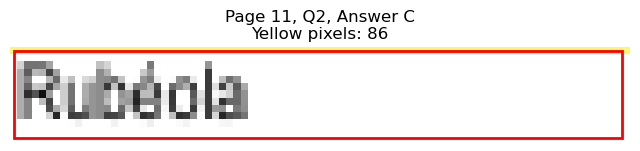

Page 11, Q2 - D: Detected box: x0=336.7, y0=181.4, x1=393.7, y1=193.5
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 284
Page 11, Q2, D: Yellow percentage: 0.0%


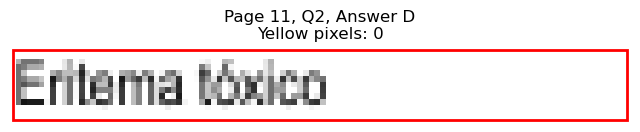

Page 11, Q2 - E: Detected box: x0=336.7, y0=193.4, x1=370.6, y1=205.5
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 177
Page 11, Q2, E: Yellow percentage: 0.0%


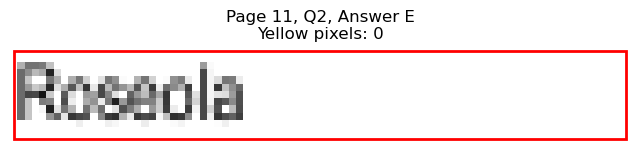


Page 11, Q2 - Selected Answer: B (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=85.0, y0=265.8, x1=197.9, y1=277.9
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 585
Page 11, Q3, A: Yellow percentage: 0.0%


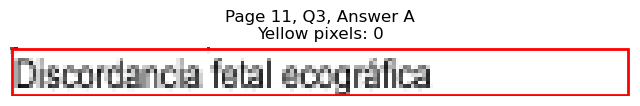

Page 11, Q3 - B: Detected box: x0=85.0, y0=277.8, x1=144.3, y1=289.9
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 313
Page 11, Q3, B: Yellow percentage: 0.0%


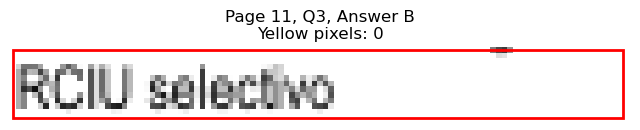

Page 11, Q3 - C: Detected box: x0=85.0, y0=289.9, x1=195.5, y1=302.0
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 534
Page 11, Q3, C: Yellow percentage: 0.0%


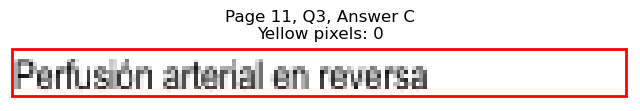

Page 11, Q3 - D: Detected box: x0=336.7, y0=265.8, x1=467.9, y1=277.9
Page 11, Q3, D: Yellow pixels: 1644
Page 11, Q3, D: Total non-white pixels: 2366
Page 11, Q3, D: Yellow percentage: 69.5%


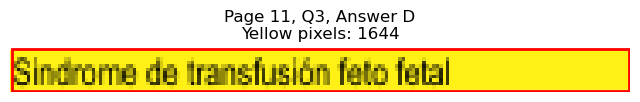

Page 11, Q3 - E: Detected box: x0=336.7, y0=277.8, x1=460.2, y1=289.9
Page 11, Q3, E: Yellow pixels: 175
Page 11, Q3, E: Total non-white pixels: 808
Page 11, Q3, E: Yellow percentage: 21.7%


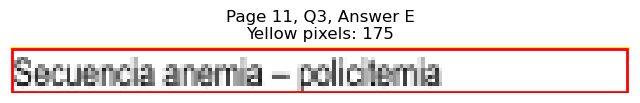


Page 11, Q3 - Selected Answer: D (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=85.0, y0=362.2, x1=108.4, y1=374.3
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 104
Page 11, Q4, A: Yellow percentage: 0.0%


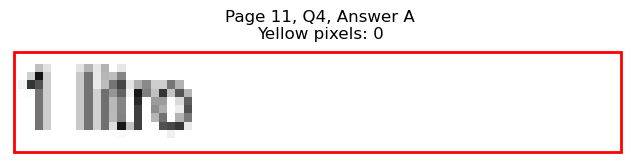

Page 11, Q4 - B: Detected box: x0=85.0, y0=374.2, x1=119.9, y1=386.3
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 153
Page 11, Q4, B: Yellow percentage: 0.0%


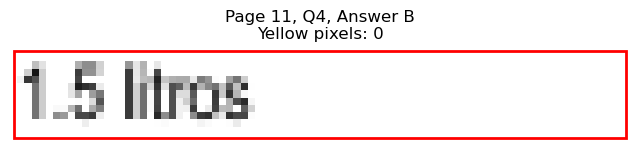

Page 11, Q4 - C: Detected box: x0=85.0, y0=386.3, x1=112.7, y1=398.4
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 134
Page 11, Q4, C: Yellow percentage: 0.0%


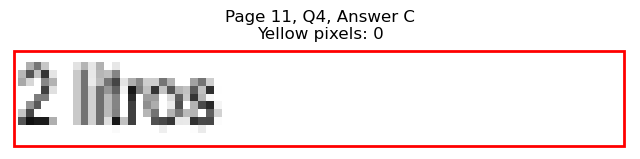

Page 11, Q4 - D: Detected box: x0=336.7, y0=362.2, x1=364.4, y1=374.3
Page 11, Q4, D: Yellow pixels: 841
Page 11, Q4, D: Total non-white pixels: 1027
Page 11, Q4, D: Yellow percentage: 81.9%


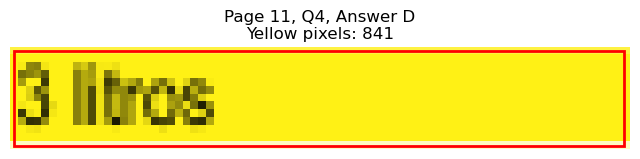

Page 11, Q4 - E: Detected box: x0=336.7, y0=374.2, x1=364.4, y1=386.3
Page 11, Q4, E: Yellow pixels: 0
Page 11, Q4, E: Total non-white pixels: 220
Page 11, Q4, E: Yellow percentage: 0.0%


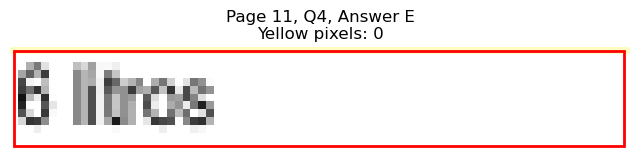


Page 11, Q4 - Selected Answer: D (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=85.0, y0=470.7, x1=129.0, y1=482.8
Page 11, Q5, A: Yellow pixels: 0
Page 11, Q5, A: Total non-white pixels: 308
Page 11, Q5, A: Yellow percentage: 0.0%


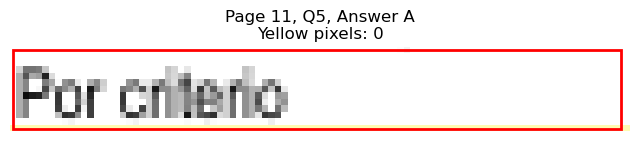

Page 11, Q5 - B: Detected box: x0=85.0, y0=482.7, x1=139.6, y1=494.8
Page 11, Q5, B: Yellow pixels: 1072
Page 11, Q5, B: Total non-white pixels: 1378
Page 11, Q5, B: Yellow percentage: 77.8%


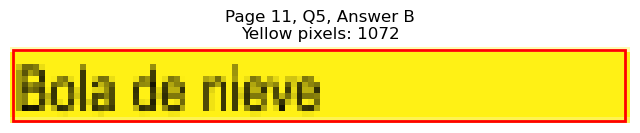

Page 11, Q5 - C: Detected box: x0=85.0, y0=494.7, x1=163.9, y1=506.8
Page 11, Q5, C: Yellow pixels: 130
Page 11, Q5, C: Total non-white pixels: 520
Page 11, Q5, C: Yellow percentage: 25.0%


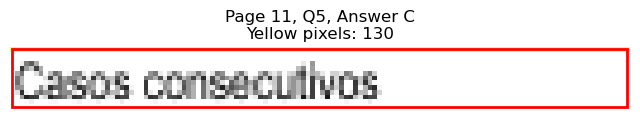

Page 11, Q5 - D: Detected box: x0=336.7, y0=470.7, x1=383.6, y1=482.8
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 256
Page 11, Q5, D: Yellow percentage: 0.0%


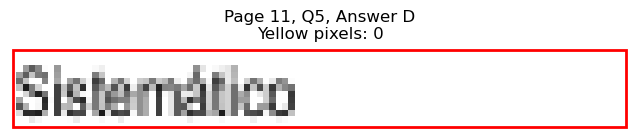

Page 11, Q5 - E: Detected box: x0=336.7, y0=482.7, x1=405.2, y1=494.8
Page 11, Q5, E: Yellow pixels: 0
Page 11, Q5, E: Total non-white pixels: 332
Page 11, Q5, E: Yellow percentage: 0.0%


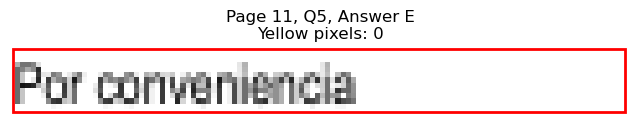


Page 11, Q5 - Selected Answer: B (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=85.0, y0=542.9, x1=183.6, y1=555.0
Page 11, Q6, A: Yellow pixels: 1392
Page 11, Q6, A: Total non-white pixels: 1955
Page 11, Q6, A: Yellow percentage: 71.2%


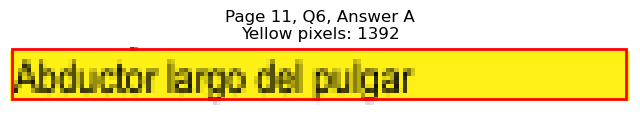

Page 11, Q6 - B: Detected box: x0=85.0, y0=554.9, x1=172.6, y1=567.0
Page 11, Q6, B: Yellow pixels: 129
Page 11, Q6, B: Total non-white pixels: 575
Page 11, Q6, B: Yellow percentage: 22.4%


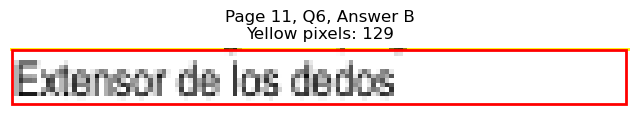

Page 11, Q6 - C: Detected box: x0=85.0, y0=567.1, x1=186.5, y1=579.2
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 500
Page 11, Q6, C: Yellow percentage: 0.0%


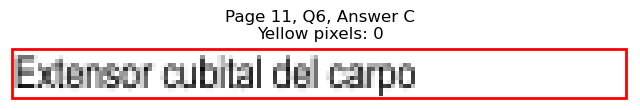

Page 11, Q6 - D: Detected box: x0=336.7, y0=542.9, x1=455.9, y1=555.0
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 588
Page 11, Q6, D: Yellow percentage: 0.0%


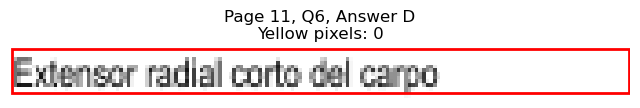

Page 11, Q6 - E: Detected box: x0=336.7, y0=554.9, x1=455.9, y1=567.0
Page 11, Q6, E: Yellow pixels: 0
Page 11, Q6, E: Total non-white pixels: 613
Page 11, Q6, E: Yellow percentage: 0.0%


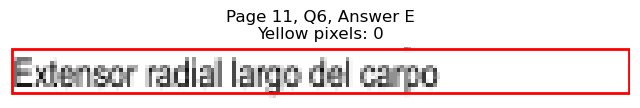


Page 11, Q6 - Selected Answer: A (based on yellow pixel count)




Page 11, Q7 - A: Detected box: x0=85.0, y0=615.2, x1=170.7, y1=627.3
Page 11, Q7, A: Yellow pixels: 0
Page 11, Q7, A: Total non-white pixels: 438
Page 11, Q7, A: Yellow percentage: 0.0%


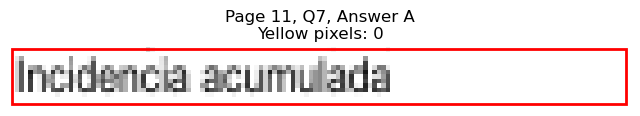

Page 11, Q7 - B: Detected box: x0=85.0, y0=627.3, x1=197.5, y1=639.4
Page 11, Q7, B: Yellow pixels: 164
Page 11, Q7, B: Total non-white pixels: 778
Page 11, Q7, B: Yellow percentage: 21.1%


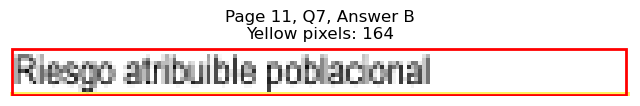

Page 11, Q7 - C: Detected box: x0=85.0, y0=639.3, x1=132.4, y1=651.4
Page 11, Q7, C: Yellow pixels: 1096
Page 11, Q7, C: Total non-white pixels: 1287
Page 11, Q7, C: Yellow percentage: 85.2%


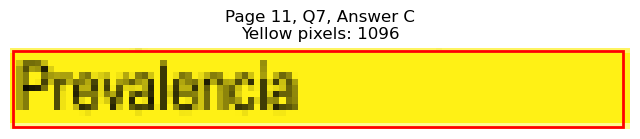

Page 11, Q7 - D: Detected box: x0=336.7, y0=615.2, x1=428.1, y1=627.3
Page 11, Q7, D: Yellow pixels: 0
Page 11, Q7, D: Total non-white pixels: 462
Page 11, Q7, D: Yellow percentage: 0.0%


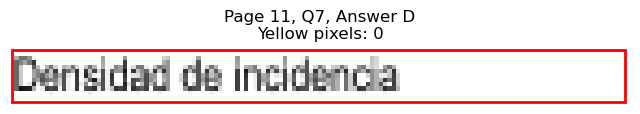

Page 11, Q7 - E: Detected box: x0=336.7, y0=627.3, x1=448.7, y1=639.4
Page 11, Q7, E: Yellow pixels: 0
Page 11, Q7, E: Total non-white pixels: 579
Page 11, Q7, E: Yellow percentage: 0.0%


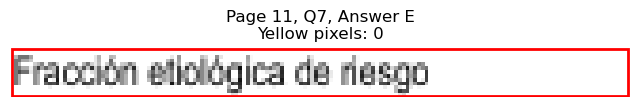


Page 11, Q7 - Selected Answer: C (based on yellow pixel count)




Page 11, Q8 - A: Detected box: x0=85.0, y0=687.5, x1=182.2, y1=699.7
Page 11, Q8, A: Yellow pixels: 0
Page 11, Q8, A: Total non-white pixels: 474
Page 11, Q8, A: Yellow percentage: 0.0%


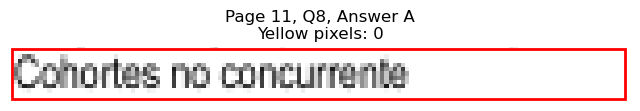

Page 11, Q8 - B: Detected box: x0=85.0, y0=699.5, x1=133.8, y1=711.7
Page 11, Q8, B: Yellow pixels: 0
Page 11, Q8, B: Total non-white pixels: 260
Page 11, Q8, B: Yellow percentage: 0.0%


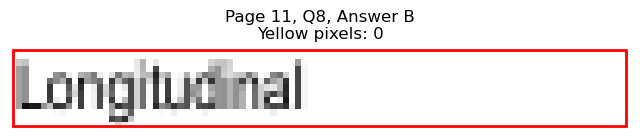

Page 11, Q8 - C: Detected box: x0=85.0, y0=711.7, x1=164.9, y1=723.8
Page 11, Q8, C: Yellow pixels: 0
Page 11, Q8, C: Total non-white pixels: 406
Page 11, Q8, C: Yellow percentage: 0.0%


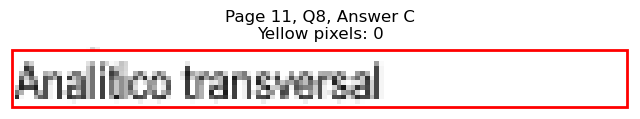

Page 11, Q8 - D: Detected box: x0=336.7, y0=687.5, x1=376.4, y1=699.7
Page 11, Q8, D: Yellow pixels: 1013
Page 11, Q8, D: Total non-white pixels: 1183
Page 11, Q8, D: Yellow percentage: 85.6%


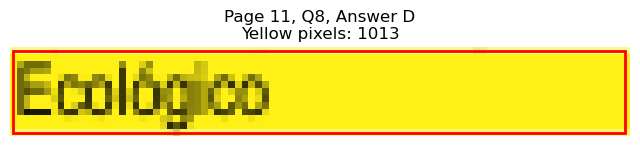

Page 11, Q8 - E: Detected box: x0=336.7, y0=699.5, x1=405.2, y1=711.7
Page 11, Q8, E: Yellow pixels: 120
Page 11, Q8, E: Total non-white pixels: 454
Page 11, Q8, E: Yellow percentage: 26.4%


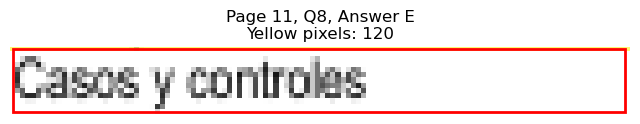


Page 11, Q8 - Selected Answer: D (based on yellow pixel count)





Page 12: Found 4 questions
Page 12, Q1 - A: Detected box: x0=85.0, y0=97.1, x1=106.6, y1=109.2
Page 12, Q1, A: Yellow pixels: 803
Page 12, Q1, A: Total non-white pixels: 949
Page 12, Q1, A: Yellow percentage: 84.6%


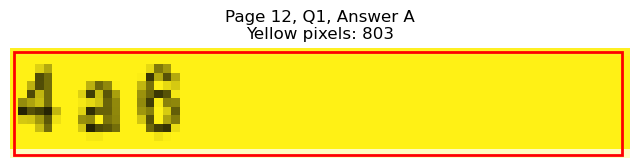

Page 12, Q1 - B: Detected box: x0=85.0, y0=109.2, x1=116.1, y1=121.3
Page 12, Q1, B: Yellow pixels: 0
Page 12, Q1, B: Total non-white pixels: 212
Page 12, Q1, B: Yellow percentage: 0.0%


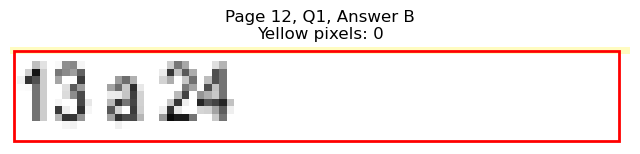

Page 12, Q1 - C: Detected box: x0=85.0, y0=121.2, x1=111.4, y1=133.3
Page 12, Q1, C: Yellow pixels: 0
Page 12, Q1, C: Total non-white pixels: 109
Page 12, Q1, C: Yellow percentage: 0.0%


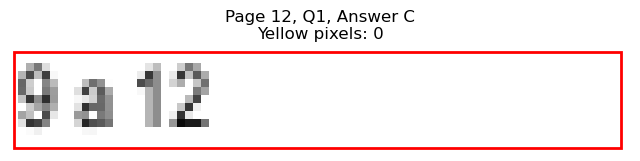

Page 12, Q1 - D: Detected box: x0=336.7, y0=97.1, x1=358.3, y1=109.2
Page 12, Q1, D: Yellow pixels: 0
Page 12, Q1, D: Total non-white pixels: 67
Page 12, Q1, D: Yellow percentage: 0.0%


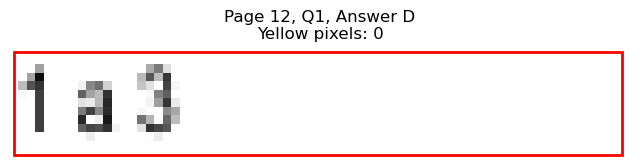

Page 12, Q1 - E: Detected box: x0=336.7, y0=109.2, x1=358.3, y1=121.3
Page 12, Q1, E: Yellow pixels: 0
Page 12, Q1, E: Total non-white pixels: 78
Page 12, Q1, E: Yellow percentage: 0.0%


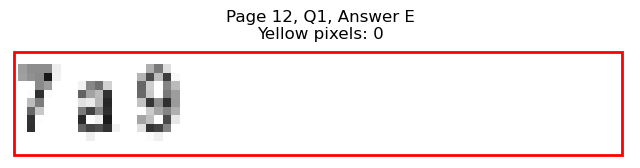


Page 12, Q1 - Selected Answer: A (based on yellow pixel count)




Page 12, Q2 - A: Detected box: x0=85.0, y0=193.4, x1=110.8, y1=205.5
Page 12, Q2, A: Yellow pixels: 0
Page 12, Q2, A: Total non-white pixels: 125
Page 12, Q2, A: Yellow percentage: 0.0%


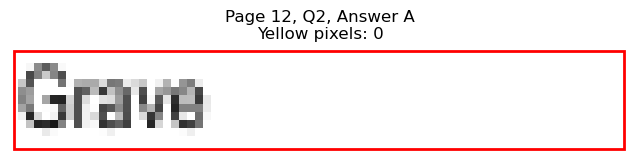

Page 12, Q2 - B: Detected box: x0=85.0, y0=205.5, x1=126.1, y1=217.7
Page 12, Q2, B: Yellow pixels: 1023
Page 12, Q2, B: Total non-white pixels: 1209
Page 12, Q2, B: Yellow percentage: 84.6%


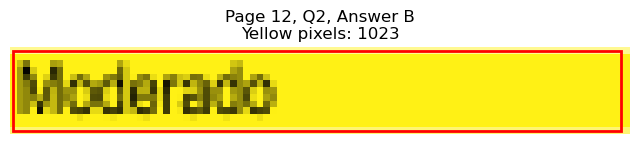

Page 12, Q2 - C: Detected box: x0=85.0, y0=217.5, x1=130.6, y1=229.7
Page 12, Q2, C: Yellow pixels: 97
Page 12, Q2, C: Total non-white pixels: 344
Page 12, Q2, C: Yellow percentage: 28.2%


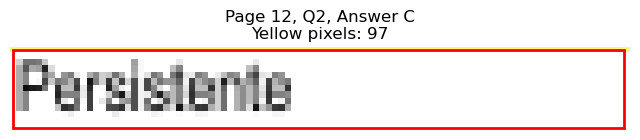

Page 12, Q2 - D: Detected box: x0=336.7, y0=193.4, x1=357.8, y1=205.5
Page 12, Q2, D: Yellow pixels: 0
Page 12, Q2, D: Total non-white pixels: 92
Page 12, Q2, D: Yellow percentage: 0.0%


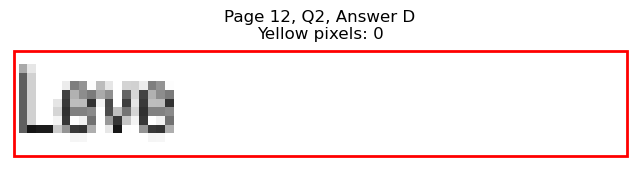

Page 12, Q2 - E: Detected box: x0=336.7, y0=205.5, x1=384.6, y1=217.7
Page 12, Q2, E: Yellow pixels: 0
Page 12, Q2, E: Total non-white pixels: 268
Page 12, Q2, E: Yellow percentage: 0.0%


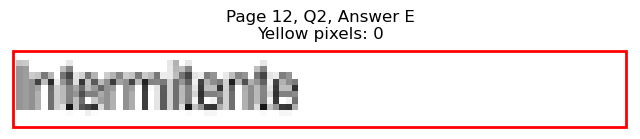


Page 12, Q2 - Selected Answer: B (based on yellow pixel count)




Page 12, Q3 - A: Detected box: x0=85.0, y0=253.7, x1=127.1, y1=265.8
Page 12, Q3, A: Yellow pixels: 928
Page 12, Q3, A: Total non-white pixels: 1222
Page 12, Q3, A: Yellow percentage: 75.9%


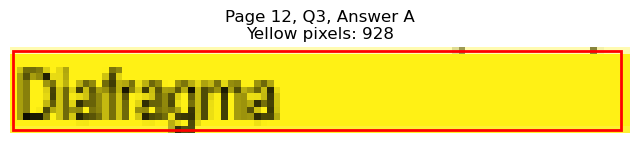

Page 12, Q3 - B: Detected box: x0=85.0, y0=265.8, x1=185.1, y1=277.9
Page 12, Q3, B: Yellow pixels: 148
Page 12, Q3, B: Total non-white pixels: 658
Page 12, Q3, B: Yellow percentage: 22.5%


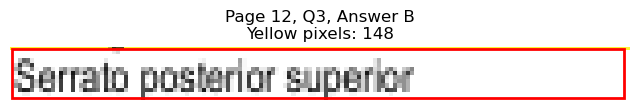

Page 12, Q3 - C: Detected box: x0=85.0, y0=277.8, x1=165.9, y1=289.9
Page 12, Q3, C: Yellow pixels: 0
Page 12, Q3, C: Total non-white pixels: 395
Page 12, Q3, C: Yellow percentage: 0.0%


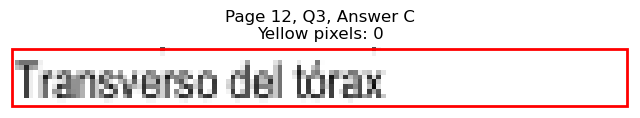

Page 12, Q3 - D: Detected box: x0=336.7, y0=253.7, x1=372.6, y1=265.8
Page 12, Q3, D: Yellow pixels: 0
Page 12, Q3, D: Total non-white pixels: 160
Page 12, Q3, D: Yellow percentage: 0.0%


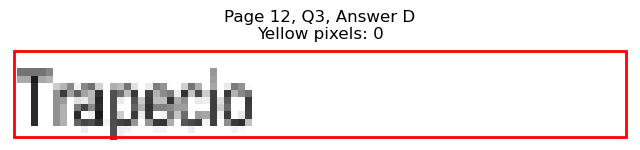

Page 12, Q3 - E: Detected box: x0=336.7, y0=265.8, x1=431.0, y1=277.9
Page 12, Q3, E: Yellow pixels: 0
Page 12, Q3, E: Total non-white pixels: 502
Page 12, Q3, E: Yellow percentage: 0.0%


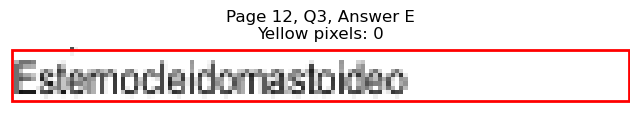


Page 12, Q3 - Selected Answer: A (based on yellow pixel count)




Page 12, Q4 - A: Detected box: x0=85.0, y0=338.1, x1=124.7, y1=350.2
Page 12, Q4, A: Yellow pixels: 0
Page 12, Q4, A: Total non-white pixels: 227
Page 12, Q4, A: Yellow percentage: 0.0%


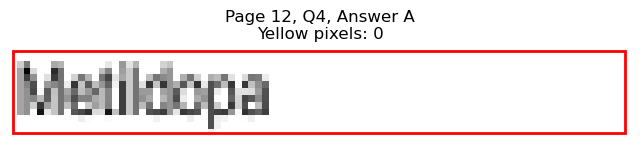

Page 12, Q4 - B: Detected box: x0=85.0, y0=350.2, x1=130.0, y1=362.3
Page 12, Q4, B: Yellow pixels: 0
Page 12, Q4, B: Total non-white pixels: 226
Page 12, Q4, B: Yellow percentage: 0.0%


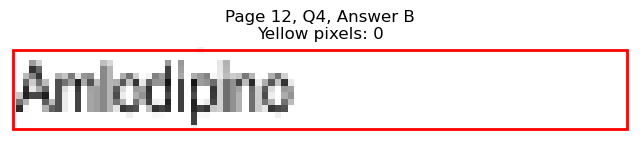

Page 12, Q4 - C: Detected box: x0=85.0, y0=362.2, x1=151.5, y1=374.3
Page 12, Q4, C: Yellow pixels: 0
Page 12, Q4, C: Total non-white pixels: 363
Page 12, Q4, C: Yellow percentage: 0.0%


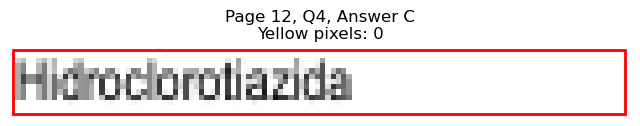

Page 12, Q4 - D: Detected box: x0=336.7, y0=338.1, x1=372.6, y1=350.2
Page 12, Q4, D: Yellow pixels: 884
Page 12, Q4, D: Total non-white pixels: 1131
Page 12, Q4, D: Yellow percentage: 78.2%


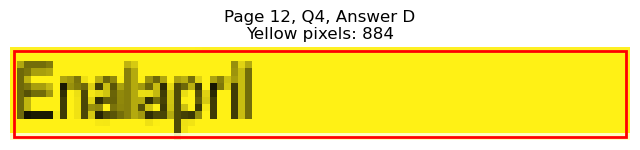

Page 12, Q4 - E: Detected box: x0=336.7, y0=350.2, x1=384.6, y1=362.3
Page 12, Q4, E: Yellow pixels: 0
Page 12, Q4, E: Total non-white pixels: 337
Page 12, Q4, E: Yellow percentage: 0.0%


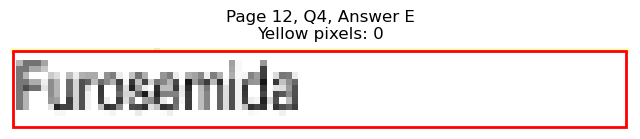


Page 12, Q4 - Selected Answer: D (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   ¿Cuál es el agente infeccioso más importante r...
1   ¿Cuál es la localización del embarazo ectópico...
2   Adolescente de 16 años, presenta prurito vagin...
3   Mujer de 22 años, G0P0, FUR hace 3 meses, régi...
4   Mediante las técnicas de bandas de alta resolu...
..                                                ...
95  Una investigación tuvo por objetivo correlacio...
96  ¿Cuántas horas dura el periodo de adaptación (...
97  Varón de 30 años, asmático, es llevado a emerg...
98   ¿Cuál es el músculo principal de la inspiración?
99  Varón de 45 años, asintomático, acude para eva...

[100 rows x 1 columns]

In [8]:
answers_df

option_A                       option_B  \
0                  Mycoplasma pneumoniae                      Influenza   
1                                Ovárico                        Istmico   
2                               Gonorrea                    Giardanella   
3   Tumor ovárico secretor de andrógenos  Hiperplasia adrenal congénita   
4                          Prader-Willi.                   Klinefelter.   
..                                   ...                            ...   
95               Cohortes no concurrente                   Longitudinal   
96                                 4 a 6                        13 a 24   
97                                 Grave                       Moderado   
98                             Diafragma     Serrato posterior superior   
99                             Metildopa                     Amlodipino   

                             option_C                         option_D  \
0        Virus sincitial respiratorio             Bordetella pertussis   
1                        Intersticial                          Ampular   
2                         Candidiasis                   Trichomoniasis   
3   Síndrome de ovarios poliquísticos  Hipogonadismo hipogonadotrófico   
4                             Turner.                            Down.   
..                                ...                              ...   
95              Analítico transversal                        Ecológico   
96                             9 a 12                            1 a 3   
97                        Persistente                             Leve   
98               Transverso del tórax                         Trapecio   
99                  Hidroclorotiazida                        Enalapril   

                  option_E  
0               Adenovirus  
1                Abdominal  
2                Vaginosis  
3      Síndrome de Cushing  
4                 Edwards.  
..                     ...  
95       Casos y controles  
96                   7 a 9  
97            Intermitente  
98  Esternocleidomastoideo  
99              Furosemida  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               E
1               C
2               D
3               C
4               A
..            ...
95              D
96              A
97              B
98              A
99              D

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   ¿Cuál es el agente infeccioso más importante r...   
1   ¿Cuál es la localización del embarazo ectópico...   
2   Adolescente de 16 años, presenta prurito vagin...   
3   Mujer de 22 años, G0P0, FUR hace 3 meses, régi...   
4   Mediante las técnicas de bandas de alta resolu...   
..                                                ...   
95  Una investigación tuvo por objetivo correlacio...   
96  ¿Cuántas horas dura el periodo de adaptación (...   
97  Varón de 30 años, asmático, es llevado a emerg...   
98   ¿Cuál es el músculo principal de la inspiración?   
99  Varón de 45 años, asintomático, acude para eva...   

                                option_A                       option_B  \
0                  Mycoplasma pneumoniae                      Influenza   
1                                Ovárico                        Istmico   
2                               Gonorrea                    Giardanella   
3   Tumor ovárico secretor de andrógenos  Hiperplasia adrenal congénita   
4                          Prader-Willi.                   Klinefelter.   
..                                   ...                            ...   
95               Cohortes no concurrente                   Longitudinal   
96                                 4 a 6                        13 a 24   
97                                 Grave                       Moderado   
98                             Diafragma     Serrato posterior superior   
99                             Metildopa                     Amlodipino   

                             option_C                         option_D  \
0        Virus sincitial respiratorio             Bordetella pertussis   
1                        Intersticial                          Ampular   
2                         Candidiasis                   Trichomoniasis   
3   Síndrome de ovarios poliquísticos  Hipogonadismo hipogonadotrófico   
4                             Turner.                            Down.   
..                                ...                              ...   
95              Analítico transversal                        Ecológico   
96                             9 a 12                            1 a 3   
97                        Persistente                             Leve   
98               Transverso del tórax                         Trapecio   
99                  Hidroclorotiazida                        Enalapril   

                  option_E correct_answer  
0               Adenovirus              E  
1                Abdominal              C  
2                Vaginosis              D  
3      Síndrome de Cushing              C  
4                 Edwards.              A  
..                     ...            ...  
95       Casos y controles              D  
96                   7 a 9              A  
97            Intermitente              B  
98  Esternocleidomastoideo              A  
99              Furosemida              D  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2019/PRUEBA B.csv
